In [1]:
"""The content of process_data.py"""

import collections
from collections import Counter
import random
import os
import math
import sys
sys.path.append('..')
import zipfile

import numpy as np
from six.moves import urllib
import tensorflow as tf


# Parameters for downloading data
DOWNLOAD_URL = 'http://mattmahoney.net/dc/'
EXPECTED_BYTES = 31344016
DATA_FOLDER = ''
FILE_NAME = 'text8.zip'


def make_dir(path):
    """ Create a directory if there isn't one already. """
    try:
        os.mkdir(path)
    except OSError:
        pass

def download(file_name, expected_bytes):
    """ Download the dataset text8 if it's not already downloaded """
    file_path = DATA_FOLDER + file_name
    if os.path.exists(file_path):
        print("Dataset ready")
        return file_path
    file_name, _ = urllib.request.urlretrieve(DOWNLOAD_URL + file_name, file_path)
    file_stat = os.stat(file_path)
    if file_stat.st_size == expected_bytes:
        print('Successfully downloaded the file', file_name)
    else:
        raise Exception('File ' + file_name +
                        ' might be corrupted. You should try downloading it with a browser.')
    return file_path


def read_data(file_path): # file_path='text8.zip'
    """ Read data into a list of tokens"""
    with zipfile.ZipFile(file_path) as f:
        words = tf.compat.as_str(f.read(f.namelist()[0])).split()
        # tf.compat.as_str() converts the input into the string
    return words

def build_vocab(words, vocab_size): # make most_common dictionary(10000 - 1)
    """ Build vocabulary of VOCAB_SIZE most frequent words """
    dictionary = dict()
    count = [('UNK', -1)]
    count.extend(Counter(words).most_common(vocab_size - 1))
    index = 0
    make_dir('processed')
    with open('processed/vocab_1000.tsv', "w") as f:
        for word, _ in count:
            dictionary[word] = index
            if index < 1000:
                f.write(word + "\n")
            index += 1
    index_dictionary = dict(zip(dictionary.values(), dictionary.keys()))
    return dictionary, index_dictionary

def convert_words_to_index(words, dictionary):
    """ Replace each word in the dataset with its index in the dictionary """
    return [dictionary[word] if word in dictionary else 0 for word in words]


def process_data(vocab_size):
    """ Read data, build vocabulary and dictionary"""
    file_path = download(FILE_NAME, EXPECTED_BYTES)
    words = read_data(file_path)
    dictionary, index_dictionary = build_vocab(words, vocab_size)
    index_words = convert_words_to_index(words, dictionary)
    print (len(words), words[:10])
    del words # to save memory
    return index_words, dictionary, index_dictionary

def generate_batch(data, batch_size, skip_window):
    # skip window is the amount of words we're looking at from each side of a given word
    # creates a single batch
    global data_index
    assert skip_window%2==1
 
    span = 2 * skip_window + 1 # [ skip_window target skip_window ]
 
    batch = np.ndarray(shape=(batch_size, span-1), dtype=np.int32)
    labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32)
    # e.g if skip_window = 2 then span = 5
    # span is the length of the whole frame we are considering for a single word (left + word + right)
    # skip_window is the length of one side
 
    # queue which add and pop at the end
    buffer = collections.deque(maxlen=span)
 
    #get words starting from index 0 to span
    data_index = 0
    for _ in range(span):
        buffer.append(data[data_index])
        data_index = (data_index + 1) % len(data)
 
    # num_skips => # of times we select a random word within the span?
    # batch_size (8) and num_skips (2) (4 times)
    # batch_size (8) and num_skips (1) (8 times)
    for i in range(batch_size):
        target = skip_window  # target label at the center of the buffer
        target_to_avoid = [ skip_window ] # we only need to know the words around a given word, not the word itself
 
        # do this num_skips (2 times)
        # do this (1 time)
        # add selected target to avoid_list for next time
        col_idx = 0
        for j in range(span):
            if j==span//2:
                continue
            # e.g. i=0, j=0 => 0; i=0,j=1 => 1; i=1,j=0 => 2
            batch[i,col_idx] = buffer[j] # [skip_window] => middle element
            col_idx += 1
        labels[i, 0] = buffer[target]
 
        buffer.append(data[data_index])
        data_index = (data_index + 1) % len(data)
 
    assert batch.shape[0]==batch_size and batch.shape[1]== span-1
    return batch, labels

/Users/unahsu/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [2]:
vocab_size = 10000
window_sz = 1
batch_sz = 64

index_words, dictionary, index_dictionary = process_data(vocab_size) #len(index_words)=17005207
X, y = generate_batch(index_words, batch_sz, window_sz)

Dataset ready
17005207 ['anarchism', 'originated', 'as', 'a', 'term', 'of', 'abuse', 'first', 'used', 'against']


In [3]:
for i in range(10): # print out the pairs
    data = index_dictionary[X[i, 0]], index_dictionary[X[i, 1]]
    label = index_dictionary[y[i,0]]
    print('(', data, label,')')

( ('anarchism', 'as') originated )
( ('originated', 'a') as )
( ('as', 'term') a )
( ('a', 'of') term )
( ('term', 'abuse') of )
( ('of', 'first') abuse )
( ('abuse', 'used') first )
( ('first', 'against') used )
( ('used', 'early') against )
( ('against', 'working') early )


### BCOW

In [4]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import collections
import math
import os
import random
import zipfile

import numpy as np
from six.moves import urllib
from six.moves import xrange  # pylint: disable=redefined-builtin
import tensorflow as tf

# Step 1: Download the data.
url = 'http://mattmahoney.net/dc/'


def maybe_download(filename, expected_bytes):
    """Download a file if not present, and make sure it's the right size."""
    if not os.path.exists(filename):
        filename, _ = urllib.request.urlretrieve(url + filename, filename)
    statinfo = os.stat(filename)
    if statinfo.st_size == expected_bytes:
        print('Found and verified', filename)
    else:
        print(statinfo.st_size)
        raise Exception(
            'Failed to verify ' + filename + '. Can you get to it with a browser?')
    return filename


filename = maybe_download('text8.zip', 31344016)


# Read the data into a list of strings.
def read_data(filename):
    """Extract the first file enclosed in a zip file as a list of words"""
    with zipfile.ZipFile(filename) as f:
        data = tf.compat.as_str(f.read(f.namelist()[0])).split()
    return data


words = read_data(filename)
print('Data size', len(words))

Found and verified text8.zip
Data size 17005207


In [5]:
# Step 2: Build the dictionary and replace rare words with UNK token.
vocabulary_size = 50000 #50000


def build_dataset(words):
    count = [['UNK', -1]]
    count.extend(collections.Counter(words).most_common(vocabulary_size - 1))
    dictionary = dict()
    for word, _ in count:
        dictionary[word] = len(dictionary)
    data = list()
    unk_count = 0
    for word in words:
        if word in dictionary:
            index = dictionary[word]
        else:
            index = 0  # dictionary['UNK']
            unk_count += 1
        data.append(index)
    count[0][1] = unk_count
    reverse_dictionary = dict(zip(dictionary.values(), dictionary.keys()))
    return data, count, dictionary, reverse_dictionary


data, count, dictionary, reverse_dictionary = build_dataset(words)
del words  # Hint to reduce memory.
print('Most common words (+UNK)', count[:5])
print('Sample data', data[:10], [reverse_dictionary[i] for i in data[:10]])

Most common words (+UNK) [['UNK', 418391], ('the', 1061396), ('of', 593677), ('and', 416629), ('one', 411764)]
Sample data [5234, 3081, 12, 6, 195, 2, 3134, 46, 59, 156] ['anarchism', 'originated', 'as', 'a', 'term', 'of', 'abuse', 'first', 'used', 'against']


In [6]:
data_index = 0

# Step 3: Function to generate a training batch for the skip-gram model.
def generate_batch(batch_size, context_window):
    # all context tokens should be used, hence no associated num_skips argument
    global data_index
    context_size = 2 * context_window
    batch = np.ndarray(shape=(batch_size, context_size), dtype=np.int32)
    labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32)
    span = 2 * context_window + 1  # [ context_window target context_window ]
    buffer = collections.deque(maxlen=span)
    for _ in range(span):
        buffer.append(data[data_index])
        data_index = (data_index + 1) % len(data)
    for i in range(batch_size):
        # context tokens are just all the tokens in buffer except the target
        batch[i, :] = [token for idx, token in enumerate(buffer) if idx != context_window]
        labels[i, 0] = buffer[context_window]
        buffer.append(data[data_index])
        data_index = (data_index + 1) % len(data)
    return batch, labels


batch, labels = generate_batch(batch_size=8, context_window=1)
for i in range(8):
    print(batch[i, 0], reverse_dictionary[batch[i, 0]],
          batch[i, 1], reverse_dictionary[batch[i, 1]],
          '->', labels[i, 0], reverse_dictionary[labels[i, 0]])


5234 anarchism 12 as -> 3081 originated
3081 originated 6 a -> 12 as
12 as 195 term -> 6 a
6 a 2 of -> 195 term
195 term 3134 abuse -> 2 of
2 of 46 first -> 3134 abuse
3134 abuse 59 used -> 46 first
46 first 156 against -> 59 used


In [7]:
# Step 4: Build and train a skip-gram model.

batch_size = 128
embedding_size = 128  # Dimension of the embedding vector.
context_window = 1    # How many words to consider left and right.
context_size = 2 * context_window

# We pick a random validation set to sample nearest neighbors.
# Here we limit the validation samples to the words that have a low numeric ID,
# which by construction are also the most frequent.

valid_size = 16     # Random set of words to evaluate similarity on.
valid_window = 100  # Only pick dev samples in the head of the distribution.
valid_examples = np.random.choice(valid_window, valid_size, replace=False)
num_sampled = 64    # Number of negative examples to sample.

graph = tf.Graph()

with graph.as_default():
    # Input data.
    train_inputs = tf.placeholder(tf.int32, shape=[batch_size, context_size])
    train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1])
    valid_dataset = tf.constant(valid_examples, dtype=tf.int32)

    # Ops and variables pinned to the CPU because of missing GPU implementation
    with tf.device('/cpu:0'):
        # Look up embeddings for inputs.
        embeddings = tf.Variable(
            tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0)) #10000X128
        embed = tf.nn.embedding_lookup(embeddings, train_inputs)
        # take mean of embeddings of context words for context embedding
        embed_context = tf.reduce_mean(embed, 1)

        # Construct the variables for the NCE loss
        nce_weights = tf.Variable(
            tf.truncated_normal([vocabulary_size, embedding_size],
                                stddev=1.0 / math.sqrt(embedding_size)))
        nce_biases = tf.Variable(tf.zeros([vocabulary_size]))

    # Compute the average NCE loss for the batch.
    # tf.nce_loss automatically draws a new sample of the negative labels each time we evaluate the loss.
    loss = tf.reduce_mean(
        tf.nn.nce_loss(nce_weights, nce_biases, train_labels, embed_context, num_sampled, vocabulary_size))
    # Construct the SGD optimizer using a learning rate of 1.0.
    optimizer = tf.train.GradientDescentOptimizer(1.0).minimize(loss)

    # Compute the cosine similarity between minibatch examples and all embeddings.
    norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keep_dims=True))
    normalized_embeddings = embeddings / norm
    valid_embeddings = tf.nn.embedding_lookup(normalized_embeddings, valid_dataset)
    similarity = tf.matmul(valid_embeddings, normalized_embeddings, transpose_b=True)

    # Add variable initializer.
    init = tf.global_variables_initializer()


In [8]:
# Step 5: Begin training.
num_steps = len(data)

with tf.Session(graph=graph) as session:
    # We must initialize all variables before we use them.
    init.run()
    print("Initialized")

    average_loss = 0
    for step in xrange(num_steps):
        batch_inputs, batch_labels = generate_batch(batch_size, context_window)
        feed_dict = {train_inputs: batch_inputs, train_labels: batch_labels}

        # We perform one update step by evaluating the optimizer op (including it
        # in the list of returned values for session.run()
        _, loss_val = session.run([optimizer, loss], feed_dict=feed_dict)
        average_loss += loss_val

        if step % 2000 == 0:
            if step > 0:
                average_loss /= 2000
            # The average loss is an estimate of the loss over the last 2000 batches.
            print("Average loss at step ", step, ": ", average_loss)
            average_loss = 0

        # Note that this is expensive (~20% slowdown if computed every 500 steps)
        if step % 10000 == 0:
            sim = similarity.eval()
            for i in xrange(valid_size):
                valid_word = reverse_dictionary[valid_examples[i]]
                top_k = 8  # number of nearest neighbors
                nearest = (-sim[i, :]).argsort()[1:top_k + 1]
                log_str = "Nearest to %s:" % valid_word
                for k in xrange(top_k):
                    close_word = reverse_dictionary[nearest[k]]
                    log_str = "%s %s," % (log_str, close_word)
                print(log_str)
    final_embeddings = normalized_embeddings.eval()


Initialized
Average loss at step  0 :  286.941131592
Nearest to one: nassau, euroscepticism, cretan, tarnished, shema, tears, layla, natively,
Nearest to been: arctos, jarman, saab, magellan, figurative, seamen, conversions, patrols,
Nearest to so: liffey, radar, glaucus, reuters, landslides, motilal, prima, mix,
Nearest to as: euroscepticism, kilmer, sadism, refuses, lba, windsurfing, mahabharata, dialog,
Nearest to there: proctor, decrees, zhuang, norodom, manchester, earldom, maccabean, trusts,
Nearest to which: linear, tos, thigh, sexual, abode, hamlets, bums, marshes,
Nearest to his: kidman, dems, horst, strom, poetic, dearborn, dayton, hofstadter,
Nearest to about: soninke, cemented, torre, tinge, bonn, liberals, ung, glibc,
Nearest to people: perfect, soaps, cubs, pharmacology, establishes, egyptian, breeze, moussa,
Nearest to but: blankets, virtualization, particulate, gerrard, trials, dangling, deontology, acceptors,
Nearest to would: fresnel, plutinos, serve, caesars, happeni

Average loss at step  52000 :  4.63372199374
Average loss at step  54000 :  4.53604136837
Average loss at step  56000 :  4.47823973727
Average loss at step  58000 :  4.38466654265
Average loss at step  60000 :  4.41589096951
Nearest to one: two, marmoset, cegep, degli, agave, six, approximant, upanija,
Nearest to been: be, become, assistance, were, was, markets, arctos, pain,
Nearest to so: radar, degli, pressed, commons, retains, therefore, physicians, hands,
Nearest to as: evacuated, true, ought, approximations, pinyin, autism, em, refuses,
Nearest to there: they, it, he, gamma, still, often, she, aeronautics,
Nearest to which: that, this, usually, still, also, thigh, activist, it,
Nearest to his: their, her, its, the, strom, dems, images, entities,
Nearest to about: proceeded, victory, over, around, ata, establishments, connect, burkert,
Nearest to people: cubs, scientists, egyptian, lions, global, pharmacology, team, ming,
Nearest to but: however, and, although, gradual, represents

Average loss at step  112000 :  4.13061696267
Average loss at step  114000 :  4.13686869562
Average loss at step  116000 :  4.14389770973
Average loss at step  118000 :  3.99422623372
Average loss at step  120000 :  3.9113756035
Nearest to one: audita, bde, factum, landesverband, marmoset, two, cegep, agave,
Nearest to been: be, become, was, were, assistance, already, extract, amaziah,
Nearest to so: radar, therefore, permission, event, commons, sterile, senseless, worked,
Nearest to as: evacuated, bde, earliest, because, whisper, presents, katydids, deuteronomy,
Nearest to there: they, it, he, she, gamma, biologically, beryl, illiterate,
Nearest to which: that, this, also, requests, what, usually, marmoset, these,
Nearest to his: her, their, its, your, the, my, our, dems,
Nearest to about: around, widehat, over, burkert, jude, victory, tinge, dare,
Nearest to people: scientists, cubs, suras, women, pharmacology, wy, duplicated, species,
Nearest to but: however, although, and, though, 

Average loss at step  172000 :  3.94210364485
Average loss at step  174000 :  3.93255037761
Average loss at step  176000 :  3.90814799988
Average loss at step  178000 :  3.88716998905
Average loss at step  180000 :  3.87306051028
Nearest to one: audita, bde, factum, rajonas, agave, marmoset, landesverband, cegep,
Nearest to been: be, become, was, already, were, assistance, caa, amaziah,
Nearest to so: therefore, too, less, sterile, event, commons, relatively, radar,
Nearest to as: evacuated, slashing, fang, earliest, whisper, katydids, outskirts, superintendent,
Nearest to there: they, it, he, she, we, these, arguable, beryl,
Nearest to which: that, this, what, also, these, requests, marmoset, typically,
Nearest to his: her, their, your, its, my, our, the, horst,
Nearest to about: around, widehat, over, burkert, jude, wiles, capitulated, dare,
Nearest to people: scientists, women, cubs, suras, pharmacology, men, duplicated, players,
Nearest to but: however, although, and, though, gradu

Average loss at step  232000 :  3.75179668379
Average loss at step  234000 :  3.76392072296
Average loss at step  236000 :  3.83801628077
Average loss at step  238000 :  3.8358941958
Average loss at step  240000 :  3.71552336609
Nearest to one: two, audita, bde, landesverband, factum, rajonas, agave, marmoset,
Nearest to been: be, become, were, was, already, assistance, patrols, seele,
Nearest to so: too, therefore, relatively, less, sterile, event, commons, honouring,
Nearest to as: evacuated, whisper, slashing, including, outskirts, percussive, presents, iuds,
Nearest to there: they, it, he, she, we, these, beryl, arguable,
Nearest to which: that, this, these, what, typically, also, marmoset, usually,
Nearest to his: her, their, your, my, its, our, whose, horst,
Nearest to about: around, widehat, dare, over, wiles, burkert, capitulated, jude,
Nearest to people: scientists, women, men, suras, pharmacology, cubs, jews, country,
Nearest to but: however, although, and, though, zorro, gra

Average loss at step  292000 :  3.58098508877
Average loss at step  294000 :  3.73766972017
Average loss at step  296000 :  3.76310860109
Average loss at step  298000 :  3.72754158276
Average loss at step  300000 :  3.760447653
Nearest to one: audita, two, landesverband, bde, agave, factum, rajonas, marmoset,
Nearest to been: be, become, already, were, was, seele, patrols, assistance,
Nearest to so: too, therefore, relatively, less, stacks, honouring, groundwater, sterile,
Nearest to as: evacuated, whisper, slashing, because, outskirts, including, percussive, katydids,
Nearest to there: they, it, he, we, she, arguable, these, biologically,
Nearest to which: that, this, typically, what, these, also, usually, but,
Nearest to his: her, their, your, my, its, our, horst, whose,
Nearest to about: around, over, approximately, widehat, dare, wiles, capitulated, literal,
Nearest to people: scientists, women, men, players, jews, pharmacology, suras, historians,
Nearest to but: however, although,

Average loss at step  352000 :  3.81069017124
Average loss at step  354000 :  3.73324560964
Average loss at step  356000 :  3.68327301645
Average loss at step  358000 :  3.37005994517
Average loss at step  360000 :  3.48761011434
Nearest to one: audita, bde, rajonas, factum, landesverband, agave, marmoset, cegep,
Nearest to been: be, become, already, were, was, seen, come, seele,
Nearest to so: too, therefore, relatively, less, stacks, honouring, groundwater, imitate,
Nearest to as: evacuated, whisper, including, slashing, outskirts, because, presents, croatian,
Nearest to there: they, it, we, he, she, arguable, these, zhuang,
Nearest to which: that, this, typically, what, but, marmoset, usually, also,
Nearest to his: her, their, your, my, its, our, the, whose,
Nearest to about: around, approximately, dare, over, widehat, wiles, capitulated, tinge,
Nearest to people: scientists, women, men, players, jews, americans, children, suras,
Nearest to but: however, although, and, though, omim,

Nearest to three: four, five, two, six, seven, eight, bde, factum,
Nearest to that: which, what, however, doves, where, loon, veterans, selberg,
Average loss at step  412000 :  3.69493569958
Average loss at step  414000 :  3.67665240109
Average loss at step  416000 :  3.69310463846
Average loss at step  418000 :  3.6949364928
Average loss at step  420000 :  3.62229179782
Nearest to one: two, audita, bde, agave, landesverband, factum, upanija, rajonas,
Nearest to been: be, become, already, were, was, seen, come, gone,
Nearest to so: too, therefore, relatively, less, honouring, thus, stacks, groundwater,
Nearest to as: whisper, slashing, including, evacuated, cayley, because, outskirts, presents,
Nearest to there: they, it, we, he, she, arguable, zhuang, biologically,
Nearest to which: that, this, typically, what, but, usually, however, these,
Nearest to his: her, their, your, my, its, our, whose, horst,
Nearest to about: around, approximately, dare, over, widehat, furthermore, capitulat

Nearest to three: four, five, two, six, seven, eight, factum, bde,
Nearest to that: which, what, however, doves, loon, pani, chandler, where,
Average loss at step  472000 :  3.60441969705
Average loss at step  474000 :  3.61989410889
Average loss at step  476000 :  3.650796085
Average loss at step  478000 :  3.64546471107
Average loss at step  480000 :  3.5782834295
Nearest to one: audita, agave, landesverband, two, bde, factum, upanija, marmoset,
Nearest to been: be, become, already, were, fallen, come, was, seen,
Nearest to so: too, therefore, relatively, thus, stacks, groundwater, honouring, grammarian,
Nearest to as: slashing, including, whisper, evacuated, outskirts, percussive, because, ought,
Nearest to there: they, it, we, he, she, arguable, biologically, zhuang,
Nearest to which: that, this, what, typically, but, egalitarianism, marmoset, bpm,
Nearest to his: her, their, my, your, its, our, whose, redding,
Nearest to about: around, approximately, dare, regarding, over, further

Average loss at step  532000 :  3.58758036929
Average loss at step  534000 :  3.63248071849
Average loss at step  536000 :  3.61639169335
Average loss at step  538000 :  3.5335080893
Average loss at step  540000 :  3.5878005693
Nearest to one: audita, bde, agave, factum, landesverband, two, delft, upanija,
Nearest to been: be, become, already, were, come, begun, seen, fallen,
Nearest to so: too, therefore, relatively, thus, enough, grammarian, honouring, groundwater,
Nearest to as: whisper, including, slashing, evacuated, validity, outskirts, constricted, photograph,
Nearest to there: they, it, we, she, he, arguable, these, biologically,
Nearest to which: that, this, typically, what, lamenting, usually, but, these,
Nearest to his: her, their, my, your, its, our, whose, horst,
Nearest to about: around, approximately, regarding, dare, over, furthermore, dordrecht, capitulated,
Nearest to people: scientists, women, men, jews, players, americans, children, historians,
Nearest to but: howev

Average loss at step  592000 :  3.57974043941
Average loss at step  594000 :  3.48211618108
Average loss at step  596000 :  3.61267320919
Average loss at step  598000 :  3.62629200077
Average loss at step  600000 :  3.52597648931
Nearest to one: two, audita, bde, agave, landesverband, factum, rebekah, delft,
Nearest to been: be, become, already, were, fallen, was, begun, come,
Nearest to so: too, therefore, thus, felt, grammarian, relatively, stacks, groundwater,
Nearest to as: slashing, whisper, including, evacuated, because, ebbets, ought, outskirts,
Nearest to there: they, it, we, he, she, arguable, unable, zhuang,
Nearest to which: that, this, typically, what, but, usually, egalitarianism, also,
Nearest to his: her, their, my, your, its, our, whose, redding,
Nearest to about: approximately, around, regarding, dare, over, furthermore, capitulated, exactly,
Nearest to people: scientists, women, men, americans, jews, players, children, individuals,
Nearest to but: however, although, t

Average loss at step  652000 :  3.55126259243
Average loss at step  654000 :  3.49936941481
Average loss at step  656000 :  3.5806788069
Average loss at step  658000 :  3.47343629777
Average loss at step  660000 :  3.55567715901
Nearest to one: audita, bde, agave, landesverband, factum, rajonas, kalevala, derails,
Nearest to been: be, become, already, were, fallen, begun, gone, come,
Nearest to so: too, therefore, thus, felt, groundwater, relatively, then, grammarian,
Nearest to as: including, whisper, evacuated, slashing, outskirts, photograph, validity, internationally,
Nearest to there: they, it, we, she, he, arguable, unable, these,
Nearest to which: that, this, typically, what, lamenting, but, who, usually,
Nearest to his: her, their, my, your, its, our, whose, redding,
Nearest to about: approximately, around, regarding, over, dare, furthermore, exactly, dordrecht,
Nearest to people: women, scientists, jews, players, men, americans, individuals, tourists,
Nearest to but: however, 

Average loss at step  712000 :  3.56346092403
Average loss at step  714000 :  3.45417378443
Average loss at step  716000 :  3.47447419906
Average loss at step  718000 :  3.4947480827
Average loss at step  720000 :  3.54925227678
Nearest to one: audita, bde, agave, landesverband, factum, two, derails, abstaining,
Nearest to been: be, become, were, already, fallen, begun, come, gone,
Nearest to so: too, therefore, thus, felt, grammarian, groundwater, enough, stacks,
Nearest to as: slashing, including, whisper, because, dissenters, evacuated, outskirts, validity,
Nearest to there: they, we, it, he, she, arguable, zhuang, unable,
Nearest to which: that, this, typically, what, but, usually, also, principally,
Nearest to his: her, their, my, your, its, our, whose, redding,
Nearest to about: approximately, regarding, around, dare, furthermore, over, exactly, capitulated,
Nearest to people: women, scientists, jews, americans, players, men, individuals, tourists,
Nearest to but: however, althou

Average loss at step  772000 :  3.42278356147
Average loss at step  774000 :  3.56790762287
Average loss at step  776000 :  3.49008622992
Average loss at step  778000 :  3.55330953896
Average loss at step  780000 :  3.52514458656
Nearest to one: bde, audita, agave, two, factum, landesverband, delft, asexually,
Nearest to been: be, become, already, were, fallen, begun, gone, come,
Nearest to so: too, therefore, thus, felt, grammarian, relatively, imitate, enough,
Nearest to as: including, whisper, slashing, outskirts, although, because, validity, evacuated,
Nearest to there: they, we, he, it, she, arguable, these, stalled,
Nearest to which: that, this, typically, what, but, usually, also, lamenting,
Nearest to his: her, their, my, your, its, our, whose, redding,
Nearest to about: approximately, regarding, around, dare, exactly, pseudoscience, over, furthermore,
Nearest to people: women, scientists, jews, individuals, men, americans, players, tourists,
Nearest to but: however, although, 

Nearest to that: which, what, however, doves, pani, loon, zander, where,
Average loss at step  832000 :  3.53962184155
Average loss at step  834000 :  3.51906626105
Average loss at step  836000 :  3.41489938813
Average loss at step  838000 :  3.51241393411
Average loss at step  840000 :  3.51420123363
Nearest to one: audita, bde, agave, two, factum, delft, four, five,
Nearest to been: be, become, already, were, fallen, begun, gone, grown,
Nearest to so: too, therefore, thus, felt, grammarian, enough, groundwater, then,
Nearest to as: slashing, whisper, outskirts, because, including, cayley, evacuated, validity,
Nearest to there: they, we, it, he, she, arguable, zhuang, unable,
Nearest to which: that, this, what, typically, but, usually, whom, also,
Nearest to his: her, their, my, your, its, our, whose, redding,
Nearest to about: approximately, regarding, around, exactly, over, dare, concerning, furthermore,
Nearest to people: women, scientists, americans, jews, individuals, players, to

Average loss at step  892000 :  3.50665275371
Average loss at step  894000 :  3.52245599353
Average loss at step  896000 :  3.5181867314
Average loss at step  898000 :  3.27947954965
Average loss at step  900000 :  3.43793205786
Nearest to one: audita, bde, agave, landesverband, reclaiming, factum, logan, derails,
Nearest to been: be, become, already, were, fallen, begun, gone, grown,
Nearest to so: too, therefore, thus, felt, groundwater, then, grammarian, imitate,
Nearest to as: including, whisper, because, slashing, outskirts, photograph, evacuated, ebbets,
Nearest to there: they, we, it, arguable, he, she, unable, here,
Nearest to which: that, typically, this, what, actually, usually, who, also,
Nearest to his: her, their, my, your, its, our, whose, redding,
Nearest to about: approximately, regarding, around, dare, exactly, concerning, pseudoscience, over,
Nearest to people: women, scientists, individuals, jews, men, tourists, players, americans,
Nearest to but: however, although, 

Average loss at step  952000 :  3.52788852453
Average loss at step  954000 :  3.5077199688
Average loss at step  956000 :  3.49505312544
Average loss at step  958000 :  3.47595755011
Average loss at step  960000 :  3.46359552366
Nearest to one: audita, agave, bde, two, factum, cataloguing, print, extremism,
Nearest to been: be, become, already, begun, were, fallen, gone, grown,
Nearest to so: thus, therefore, too, felt, then, grammarian, groundwater, extremely,
Nearest to as: including, slashing, whisper, photograph, constricted, unless, because, cayley,
Nearest to there: they, we, it, he, arguable, she, unable, here,
Nearest to which: that, this, what, typically, but, actually, usually, egalitarianism,
Nearest to his: her, their, my, your, its, our, whose, redding,
Nearest to about: approximately, regarding, around, exactly, concerning, over, dare, pseudoscience,
Nearest to people: women, scientists, tourists, individuals, men, players, jews, americans,
Nearest to but: however, althou

Average loss at step  1012000 :  3.44144143593
Average loss at step  1014000 :  3.40936102474
Average loss at step  1016000 :  3.49162081766
Average loss at step  1018000 :  3.43612257266
Average loss at step  1020000 :  3.39323093706
Nearest to one: audita, bde, agave, two, landesverband, factum, five, three,
Nearest to been: be, become, fallen, begun, were, already, gone, grown,
Nearest to so: too, therefore, thus, felt, then, groundwater, grammarian, imitate,
Nearest to as: including, whisper, because, outskirts, percussive, unless, ebbets, slashing,
Nearest to there: they, we, it, arguable, he, here, unable, she,
Nearest to which: that, this, what, typically, nonetheless, actually, but, whom,
Nearest to his: her, their, my, your, its, our, whose, redding,
Nearest to about: approximately, regarding, around, concerning, exactly, dare, over, pseudoscience,
Nearest to people: women, scientists, individuals, tourists, jews, americans, residents, men,
Nearest to but: however, although, t

Average loss at step  1072000 :  3.35522683907
Average loss at step  1074000 :  3.44365036631
Average loss at step  1076000 :  3.44638622212
Average loss at step  1078000 :  3.42051577464
Average loss at step  1080000 :  3.4653752991
Nearest to one: agave, two, bde, audita, factum, seven, six, landesverband,
Nearest to been: be, become, fallen, begun, already, were, gone, grown,
Nearest to so: thus, therefore, too, felt, groundwater, then, grammarian, imitate,
Nearest to as: including, whisper, slashing, unless, because, outskirts, ebbets, cayley,
Nearest to there: they, we, it, arguable, he, unable, she, here,
Nearest to which: that, this, typically, what, usually, actually, nonetheless, but,
Nearest to his: her, their, my, your, its, our, whose, redding,
Nearest to about: approximately, regarding, around, exactly, concerning, over, dare, pseudoscience,
Nearest to people: women, scientists, individuals, tourists, men, americans, jews, residents,
Nearest to but: however, although, thou

Average loss at step  1132000 :  3.47606548601
Average loss at step  1134000 :  3.45321452236
Average loss at step  1136000 :  3.27556644017
Average loss at step  1138000 :  3.11992413259
Average loss at step  1140000 :  3.3228679083
Nearest to one: agave, bde, audita, reclaiming, two, derails, extremism, factum,
Nearest to been: be, become, fallen, begun, were, grown, gone, already,
Nearest to so: too, thus, therefore, felt, then, grammarian, groundwater, extremely,
Nearest to as: including, whisper, because, constricted, choosing, unless, ought, outskirts,
Nearest to there: they, we, arguable, he, it, here, unable, stalled,
Nearest to which: that, this, what, typically, nevertheless, nonetheless, but, whom,
Nearest to his: her, their, my, your, its, our, whose, redding,
Nearest to about: approximately, regarding, around, concerning, exactly, over, dare, pseudoscience,
Nearest to people: women, scientists, individuals, tourists, residents, americans, men, jews,
Nearest to but: however

Average loss at step  1192000 :  3.46261091328
Average loss at step  1194000 :  3.46304606545
Average loss at step  1196000 :  3.45293065107
Average loss at step  1198000 :  3.43250619829
Average loss at step  1200000 :  3.32481966269
Nearest to one: two, audita, bde, seven, agave, six, reclaiming, five,
Nearest to been: be, become, fallen, begun, were, already, gone, grown,
Nearest to so: thus, therefore, too, felt, then, grammarian, groundwater, extremely,
Nearest to as: including, whisper, slashing, unless, because, similarly, cayley, dissenters,
Nearest to there: they, we, it, arguable, he, here, she, unable,
Nearest to which: that, this, typically, what, nevertheless, but, nonetheless, usually,
Nearest to his: her, their, my, your, its, our, whose, redding,
Nearest to about: approximately, regarding, around, exactly, concerning, over, dare, pseudoscience,
Nearest to people: women, scientists, individuals, tourists, americans, residents, jews, men,
Nearest to but: however, although

Nearest to three: four, five, six, two, seven, eight, bde, twenty,
Nearest to that: which, what, doves, however, nonetheless, furthermore, nevertheless, pani,
Average loss at step  1252000 :  3.43879513252
Average loss at step  1254000 :  3.40791980636
Average loss at step  1256000 :  3.42262827158
Average loss at step  1258000 :  3.42791050208
Average loss at step  1260000 :  3.37426107997
Nearest to one: bde, audita, agave, two, anticipation, factum, extremism, transitioning,
Nearest to been: be, become, fallen, begun, were, grown, gone, already,
Nearest to so: thus, too, therefore, felt, grammarian, then, groundwater, extremely,
Nearest to as: including, whisper, slashing, outskirts, because, percussive, photograph, similarly,
Nearest to there: they, we, it, arguable, he, here, unable, stalled,
Nearest to which: that, this, what, typically, nevertheless, whom, but, nonetheless,
Nearest to his: her, their, my, your, its, our, whose, redding,
Nearest to about: approximately, regarding

Nearest to about: approximately, regarding, around, concerning, exactly, over, roughly, pseudoscience,
Nearest to people: women, scientists, tourists, individuals, residents, men, americans, jews,
Nearest to but: however, although, though, and, nevertheless, furthermore, which, omim,
Nearest to would: could, might, will, should, can, must, cannot, shall,
Nearest to five: seven, four, eight, six, three, nine, zero, bde,
Nearest to had: has, have, having, attempted, was, intransitive, were, riser,
Nearest to was: is, seems, became, were, becomes, seemed, had, appears,
Nearest to three: four, five, two, seven, six, eight, bde, mythology,
Nearest to that: which, what, however, doves, nonetheless, wherever, zander, pani,
Average loss at step  1312000 :  3.41899645007
Average loss at step  1314000 :  3.441170295
Average loss at step  1316000 :  3.409214082
Average loss at step  1318000 :  3.31095941097
Average loss at step  1320000 :  3.43759455562
Nearest to one: bde, audita, two, agave, ca

Average loss at step  1362000 :  3.37374378711
Average loss at step  1364000 :  3.35807917887
Average loss at step  1366000 :  3.34552323949
Average loss at step  1368000 :  3.34064560521
Average loss at step  1370000 :  3.41540170407
Nearest to one: bde, audita, two, reclaiming, agave, delft, rebekah, abstaining,
Nearest to been: be, become, fallen, begun, were, grown, gone, already,
Nearest to so: thus, therefore, too, felt, then, grammarian, groundwater, chips,
Nearest to as: including, because, slashing, similarly, whisper, outskirts, stuffed, dissenters,
Nearest to there: they, we, it, arguable, unable, here, he, she,
Nearest to which: that, this, typically, what, nevertheless, nonetheless, but, actually,
Nearest to his: her, their, my, your, its, our, whose, redding,
Nearest to about: approximately, regarding, around, concerning, exactly, over, dare, pseudoscience,
Nearest to people: women, scientists, tourists, individuals, americans, residents, men, jews,
Nearest to but: howeve

Average loss at step  1422000 :  3.41220431173
Average loss at step  1424000 :  3.3447988084
Average loss at step  1426000 :  3.42521756148
Average loss at step  1428000 :  3.42170588124
Average loss at step  1430000 :  3.35193373322
Nearest to one: bde, two, audita, osaka, seven, five, extremism, cataloguing,
Nearest to been: be, become, fallen, begun, were, grown, gone, already,
Nearest to so: thus, too, therefore, felt, then, groundwater, grammarian, indeed,
Nearest to as: including, whisper, slashing, outskirts, similarly, because, stuffed, unless,
Nearest to there: they, we, it, arguable, he, she, here, unable,
Nearest to which: that, this, typically, what, nevertheless, nonetheless, actually, but,
Nearest to his: her, their, my, your, its, our, whose, redding,
Nearest to about: approximately, regarding, around, concerning, exactly, pseudoscience, over, roughly,
Nearest to people: women, individuals, tourists, scientists, residents, men, americans, jews,
Nearest to but: however, a

Average loss at step  1482000 :  3.41034725463
Average loss at step  1484000 :  3.36898065984
Average loss at step  1486000 :  3.34821875191
Average loss at step  1488000 :  3.39689226151
Average loss at step  1490000 :  3.42084139043
Nearest to one: audita, bde, two, agave, five, seven, four, delft,
Nearest to been: be, become, fallen, begun, were, grown, gone, already,
Nearest to so: thus, therefore, too, felt, then, grammarian, groundwater, indeed,
Nearest to as: including, slashing, outskirts, whisper, similarly, constricted, because, dissenters,
Nearest to there: they, we, it, arguable, he, unable, here, she,
Nearest to which: that, this, what, typically, nonetheless, whom, nevertheless, but,
Nearest to his: her, their, my, your, its, our, whose, redding,
Nearest to about: approximately, regarding, around, concerning, exactly, over, roughly, dare,
Nearest to people: women, tourists, scientists, americans, residents, individuals, peoples, men,
Nearest to but: however, although, tho

Average loss at step  1542000 :  3.39327662188
Average loss at step  1544000 :  3.40011141342
Average loss at step  1546000 :  3.29309432447
Average loss at step  1548000 :  3.2172092616
Average loss at step  1550000 :  3.28360789502
Nearest to one: bde, audita, agave, reclaiming, derails, transitioning, spite, electrochemistry,
Nearest to been: be, become, fallen, begun, were, grown, gone, already,
Nearest to so: thus, too, therefore, felt, then, groundwater, indeed, grammarian,
Nearest to as: including, whisper, because, unless, outskirts, similarly, slashing, stuffed,
Nearest to there: they, we, it, arguable, here, he, unable, stalled,
Nearest to which: that, what, this, typically, nonetheless, nevertheless, actually, but,
Nearest to his: her, their, my, your, its, our, redding, whose,
Nearest to about: approximately, regarding, around, concerning, exactly, pseudoscience, roughly, over,
Nearest to people: women, tourists, individuals, scientists, residents, men, americans, peoples,


Average loss at step  1602000 :  3.43147519588
Average loss at step  1604000 :  3.38973146015
Average loss at step  1606000 :  3.35651223809
Average loss at step  1608000 :  3.36124199516
Average loss at step  1610000 :  3.38525756127
Nearest to one: bde, audita, two, agave, extremism, reclaiming, print, comeback,
Nearest to been: be, become, fallen, begun, gone, were, grown, already,
Nearest to so: thus, therefore, too, then, felt, indeed, groundwater, grammarian,
Nearest to as: including, unless, whisper, constricted, similarly, stuffed, stoics, because,
Nearest to there: they, we, it, arguable, unable, here, he, according,
Nearest to which: that, this, what, typically, nevertheless, actually, nonetheless, but,
Nearest to his: her, their, my, your, its, our, whose, redding,
Nearest to about: approximately, regarding, around, concerning, roughly, exactly, over, pseudoscience,
Nearest to people: women, tourists, individuals, residents, scientists, americans, men, jews,
Nearest to but: 

Average loss at step  1662000 :  3.31297108269
Average loss at step  1664000 :  3.37436202955
Average loss at step  1666000 :  3.36780386376
Average loss at step  1668000 :  3.25268262357
Average loss at step  1670000 :  3.36632936853
Nearest to one: bde, agave, audita, two, reclaiming, reprinted, mapsto, minyan,
Nearest to been: be, become, fallen, begun, grown, were, gone, undergone,
Nearest to so: thus, therefore, too, felt, indeed, then, groundwater, grammarian,
Nearest to as: including, whisper, similarly, because, unless, outskirts, stuffed, alongside,
Nearest to there: they, we, arguable, here, it, he, according, unable,
Nearest to which: that, what, this, typically, nonetheless, nevertheless, actually, whom,
Nearest to his: her, their, my, your, its, our, whose, redding,
Nearest to about: approximately, regarding, around, concerning, exactly, roughly, over, dare,
Nearest to people: women, tourists, individuals, scientists, residents, persons, americans, peoples,
Nearest to but:

Nearest to three: four, five, six, two, seven, eight, bde, thirty,
Nearest to that: which, what, however, nonetheless, furthermore, wherever, nevertheless, doves,
Average loss at step  1722000 :  3.34262019968
Average loss at step  1724000 :  3.37261909533
Average loss at step  1726000 :  3.31662433866
Average loss at step  1728000 :  3.36095381397
Average loss at step  1730000 :  3.38856141639
Nearest to one: bde, two, audita, six, seven, four, print, agave,
Nearest to been: be, become, fallen, begun, were, grown, gone, already,
Nearest to so: thus, therefore, too, felt, then, groundwater, indeed, grammarian,
Nearest to as: including, stuffed, unless, supplying, ebbets, whisper, similarly, because,
Nearest to there: they, we, arguable, it, unable, here, he, prohibited,
Nearest to which: that, this, what, typically, nonetheless, nevertheless, actually, likewise,
Nearest to his: her, their, my, your, its, our, whose, redding,
Nearest to about: approximately, regarding, around, concernin

Average loss at step  1782000 :  3.36992675543
Average loss at step  1784000 :  3.3417101056
Average loss at step  1786000 :  3.01064884496
Average loss at step  1788000 :  3.14359042215
Average loss at step  1790000 :  3.2958548879
Nearest to one: bde, agave, audita, reclaiming, two, derails, zurich, sprache,
Nearest to been: be, become, fallen, begun, were, grown, gone, undergone,
Nearest to so: thus, too, therefore, felt, indeed, then, groundwater, grammarian,
Nearest to as: including, similarly, unless, stuffed, alongside, constricted, choosing, whisper,
Nearest to there: they, we, arguable, here, it, he, unable, stalled,
Nearest to which: that, this, what, nonetheless, whom, nevertheless, typically, actually,
Nearest to his: her, their, my, your, its, whose, our, the,
Nearest to about: approximately, regarding, concerning, around, roughly, over, exactly, dare,
Nearest to people: tourists, women, individuals, residents, scientists, men, persons, americans,
Nearest to but: however, 

Average loss at step  1842000 :  3.36334741509
Average loss at step  1844000 :  3.37108078885
Average loss at step  1846000 :  3.37407231653
Average loss at step  1848000 :  3.31288890958
Average loss at step  1850000 :  3.18608612633
Nearest to one: two, bde, seven, audita, reclaiming, anticipation, agave, chalcedon,
Nearest to been: be, become, fallen, begun, grown, were, gone, undergone,
Nearest to so: thus, therefore, too, indeed, felt, then, groundwater, grammarian,
Nearest to as: including, unless, similarly, slashing, whisper, because, furthermore, stuffed,
Nearest to there: they, we, it, here, arguable, unable, he, according,
Nearest to which: that, this, nonetheless, nevertheless, what, typically, whom, likewise,
Nearest to his: her, their, my, your, its, our, whose, redding,
Nearest to about: approximately, regarding, around, concerning, roughly, exactly, over, dare,
Nearest to people: tourists, women, individuals, residents, men, scientists, americans, persons,
Nearest to bu

Average loss at step  1902000 :  3.33279552901
Average loss at step  1904000 :  3.34503651142
Average loss at step  1906000 :  3.35061294085
Average loss at step  1908000 :  3.27059148639
Average loss at step  1910000 :  3.38014814717
Nearest to one: bde, two, audita, five, seven, agave, three, four,
Nearest to been: be, become, fallen, begun, grown, were, gone, undergone,
Nearest to so: thus, therefore, too, indeed, felt, then, groundwater, grammarian,
Nearest to as: including, similarly, unless, whisper, slashing, because, alongside, whereas,
Nearest to there: they, we, arguable, it, here, unable, he, according,
Nearest to which: that, this, typically, what, nonetheless, nevertheless, whom, likewise,
Nearest to his: her, their, my, your, its, our, whose, redding,
Nearest to about: approximately, regarding, around, concerning, roughly, over, exactly, dare,
Nearest to people: tourists, women, individuals, residents, scientists, persons, men, peoples,
Nearest to but: however, although, 

Average loss at step  1962000 :  3.35842027062
Average loss at step  1964000 :  3.34809362459
Average loss at step  1966000 :  3.23684227383
Average loss at step  1968000 :  3.34368892056
Average loss at step  1970000 :  3.35485515511
Nearest to one: bde, cataloguing, two, reclaiming, audita, comeback, four, rebekah,
Nearest to been: be, become, fallen, begun, grown, were, gone, already,
Nearest to so: thus, therefore, too, indeed, then, felt, groundwater, grammarian,
Nearest to as: including, similarly, unless, stuffed, alongside, whisper, because, fortunately,
Nearest to there: they, we, arguable, it, here, unable, he, according,
Nearest to which: that, this, typically, nonetheless, nevertheless, likewise, actually, whom,
Nearest to his: her, their, my, your, its, our, whose, redding,
Nearest to about: approximately, regarding, around, concerning, roughly, over, exactly, pseudoscience,
Nearest to people: tourists, women, individuals, residents, scientists, americans, men, persons,
Ne

Nearest to would: might, will, could, should, can, must, cannot, may,
Nearest to five: seven, six, four, eight, three, nine, zero, bde,
Nearest to had: has, have, having, wanted, reportedly, lacked, attempted, enjoyed,
Nearest to was: is, seems, became, seemed, were, becomes, had, recognizes,
Nearest to three: four, five, two, six, seven, eight, bde, eleven,
Nearest to that: which, furthermore, what, wherever, however, nonetheless, doves, nevertheless,
Average loss at step  2022000 :  3.24025167328
Average loss at step  2024000 :  3.35414651906
Average loss at step  2026000 :  3.365939152
Average loss at step  2028000 :  3.26178421181
Average loss at step  2030000 :  3.35284715688
Nearest to one: bde, audita, reclaiming, agave, fronti, ee, bhakti, heidelberg,
Nearest to been: be, become, fallen, begun, were, grown, gone, undergone,
Nearest to so: thus, therefore, too, indeed, felt, then, groundwater, grammarian,
Nearest to as: including, similarly, unless, alongside, whisper, because, 

Average loss at step  2076000 :  3.34730002427
Average loss at step  2078000 :  3.32682098466
Average loss at step  2080000 :  3.31555330956
Nearest to one: bde, two, audita, reclaiming, comeback, osaka, cahokia, participant,
Nearest to been: be, become, fallen, begun, grown, gone, undergone, were,
Nearest to so: thus, therefore, too, indeed, felt, then, groundwater, hence,
Nearest to as: including, alongside, similarly, stuffed, outskirts, whisper, because, unless,
Nearest to there: they, we, arguable, here, it, he, unable, according,
Nearest to which: that, nevertheless, this, typically, nonetheless, what, likewise, actually,
Nearest to his: her, their, my, your, its, our, redding, whose,
Nearest to about: approximately, regarding, around, concerning, roughly, exactly, over, pseudoscience,
Nearest to people: tourists, women, individuals, residents, peoples, persons, men, scientists,
Nearest to but: however, although, though, and, furthermore, unfortunately, nevertheless, additionally

Nearest to had: has, have, having, was, attempted, wanted, reportedly, lacked,
Nearest to was: is, became, seems, seemed, had, were, becomes, gets,
Nearest to three: four, five, two, six, seven, eight, bde, thirty,
Nearest to that: which, however, furthermore, what, wherever, nonetheless, pani, doves,
Average loss at step  2132000 :  3.33561358523
Average loss at step  2134000 :  3.23628263956
Average loss at step  2136000 :  3.32162436229
Average loss at step  2138000 :  3.33198558694
Average loss at step  2140000 :  3.4584848209
Nearest to one: bde, audita, two, five, reclaiming, agave, anticipation, cavan,
Nearest to been: be, become, fallen, begun, grown, were, gone, undergone,
Nearest to so: thus, therefore, indeed, too, felt, then, hence, groundwater,
Nearest to as: including, alongside, slashing, similarly, outskirts, whisper, because, stuffed,
Nearest to there: they, we, it, arguable, here, he, according, unable,
Nearest to which: that, this, what, whom, nonetheless, neverthele

Average loss at step  2192000 :  3.33541376507
Average loss at step  2194000 :  3.33243537509
Average loss at step  2196000 :  3.11610604209
Average loss at step  2198000 :  3.25604588503
Average loss at step  2200000 :  3.20470277572
Nearest to one: bde, reclaiming, ok, audita, derails, spite, agave, midian,
Nearest to been: be, become, fallen, begun, grown, gone, undergone, were,
Nearest to so: thus, too, indeed, therefore, felt, then, hence, groundwater,
Nearest to as: including, whisper, alongside, because, unless, similarly, outskirts, stuffed,
Nearest to there: they, we, it, arguable, here, he, unable, according,
Nearest to which: that, this, what, typically, likewise, nonetheless, actually, nevertheless,
Nearest to his: her, their, my, your, its, our, redding, whose,
Nearest to about: approximately, regarding, around, concerning, roughly, exactly, over, pseudoscience,
Nearest to people: tourists, women, individuals, residents, persons, scientists, peoples, men,
Nearest to but: h

Average loss at step  2252000 :  3.35396787465
Average loss at step  2254000 :  3.33382303405
Average loss at step  2256000 :  3.29561483723
Average loss at step  2258000 :  3.29663158667
Average loss at step  2260000 :  3.30315139163
Nearest to one: bde, agave, reclaiming, audita, two, extremism, cen, achille,
Nearest to been: be, become, fallen, begun, grown, gone, were, undergone,
Nearest to so: thus, therefore, indeed, too, then, hence, felt, groundwater,
Nearest to as: including, alongside, whisper, unless, similarly, stuffed, constricted, because,
Nearest to there: they, we, it, arguable, here, unable, according, he,
Nearest to which: that, this, what, typically, likewise, nonetheless, nevertheless, whom,
Nearest to his: her, their, my, your, its, our, whose, redding,
Nearest to about: approximately, regarding, around, concerning, roughly, over, exactly, dordrecht,
Nearest to people: tourists, women, individuals, residents, persons, men, scientists, americans,
Nearest to but: how

Nearest to but: however, although, though, and, furthermore, unfortunately, additionally, nevertheless,
Nearest to would: might, will, could, should, can, must, cannot, shall,
Nearest to five: seven, four, six, eight, three, nine, zero, bde,
Nearest to had: has, have, having, reportedly, lacked, wanted, was, attempted,
Nearest to was: is, became, seemed, seems, were, manages, be, had,
Nearest to three: four, five, seven, two, six, eight, bde, thirty,
Nearest to that: which, what, doves, furthermore, however, wherever, nonetheless, how,
Average loss at step  2312000 :  3.24286312568
Average loss at step  2314000 :  3.32185728908
Average loss at step  2316000 :  3.28971271265
Average loss at step  2318000 :  3.32030952936
Average loss at step  2320000 :  3.30685169351
Nearest to one: bde, reclaiming, two, agave, matchup, truk, audita, six,
Nearest to been: be, become, fallen, begun, grown, were, undergone, gone,
Nearest to so: thus, indeed, too, therefore, then, felt, hence, groundwater,

Average loss at step  2362000 :  3.32079102123
Average loss at step  2364000 :  3.31712319201
Average loss at step  2366000 :  3.3218742528
Average loss at step  2368000 :  3.23705150408
Average loss at step  2370000 :  3.17889350677
Nearest to one: bde, two, seven, reclaiming, audita, five, chalcedon, dunk,
Nearest to been: be, become, fallen, begun, grown, were, undergone, gone,
Nearest to so: thus, therefore, indeed, too, then, felt, hence, groundwater,
Nearest to as: including, alongside, unless, whisper, because, stuffed, similarly, slashing,
Nearest to there: they, we, it, arguable, here, unable, according, he,
Nearest to which: that, this, nevertheless, what, nonetheless, likewise, whom, typically,
Nearest to his: her, their, my, your, its, our, whose, redding,
Nearest to about: approximately, regarding, around, concerning, roughly, over, exactly, dare,
Nearest to people: tourists, women, individuals, men, residents, persons, americans, peoples,
Nearest to but: however, although

Average loss at step  2422000 :  3.27607981753
Average loss at step  2424000 :  3.30512125134
Average loss at step  2426000 :  3.30737778169
Average loss at step  2428000 :  3.26143269765
Average loss at step  2430000 :  3.33184587133
Nearest to one: bde, audita, two, anticipation, transitioning, extremism, agave, derails,
Nearest to been: be, fallen, become, begun, grown, were, undergone, gone,
Nearest to so: thus, indeed, therefore, too, hence, felt, then, groundwater,
Nearest to as: including, similarly, because, unless, alongside, whisper, whereas, slashing,
Nearest to there: they, we, arguable, here, it, he, unable, according,
Nearest to which: that, this, what, nonetheless, typically, nevertheless, whom, likewise,
Nearest to his: her, their, my, your, its, our, whose, redding,
Nearest to about: approximately, regarding, around, concerning, roughly, over, exactly, dare,
Nearest to people: tourists, individuals, women, residents, persons, peoples, men, americans,
Nearest to but: ho

Nearest to five: four, seven, eight, six, three, nine, zero, bde,
Nearest to had: has, have, having, attempted, lacked, wanted, was, underwent,
Nearest to was: is, became, seems, seemed, were, becomes, had, proved,
Nearest to three: four, two, five, seven, six, eight, bde, thirty,
Nearest to that: which, wherever, what, doves, however, nonetheless, furthermore, selberg,
Average loss at step  2482000 :  3.32205960721
Average loss at step  2484000 :  3.29813726777
Average loss at step  2486000 :  3.18219952697
Average loss at step  2488000 :  3.32988594848
Average loss at step  2490000 :  3.31321259809
Nearest to one: bde, two, seven, audita, four, cataloguing, reclaiming, eight,
Nearest to been: be, become, fallen, begun, grown, gone, were, undergone,
Nearest to so: thus, therefore, indeed, too, then, hence, felt, similarly,
Nearest to as: including, alongside, unless, similarly, whisper, because, stuffed, fortunately,
Nearest to there: they, we, arguable, it, here, unable, according, h

Average loss at step  2540000 :  3.18620630646
Nearest to one: two, bde, reclaiming, three, audita, six, five, manitoba,
Nearest to been: be, become, fallen, begun, grown, were, gone, undergone,
Nearest to so: thus, indeed, therefore, too, then, hence, felt, groundwater,
Nearest to as: including, alongside, similarly, because, unless, whereas, slashing, wherever,
Nearest to there: they, we, it, arguable, unable, here, according, he,
Nearest to which: that, this, nevertheless, likewise, nonetheless, what, typically, whom,
Nearest to his: her, their, my, your, its, our, whose, redding,
Nearest to about: approximately, regarding, around, concerning, roughly, over, exactly, dare,
Nearest to people: tourists, women, residents, individuals, men, americans, peoples, persons,
Nearest to but: however, although, though, and, furthermore, additionally, unfortunately, nevertheless,
Nearest to would: might, will, could, should, can, must, cannot, may,
Nearest to five: seven, six, four, eight, three

Nearest to would: might, will, could, should, can, must, cannot, shall,
Nearest to five: seven, four, six, eight, three, zero, nine, bde,
Nearest to had: has, have, having, attempted, wanted, lacked, reportedly, underwent,
Nearest to was: is, became, seems, seemed, were, becomes, winchester, enjoys,
Nearest to three: four, two, five, seven, six, eight, bde, eleven,
Nearest to that: which, wherever, what, however, doves, furthermore, nonetheless, pani,
Average loss at step  2592000 :  3.26026771188
Average loss at step  2594000 :  3.28257415783
Average loss at step  2596000 :  3.3106587804
Average loss at step  2598000 :  3.26056078285
Average loss at step  2600000 :  3.27734209001
Nearest to one: bde, two, reclaiming, ok, pathfinder, turnovers, agave, cataloguing,
Nearest to been: be, become, fallen, begun, grown, gone, undergone, were,
Nearest to so: thus, indeed, therefore, too, hence, then, felt, similarly,
Nearest to as: including, alongside, stuffed, outskirts, similarly, whisper,

Average loss at step  2646000 :  3.26912655485
Average loss at step  2648000 :  3.30565500033
Average loss at step  2650000 :  3.2876618731
Nearest to one: bde, two, reclaiming, extremism, comeback, micros, ers, agave,
Nearest to been: be, become, fallen, begun, grown, gone, undergone, were,
Nearest to so: thus, indeed, therefore, too, hence, then, felt, realised,
Nearest to as: including, alongside, unless, whisper, whereas, constricted, similarly, wherever,
Nearest to there: they, we, it, arguable, here, unable, according, due,
Nearest to which: that, this, what, likewise, nevertheless, nonetheless, actually, typically,
Nearest to his: her, their, my, your, its, our, the, redding,
Nearest to about: approximately, regarding, concerning, around, roughly, over, exactly, dordrecht,
Nearest to people: tourists, women, individuals, residents, persons, men, scientists, americans,
Nearest to but: however, although, though, and, furthermore, unfortunately, additionally, albeit,
Nearest to wou

Average loss at step  2702000 :  3.23622037244
Average loss at step  2704000 :  3.28760608828
Average loss at step  2706000 :  3.17352755713
Average loss at step  2708000 :  3.29975347227
Average loss at step  2710000 :  3.28520374972
Nearest to one: bde, two, reclaiming, agave, six, eight, derails, kd,
Nearest to been: be, fallen, become, begun, grown, undergone, gone, were,
Nearest to so: thus, indeed, therefore, too, hence, then, felt, groundwater,
Nearest to as: alongside, including, unless, stuffed, similarly, because, outskirts, whisper,
Nearest to there: they, we, arguable, here, according, it, unable, he,
Nearest to which: that, this, what, likewise, typically, actually, whom, whereby,
Nearest to his: her, their, my, your, its, our, whose, redding,
Nearest to about: approximately, regarding, concerning, roughly, around, exactly, over, dordrecht,
Nearest to people: tourists, women, individuals, residents, persons, men, peoples, scientists,
Nearest to but: however, although, thou

Average loss at step  2762000 :  3.26250652879
Average loss at step  2764000 :  3.27009549314
Average loss at step  2766000 :  3.24263618413
Average loss at step  2768000 :  3.28861408889
Average loss at step  2770000 :  3.3192838192
Nearest to one: bde, two, four, transitioning, seven, UNK, reclaiming, print,
Nearest to been: be, become, fallen, begun, grown, undergone, gone, were,
Nearest to so: thus, indeed, therefore, too, hence, groundwater, then, felt,
Nearest to as: including, alongside, unless, whereas, similarly, furthermore, wherever, because,
Nearest to there: they, we, arguable, unable, here, according, it, he,
Nearest to which: that, this, what, likewise, nevertheless, nonetheless, whom, whereby,
Nearest to his: her, their, my, your, its, our, whose, thy,
Nearest to about: approximately, regarding, concerning, around, roughly, over, exactly, dordrecht,
Nearest to people: tourists, women, men, residents, individuals, persons, peoples, scientists,
Nearest to but: however, al

Average loss at step  2822000 :  3.26816015172
Average loss at step  2824000 :  3.01064554328
Average loss at step  2826000 :  3.02212024987
Average loss at step  2828000 :  3.19377585143
Average loss at step  2830000 :  3.2214314639
Nearest to one: two, reclaiming, bde, asexually, cataloguing, encased, five, three,
Nearest to been: be, fallen, become, begun, grown, undergone, were, gone,
Nearest to so: thus, indeed, too, therefore, felt, hence, then, similarly,
Nearest to as: alongside, including, unless, similarly, because, whisper, choosing, furthermore,
Nearest to there: they, arguable, we, here, it, according, unable, he,
Nearest to which: that, this, what, whom, likewise, nonetheless, nevertheless, typically,
Nearest to his: her, their, my, your, its, our, whose, redding,
Nearest to about: approximately, regarding, concerning, around, roughly, over, exactly, dordrecht,
Nearest to people: tourists, women, individuals, persons, residents, peoples, men, scientists,
Nearest to but: h

Average loss at step  2882000 :  3.30093271548
Average loss at step  2884000 :  3.28350854349
Average loss at step  2886000 :  3.27568395203
Average loss at step  2888000 :  3.09381152558
Average loss at step  2890000 :  3.25276174873
Nearest to one: bde, turnovers, reclaiming, ok, two, audita, tadeusz, anticipation,
Nearest to been: be, become, fallen, begun, grown, were, undergone, gone,
Nearest to so: thus, indeed, therefore, too, hence, then, groundwater, felt,
Nearest to as: including, alongside, unless, whisper, whereas, similarly, stuffed, slashing,
Nearest to there: they, we, it, arguable, here, unable, according, these,
Nearest to which: that, this, likewise, what, nevertheless, nonetheless, whom, typically,
Nearest to his: her, their, my, your, its, our, whose, thy,
Nearest to about: approximately, regarding, concerning, around, roughly, over, exactly, dordrecht,
Nearest to people: tourists, women, men, individuals, residents, persons, peoples, scientists,
Nearest to but: how

Average loss at step  2942000 :  3.25815269631
Average loss at step  2944000 :  3.26553154558
Average loss at step  2946000 :  3.24358331585
Average loss at step  2948000 :  3.24719739205
Average loss at step  2950000 :  3.7812461701
Nearest to one: bde, two, ok, seven, extremism, participant, literals, cataloguing,
Nearest to been: be, fallen, become, begun, grown, undergone, were, gone,
Nearest to so: thus, indeed, therefore, too, hence, felt, groundwater, then,
Nearest to as: including, alongside, unless, similarly, because, whisper, whereas, slashing,
Nearest to there: they, we, arguable, here, it, according, unable, due,
Nearest to which: that, this, what, likewise, whom, whereby, typically, nevertheless,
Nearest to his: her, their, my, your, its, our, whose, redding,
Nearest to about: approximately, regarding, concerning, around, roughly, over, exactly, dordrecht,
Nearest to people: tourists, women, individuals, persons, residents, men, peoples, scientists,
Nearest to but: howeve

Average loss at step  3002000 :  3.2852299009
Average loss at step  3004000 :  3.24146685243
Average loss at step  3006000 :  3.17087623006
Average loss at step  3008000 :  3.30101270783
Average loss at step  3010000 :  3.27855221725
Nearest to one: bde, two, four, seven, three, eight, ok, five,
Nearest to been: be, fallen, become, begun, grown, gone, undergone, arisen,
Nearest to so: thus, indeed, therefore, too, hence, then, felt, realised,
Nearest to as: including, alongside, stuffed, unless, similarly, herero, whisper, outskirts,
Nearest to there: they, we, arguable, it, here, he, according, unable,
Nearest to which: that, this, likewise, nevertheless, nonetheless, whom, what, typically,
Nearest to his: her, their, my, your, its, our, whose, redding,
Nearest to about: approximately, regarding, around, concerning, roughly, over, exactly, dare,
Nearest to people: tourists, women, individuals, men, persons, residents, peoples, scientists,
Nearest to but: however, although, though, and

Average loss at step  3062000 :  3.29224057806
Average loss at step  3064000 :  3.28914432204
Average loss at step  3066000 :  3.24814204443
Average loss at step  3068000 :  3.20614110112
Average loss at step  3070000 :  3.24290375227
Nearest to one: bde, seven, tadeusz, five, ok, earnest, four, UNK,
Nearest to been: be, fallen, become, begun, grown, undergone, were, arisen,
Nearest to so: thus, indeed, therefore, too, hence, felt, then, similarly,
Nearest to as: alongside, including, because, whisper, unless, outskirts, similarly, stuffed,
Nearest to there: they, we, arguable, it, here, unable, according, he,
Nearest to which: that, this, likewise, nevertheless, nonetheless, what, whom, but,
Nearest to his: her, their, my, your, its, our, whose, redding,
Nearest to about: approximately, regarding, concerning, around, roughly, over, exactly, dare,
Nearest to people: tourists, residents, women, persons, individuals, men, peoples, americans,
Nearest to but: however, although, though, fur

Average loss at step  3122000 :  3.26030585843
Average loss at step  3124000 :  3.19831656361
Average loss at step  3126000 :  3.24333738267
Average loss at step  3128000 :  3.24811336052
Average loss at step  3130000 :  3.2652708236
Nearest to one: bde, ok, reclaiming, extremism, pathfinder, cataloguing, luxor, cen,
Nearest to been: be, fallen, become, begun, arisen, undergone, grown, gone,
Nearest to so: thus, indeed, therefore, too, hence, then, similarly, realised,
Nearest to as: including, alongside, similarly, unless, stuffed, optimize, undercover, because,
Nearest to there: they, we, arguable, it, here, he, according, unable,
Nearest to which: that, this, nevertheless, likewise, whom, what, nonetheless, typically,
Nearest to his: her, their, my, your, its, our, whose, thy,
Nearest to about: approximately, regarding, around, concerning, roughly, over, exactly, dordrecht,
Nearest to people: tourists, women, persons, individuals, men, residents, peoples, americans,
Nearest to but: 

Average loss at step  3182000 :  3.20631264758
Average loss at step  3184000 :  3.2448159259
Average loss at step  3186000 :  3.18602322346
Average loss at step  3188000 :  3.25505100989
Average loss at step  3190000 :  3.16849890554
Nearest to one: bde, two, five, three, reclaiming, six, four, manitoba,
Nearest to been: be, fallen, become, begun, grown, undergone, arisen, gone,
Nearest to so: thus, indeed, therefore, too, hence, then, similarly, felt,
Nearest to as: including, alongside, because, similarly, whereas, unless, stuffed, herero,
Nearest to there: they, we, it, arguable, here, unable, according, he,
Nearest to which: that, this, nevertheless, likewise, nonetheless, whom, what, typically,
Nearest to his: her, their, my, your, its, our, whose, redding,
Nearest to about: approximately, regarding, concerning, around, roughly, over, exactly, dare,
Nearest to people: tourists, women, men, residents, persons, individuals, peoples, americans,
Nearest to but: however, although, thou

Average loss at step  3242000 :  3.20813851315
Average loss at step  3244000 :  3.25696305376
Average loss at step  3246000 :  3.25993868339
Average loss at step  3248000 :  3.23393146282
Average loss at step  3250000 :  3.17908216834
Nearest to one: bde, reclaiming, agave, ok, midian, extremism, cen, two,
Nearest to been: be, fallen, become, begun, arisen, undergone, grown, were,
Nearest to so: thus, indeed, therefore, too, hence, then, similarly, groundwater,
Nearest to as: including, alongside, whisper, because, unless, stuffed, besides, slashing,
Nearest to there: they, we, arguable, it, he, here, unable, according,
Nearest to which: that, likewise, what, nevertheless, nonetheless, this, typically, actually,
Nearest to his: her, their, my, your, its, our, whose, redding,
Nearest to about: approximately, regarding, concerning, around, roughly, over, exactly, dordrecht,
Nearest to people: tourists, women, individuals, persons, men, residents, peoples, farmers,
Nearest to but: however

Average loss at step  3302000 :  3.16377287579
Average loss at step  3304000 :  3.24728123838
Average loss at step  3306000 :  3.26783501232
Average loss at step  3308000 :  3.25423132664
Average loss at step  3310000 :  3.16938845688
Nearest to one: reclaiming, bde, two, midian, five, UNK, four, anticipation,
Nearest to been: be, fallen, become, begun, undergone, grown, arisen, were,
Nearest to so: thus, indeed, therefore, too, hence, then, felt, realised,
Nearest to as: alongside, including, whereas, herero, like, outskirts, because, whisper,
Nearest to there: they, we, arguable, it, here, unable, according, due,
Nearest to which: that, this, whom, what, nevertheless, likewise, nonetheless, whereby,
Nearest to his: her, their, my, your, its, our, whose, redding,
Nearest to about: approximately, regarding, concerning, around, roughly, exactly, over, dordrecht,
Nearest to people: tourists, residents, women, men, peoples, americans, individuals, persons,
Nearest to but: however, althoug

Average loss at step  3362000 :  3.26740200621
Average loss at step  3364000 :  3.05814972037
Average loss at step  3366000 :  3.1755238446
Average loss at step  3368000 :  3.13747357112
Average loss at step  3370000 :  3.26628717852
Nearest to one: bde, two, reclaiming, ok, derails, transitioning, encased, achille,
Nearest to been: be, fallen, become, undergone, begun, arisen, grown, gone,
Nearest to so: thus, indeed, therefore, too, then, hence, similarly, felt,
Nearest to as: including, alongside, herero, because, whisper, stuffed, besides, outskirts,
Nearest to there: they, we, arguable, it, here, he, according, unable,
Nearest to which: that, this, what, likewise, nevertheless, actually, typically, but,
Nearest to his: her, their, my, your, its, our, whose, redding,
Nearest to about: approximately, regarding, concerning, around, roughly, exactly, over, dordrecht,
Nearest to people: tourists, women, individuals, persons, men, residents, peoples, scientists,
Nearest to but: however,

Average loss at step  3422000 :  3.25876692975
Average loss at step  3424000 :  3.21591197532
Average loss at step  3426000 :  3.21613539678
Average loss at step  3428000 :  3.25058132535
Average loss at step  3430000 :  3.2607006641
Nearest to one: bde, two, reclaiming, extremism, four, micros, newsweek, ok,
Nearest to been: be, fallen, become, begun, undergone, grown, arisen, were,
Nearest to so: thus, indeed, therefore, too, hence, then, felt, however,
Nearest to as: including, alongside, unless, herero, similarly, stuffed, whereas, fortunately,
Nearest to there: they, we, arguable, it, here, unable, according, due,
Nearest to which: that, this, likewise, what, whom, but, whereby, nevertheless,
Nearest to his: her, their, my, your, its, our, thy, redding,
Nearest to about: approximately, regarding, concerning, around, roughly, over, exactly, dordrecht,
Nearest to people: tourists, women, individuals, persons, men, residents, peoples, farmers,
Nearest to but: however, although, thoug

Average loss at step  3482000 :  3.24833921528
Average loss at step  3484000 :  3.24589977169
Average loss at step  3486000 :  3.12080092233
Average loss at step  3488000 :  3.23119757974
Average loss at step  3490000 :  3.25518797231
Nearest to one: two, bde, four, reclaiming, six, three, five, ndnis,
Nearest to been: be, fallen, become, arisen, undergone, begun, grown, were,
Nearest to so: indeed, thus, therefore, too, hence, similarly, then, felt,
Nearest to as: alongside, including, stuffed, similarly, unless, whisper, because, furthermore,
Nearest to there: they, we, arguable, here, it, according, he, these,
Nearest to which: that, this, what, likewise, whom, whereby, nevertheless, actually,
Nearest to his: her, their, my, your, its, our, whose, redding,
Nearest to about: approximately, regarding, concerning, around, roughly, over, exactly, dordrecht,
Nearest to people: tourists, women, individuals, persons, residents, men, peoples, farmers,
Nearest to but: however, although, thou

Average loss at step  3542000 :  3.22503334337
Average loss at step  3544000 :  3.18931258729
Average loss at step  3546000 :  3.2336524139
Average loss at step  3548000 :  3.27630309415
Average loss at step  3550000 :  3.27592171758
Nearest to one: bde, two, indulge, contravention, centrepiece, seven, trigrams, overworld,
Nearest to been: be, fallen, become, arisen, begun, undergone, grown, were,
Nearest to so: thus, indeed, therefore, hence, too, then, however, realised,
Nearest to as: including, alongside, unless, because, furthermore, similarly, whereas, wherever,
Nearest to there: they, we, arguable, it, according, here, he, unable,
Nearest to which: that, this, likewise, nevertheless, what, actually, whom, whereby,
Nearest to his: her, their, my, your, its, our, thy, whose,
Nearest to about: approximately, regarding, concerning, around, roughly, over, exactly, dordrecht,
Nearest to people: tourists, women, men, persons, residents, individuals, peoples, voters,
Nearest to but: how

Average loss at step  3602000 :  3.18022495002
Average loss at step  3604000 :  2.86340934211
Average loss at step  3606000 :  3.06748374146
Average loss at step  3608000 :  3.21242263287
Average loss at step  3610000 :  3.16981797367
Nearest to one: bde, reclaiming, two, encased, logged, midian, seven, joules,
Nearest to been: be, fallen, become, arisen, undergone, begun, were, grown,
Nearest to so: thus, indeed, therefore, too, hence, similarly, then, felt,
Nearest to as: alongside, including, unless, similarly, because, whisper, despite, furthermore,
Nearest to there: they, here, arguable, we, it, according, unable, he,
Nearest to which: that, this, whom, likewise, what, whereby, nevertheless, nonetheless,
Nearest to his: her, their, my, your, its, whose, our, thy,
Nearest to about: approximately, regarding, concerning, around, roughly, over, exactly, dordrecht,
Nearest to people: tourists, women, persons, individuals, men, residents, peoples, farmers,
Nearest to but: however, altho

Nearest to that: which, however, furthermore, what, wherever, selberg, pathologic, doves,
Average loss at step  3662000 :  3.23563678694
Average loss at step  3664000 :  3.25568460572
Average loss at step  3666000 :  3.18523434889
Average loss at step  3668000 :  3.0863568365
Average loss at step  3670000 :  3.22216589898
Nearest to one: bde, two, seven, turnovers, reclaiming, four, six, ok,
Nearest to been: be, fallen, become, arisen, begun, grown, undergone, were,
Nearest to so: thus, indeed, therefore, too, hence, then, similarly, groundwater,
Nearest to as: including, alongside, unless, whisper, stuffed, because, besides, herero,
Nearest to there: they, we, it, arguable, here, according, unable, these,
Nearest to which: that, this, likewise, nevertheless, what, whom, whereby, nonetheless,
Nearest to his: her, their, my, your, its, our, thy, whose,
Nearest to about: approximately, regarding, concerning, around, roughly, over, exactly, dordrecht,
Nearest to people: tourists, women, m

Average loss at step  3722000 :  3.22594567347
Average loss at step  3724000 :  3.24124157423
Average loss at step  3726000 :  3.18028460544
Average loss at step  3728000 :  3.26981761301
Average loss at step  3730000 :  3.23070941865
Nearest to one: two, bde, turnovers, seven, three, cen, five, ok,
Nearest to been: be, fallen, become, undergone, arisen, begun, grown, were,
Nearest to so: thus, indeed, therefore, too, hence, then, similarly, groundwater,
Nearest to as: including, alongside, unless, whisper, similarly, because, besides, furthermore,
Nearest to there: they, we, arguable, here, it, according, unable, he,
Nearest to which: that, this, what, whom, likewise, whereby, nevertheless, typically,
Nearest to his: her, their, my, your, its, our, whose, redding,
Nearest to about: approximately, regarding, concerning, around, roughly, over, exactly, dordrecht,
Nearest to people: tourists, women, persons, individuals, residents, men, peoples, farmers,
Nearest to but: however, although

Average loss at step  3782000 :  3.21964392197
Average loss at step  3784000 :  3.11974710441
Average loss at step  3786000 :  3.26831511199
Average loss at step  3788000 :  3.24680432582
Average loss at step  3790000 :  3.24217028809
Nearest to one: two, bde, reclaiming, agave, pathfinder, ok, four, seven,
Nearest to been: be, fallen, become, arisen, undergone, begun, were, grown,
Nearest to so: thus, indeed, therefore, too, hence, then, similarly, realised,
Nearest to as: alongside, including, stuffed, unless, fortunately, besides, similarly, herero,
Nearest to there: they, we, arguable, it, here, according, he, unable,
Nearest to which: that, this, likewise, nevertheless, whom, what, nonetheless, whereby,
Nearest to his: her, their, my, your, its, our, thy, whose,
Nearest to about: approximately, regarding, concerning, around, roughly, over, exactly, capitulated,
Nearest to people: tourists, women, persons, men, individuals, residents, peoples, americans,
Nearest to but: however, al

Average loss at step  3842000 :  3.23841930103
Average loss at step  3844000 :  3.25525640821
Average loss at step  3846000 :  3.13511885405
Average loss at step  3848000 :  3.25960077602
Average loss at step  3850000 :  3.2043927235
Nearest to one: bde, two, extremism, ok, reclaiming, literals, cataloguing, earls,
Nearest to been: be, fallen, become, arisen, undergone, begun, grown, were,
Nearest to so: thus, indeed, therefore, too, hence, similarly, then, realised,
Nearest to as: alongside, including, because, besides, unless, similarly, stuffed, whisper,
Nearest to there: they, we, arguable, here, it, according, unable, he,
Nearest to which: that, this, whom, nevertheless, likewise, what, whereby, nonetheless,
Nearest to his: her, their, my, your, its, our, whose, lifelong,
Nearest to about: approximately, regarding, concerning, around, roughly, over, exactly, unclear,
Nearest to people: tourists, persons, women, individuals, residents, men, peoples, farmers,
Nearest to but: however

Nearest to had: has, have, having, wanted, attempted, underwent, gradually, wished,
Nearest to was: is, became, seems, seemed, appears, were, had, becomes,
Nearest to three: four, five, seven, two, six, eight, bde, nine,
Nearest to that: which, what, furthermore, however, wherever, whereby, consequently, additionally,
Average loss at step  3902000 :  3.20719331157
Average loss at step  3904000 :  3.17075354314
Average loss at step  3906000 :  3.22265566725
Average loss at step  3908000 :  3.20726846021
Average loss at step  3910000 :  3.2468409189
Nearest to one: bde, reclaiming, ok, two, cataloguing, extremism, turnovers, ndnis,
Nearest to been: be, become, fallen, arisen, were, undergone, begun, grown,
Nearest to so: indeed, thus, therefore, too, hence, then, similarly, however,
Nearest to as: including, alongside, unless, similarly, besides, stuffed, furthermore, convict,
Nearest to there: they, we, arguable, it, here, according, he, due,
Nearest to which: that, this, nevertheless, 

Average loss at step  3962000 :  3.15331294918
Average loss at step  3964000 :  3.15472689515
Average loss at step  3966000 :  3.24831891429
Average loss at step  3968000 :  3.11299608958
Average loss at step  3970000 :  3.24270090973
Nearest to one: two, bde, reclaiming, five, seven, three, turnovers, andover,
Nearest to been: be, fallen, become, arisen, undergone, were, grown, begun,
Nearest to so: thus, indeed, therefore, too, hence, then, similarly, realised,
Nearest to as: alongside, including, because, similarly, unless, like, stuffed, furthermore,
Nearest to there: they, we, it, arguable, here, according, unable, he,
Nearest to which: that, this, nevertheless, likewise, whom, what, but, whereby,
Nearest to his: her, their, my, your, its, our, whose, the,
Nearest to about: approximately, regarding, concerning, around, roughly, over, exactly, capitulated,
Nearest to people: tourists, women, men, persons, residents, individuals, americans, voters,
Nearest to but: however, although,

Average loss at step  4022000 :  3.21360099578
Average loss at step  4024000 :  3.24251566893
Average loss at step  4026000 :  3.18737433594
Average loss at step  4028000 :  3.20534164906
Average loss at step  4030000 :  3.16656633347
Nearest to one: bde, ok, reclaiming, cen, literals, zout, ndnis, two,
Nearest to been: be, fallen, become, arisen, undergone, begun, were, grown,
Nearest to so: thus, indeed, too, therefore, hence, then, similarly, pretty,
Nearest to as: alongside, including, because, unless, outskirts, besides, whisper, furthermore,
Nearest to there: they, we, arguable, it, he, here, according, she,
Nearest to which: that, likewise, what, whom, nevertheless, whereby, this, typically,
Nearest to his: her, their, my, your, its, our, whose, thy,
Nearest to about: approximately, regarding, concerning, around, roughly, over, exactly, unclear,
Nearest to people: tourists, women, persons, individuals, men, residents, farmers, peoples,
Nearest to but: however, although, though, 

Nearest to three: four, five, two, seven, six, eight, bde, eleven,
Nearest to that: which, however, furthermore, what, whereby, wherever, additionally, where,
Average loss at step  4082000 :  3.13656548363
Average loss at step  4084000 :  3.22228721565
Average loss at step  4086000 :  3.23577992773
Average loss at step  4088000 :  3.18599638879
Average loss at step  4090000 :  3.17614272982
Nearest to one: bde, two, reclaiming, ndnis, ok, midian, encased, joules,
Nearest to been: be, fallen, become, arisen, undergone, grown, begun, were,
Nearest to so: thus, indeed, therefore, hence, too, then, similarly, realised,
Nearest to as: alongside, including, whereas, because, herero, unless, similarly, like,
Nearest to there: they, we, arguable, it, here, due, unable, according,
Nearest to which: that, this, likewise, whereby, what, whom, nevertheless, but,
Nearest to his: her, their, my, your, its, our, the, whose,
Nearest to about: approximately, regarding, concerning, around, roughly, over

Average loss at step  4142000 :  3.13526329076
Average loss at step  4144000 :  3.04118244207
Average loss at step  4146000 :  3.1103546145
Average loss at step  4148000 :  3.21989807045
Average loss at step  4150000 :  3.16000554049
Nearest to one: bde, reclaiming, ndnis, agave, two, ok, encased, mapsto,
Nearest to been: be, fallen, become, arisen, undergone, begun, grown, were,
Nearest to so: indeed, thus, therefore, too, hence, then, similarly, pretty,
Nearest to as: alongside, including, besides, unless, herero, similarly, because, stuffed,
Nearest to there: they, we, arguable, here, it, he, according, unable,
Nearest to which: that, this, what, likewise, typically, actually, whereby, nevertheless,
Nearest to his: her, their, my, your, its, our, whose, thy,
Nearest to about: approximately, regarding, concerning, around, roughly, over, exactly, dordrecht,
Nearest to people: tourists, women, persons, individuals, men, peoples, farmers, residents,
Nearest to but: however, although, th

Average loss at step  4202000 :  3.18684090012
Average loss at step  4204000 :  3.19734016836
Average loss at step  4206000 :  3.22333835381
Average loss at step  4208000 :  3.22740478015
Average loss at step  4210000 :  3.20432521933
Nearest to one: two, bde, four, reclaiming, three, five, cahokia, continuance,
Nearest to been: be, fallen, become, arisen, undergone, begun, grown, were,
Nearest to so: indeed, thus, therefore, hence, too, then, similarly, however,
Nearest to as: alongside, including, whereas, herero, unless, similarly, because, furthermore,
Nearest to there: they, we, it, arguable, here, according, unable, due,
Nearest to which: that, this, what, whom, likewise, nevertheless, whereby, nonetheless,
Nearest to his: her, their, my, your, its, our, thy, whose,
Nearest to about: approximately, regarding, concerning, around, roughly, over, exactly, dordrecht,
Nearest to people: tourists, women, persons, individuals, men, residents, americans, voters,
Nearest to but: however, 

Average loss at step  4262000 :  3.20025102305
Average loss at step  4264000 :  3.11933422768
Average loss at step  4266000 :  3.2432395153
Average loss at step  4268000 :  3.19985748035
Average loss at step  4270000 :  3.21389614165
Nearest to one: bde, agave, reclaiming, two, ndnis, freiburg, anticipation, seville,
Nearest to been: be, fallen, become, arisen, undergone, begun, grown, gone,
Nearest to so: indeed, thus, too, therefore, hence, similarly, then, pretty,
Nearest to as: alongside, including, stuffed, similarly, unless, because, whisper, herero,
Nearest to there: they, we, arguable, here, according, it, due, he,
Nearest to which: that, this, likewise, what, whereby, typically, actually, nevertheless,
Nearest to his: her, their, my, your, its, our, thy, the,
Nearest to about: approximately, regarding, concerning, around, roughly, over, dordrecht, exactly,
Nearest to people: tourists, individuals, persons, women, men, residents, farmers, peoples,
Nearest to but: however, altho

Average loss at step  4322000 :  3.20658000308
Average loss at step  4324000 :  3.14906894875
Average loss at step  4326000 :  3.22187487292
Average loss at step  4328000 :  3.24738313764
Average loss at step  4330000 :  3.21498302215
Nearest to one: bde, agave, two, reclaiming, turnovers, four, logged, seven,
Nearest to been: be, fallen, become, arisen, undergone, begun, were, grown,
Nearest to so: thus, indeed, therefore, hence, too, then, however, realised,
Nearest to as: including, alongside, similarly, because, unless, whereas, besides, stuffed,
Nearest to there: they, we, arguable, it, here, according, he, unable,
Nearest to which: that, this, likewise, what, nevertheless, whereby, actually, whom,
Nearest to his: her, their, my, your, its, our, thy, whose,
Nearest to about: approximately, regarding, concerning, around, roughly, over, exactly, unclear,
Nearest to people: tourists, women, persons, men, individuals, residents, voters, farmers,
Nearest to but: however, although, thou

Average loss at step  4382000 :  2.88283683467
Average loss at step  4384000 :  2.98682630897
Average loss at step  4386000 :  3.13643481803
Average loss at step  4388000 :  3.15188888425
Average loss at step  4390000 :  3.19595359826
Nearest to one: agave, two, reclaiming, bde, joules, kilda, halle, logged,
Nearest to been: be, fallen, become, arisen, undergone, were, grown, begun,
Nearest to so: indeed, thus, too, therefore, hence, then, similarly, surprisingly,
Nearest to as: alongside, including, unless, similarly, undercover, stuffed, targaryen, anastasia,
Nearest to there: they, here, arguable, we, it, according, he, emanated,
Nearest to which: that, this, whom, whereby, likewise, what, typically, who,
Nearest to his: her, their, my, your, its, our, whose, thy,
Nearest to about: approximately, regarding, concerning, around, roughly, over, exactly, dordrecht,
Nearest to people: tourists, women, persons, individuals, men, residents, farmers, peoples,
Nearest to but: however, althou

Average loss at step  4442000 :  3.22560886866
Average loss at step  4444000 :  3.19141077721
Average loss at step  4446000 :  3.04823056111
Average loss at step  4448000 :  3.17350391591
Average loss at step  4450000 :  3.21523689473
Nearest to one: bde, two, reclaiming, contravention, seven, turnovers, ok, trigrams,
Nearest to been: be, become, fallen, arisen, undergone, were, begun, grown,
Nearest to so: thus, indeed, therefore, hence, too, then, realised, similarly,
Nearest to as: including, alongside, whereas, unless, similarly, whisper, because, besides,
Nearest to there: they, we, arguable, it, here, according, these, unable,
Nearest to which: that, this, what, likewise, whereby, nevertheless, typically, but,
Nearest to his: her, their, my, your, its, our, thy, whose,
Nearest to about: approximately, regarding, concerning, roughly, around, over, exactly, unclear,
Nearest to people: tourists, women, men, persons, individuals, residents, environmentalists, americans,
Nearest to bu

Average loss at step  4502000 :  3.20262724239
Average loss at step  4504000 :  3.13390293324
Average loss at step  4506000 :  3.28442313409
Average loss at step  4508000 :  3.22350810587
Average loss at step  4510000 :  3.18827272904
Nearest to one: bde, two, ndnis, ok, three, seven, turnovers, abbess,
Nearest to been: be, fallen, become, arisen, undergone, were, grown, begun,
Nearest to so: thus, indeed, therefore, hence, too, similarly, then, realised,
Nearest to as: including, alongside, unless, similarly, whisper, besides, herero, urge,
Nearest to there: they, arguable, we, it, here, according, he, unable,
Nearest to which: that, this, whereby, likewise, what, whom, typically, nevertheless,
Nearest to his: her, their, my, your, its, our, whose, the,
Nearest to about: approximately, regarding, concerning, around, roughly, over, exactly, dordrecht,
Nearest to people: tourists, persons, women, individuals, men, residents, farmers, peoples,
Nearest to but: however, although, though, f

Average loss at step  4562000 :  3.14449888027
Average loss at step  4564000 :  3.16714861584
Average loss at step  4566000 :  3.22815102232
Average loss at step  4568000 :  3.21268817794
Average loss at step  4570000 :  3.21707623965
Nearest to one: two, bde, reclaiming, ok, cataloguing, whiskers, six, eight,
Nearest to been: be, fallen, become, arisen, undergone, grown, begun, were,
Nearest to so: indeed, thus, therefore, too, hence, then, similarly, realised,
Nearest to as: alongside, including, unless, herero, besides, because, similarly, fortunately,
Nearest to there: they, we, here, arguable, it, according, he, unable,
Nearest to which: that, this, nevertheless, likewise, whom, whereby, what, typically,
Nearest to his: her, their, my, your, its, our, whose, thy,
Nearest to about: approximately, regarding, concerning, around, roughly, over, exactly, unclear,
Nearest to people: tourists, women, men, persons, residents, individuals, americans, voters,
Nearest to but: however, althou

Nearest to but: however, although, though, furthermore, additionally, and, unfortunately, whereas,
Nearest to would: might, will, could, can, should, cannot, must, may,
Nearest to five: seven, four, six, three, eight, zero, nine, two,
Nearest to had: has, have, having, hath, wanted, underwent, reportedly, was,
Nearest to was: is, became, seems, seemed, were, appears, proves, had,
Nearest to three: four, five, two, six, seven, eight, eleven, twenty,
Nearest to that: which, furthermore, however, what, whereby, pathologic, maximian, additionally,
Average loss at step  4622000 :  3.22981037647
Average loss at step  4624000 :  3.14572400832
Average loss at step  4626000 :  3.18219210196
Average loss at step  4628000 :  3.18979549325
Average loss at step  4630000 :  3.19046571529
Nearest to one: bde, two, seven, six, reclaiming, three, agave, literals,
Nearest to been: be, fallen, become, arisen, undergone, were, grown, begun,
Nearest to so: indeed, thus, therefore, hence, too, similarly, th

Average loss at step  4676000 :  3.1779291696
Average loss at step  4678000 :  3.12635455102
Average loss at step  4680000 :  3.21083040583
Nearest to one: bde, ok, reclaiming, literals, ndnis, pathfinder, two, zout,
Nearest to been: be, fallen, become, arisen, undergone, risen, begun, were,
Nearest to so: indeed, thus, therefore, too, hence, similarly, then, pretty,
Nearest to as: alongside, including, unless, whisper, because, besides, urge, outskirts,
Nearest to there: they, we, arguable, it, he, here, according, unable,
Nearest to which: that, likewise, what, nevertheless, this, whereby, whom, patmos,
Nearest to his: her, their, my, your, its, our, whose, the,
Nearest to about: approximately, regarding, concerning, around, roughly, over, exactly, unclear,
Nearest to people: tourists, persons, women, men, individuals, residents, farmers, peoples,
Nearest to but: however, although, though, and, albeit, furthermore, unfortunately, moreover,
Nearest to would: might, could, will, can, s

Nearest to had: has, have, having, was, wanted, underwent, reportedly, were,
Nearest to was: is, became, were, seems, had, seemed, specializes, enjoys,
Nearest to three: four, five, seven, six, two, eight, bde, eleven,
Nearest to that: which, however, furthermore, what, whereby, additionally, sandhi, nevertheless,
Average loss at step  4732000 :  3.19206477863
Average loss at step  4734000 :  3.21532055318
Average loss at step  4736000 :  3.20206549978
Average loss at step  4738000 :  3.11786714441
Average loss at step  4740000 :  3.13424836463
Nearest to one: bde, ndnis, reclaiming, ok, ers, literals, midian, two,
Nearest to been: be, fallen, become, arisen, undergone, were, grown, begun,
Nearest to so: thus, indeed, therefore, hence, too, then, similarly, consequently,
Nearest to as: alongside, including, whereas, because, unless, herero, although, whisper,
Nearest to there: they, we, arguable, it, here, he, according, due,
Nearest to which: that, this, nevertheless, whereby, likewis

Average loss at step  4792000 :  2.99434966993
Average loss at step  4794000 :  3.14409758639
Average loss at step  4796000 :  3.09247019279
Average loss at step  4798000 :  3.21100201869
Average loss at step  4800000 :  3.1433474617
Nearest to one: two, bde, ndnis, literals, joules, seven, pathfinder, ldap,
Nearest to been: be, fallen, become, arisen, undergone, risen, begun, grown,
Nearest to so: indeed, thus, therefore, too, hence, similarly, then, however,
Nearest to as: alongside, including, because, unless, herero, similarly, besides, stuffed,
Nearest to there: they, we, arguable, here, it, he, according, due,
Nearest to which: that, what, this, typically, likewise, whereby, actually, nevertheless,
Nearest to his: her, their, my, your, its, our, redding, whose,
Nearest to about: approximately, regarding, concerning, around, roughly, over, exactly, unclear,
Nearest to people: tourists, persons, women, individuals, men, farmers, environmentalists, peoples,
Nearest to but: however, 

Average loss at step  4852000 :  3.16012993306
Average loss at step  4854000 :  3.16381855488
Average loss at step  4856000 :  3.20275000709
Average loss at step  4858000 :  3.20746678036
Average loss at step  4860000 :  3.12080543417
Nearest to one: two, four, bde, megawatts, reclaiming, joules, abstaining, turnovers,
Nearest to been: be, fallen, become, arisen, undergone, begun, were, grown,
Nearest to so: indeed, thus, therefore, hence, then, too, however, similarly,
Nearest to as: alongside, including, herero, unless, similarly, because, whereas, whisper,
Nearest to there: they, we, it, arguable, according, here, he, due,
Nearest to which: that, this, what, whereby, whom, likewise, nevertheless, but,
Nearest to his: her, their, my, your, its, our, thy, whose,
Nearest to about: approximately, regarding, concerning, around, roughly, over, exactly, unclear,
Nearest to people: tourists, women, persons, men, individuals, residents, americans, voters,
Nearest to but: however, although, t

Average loss at step  4912000 :  3.18555102468
Average loss at step  4914000 :  3.08100302327
Average loss at step  4916000 :  3.17562850541
Average loss at step  4918000 :  3.19714040989
Average loss at step  4920000 :  3.19467749953
Nearest to one: two, bde, ndnis, reclaiming, six, five, turnovers, four,
Nearest to been: be, fallen, become, arisen, undergone, begun, risen, grown,
Nearest to so: indeed, thus, too, therefore, hence, then, similarly, however,
Nearest to as: alongside, including, stuffed, unless, similarly, whereas, besides, because,
Nearest to there: they, we, arguable, here, according, it, he, due,
Nearest to which: that, this, likewise, what, typically, whereby, whom, wherein,
Nearest to his: her, their, my, your, its, our, whose, thy,
Nearest to about: approximately, regarding, concerning, around, roughly, over, exactly, dordrecht,
Nearest to people: tourists, women, persons, individuals, men, farmers, environmentalists, peoples,
Nearest to but: however, although, th

Average loss at step  4972000 :  3.13442018363
Average loss at step  4974000 :  3.19751151896
Average loss at step  4976000 :  3.22065605855
Average loss at step  4978000 :  3.22291313934
Average loss at step  4980000 :  3.20644846058
Nearest to one: two, bde, reclaiming, four, injera, trigrams, ndnis, centrepiece,
Nearest to been: be, fallen, become, arisen, undergone, begun, risen, hitherto,
Nearest to so: thus, indeed, therefore, hence, too, then, however, similarly,
Nearest to as: alongside, including, unless, whereas, because, herero, besides, similarly,
Nearest to there: they, we, arguable, it, here, according, he, due,
Nearest to which: that, what, this, nevertheless, likewise, whereby, whom, actually,
Nearest to his: her, their, my, your, its, our, thy, whose,
Nearest to about: approximately, regarding, concerning, around, roughly, over, exactly, unclear,
Nearest to people: tourists, women, persons, men, individuals, residents, environmentalists, voters,
Nearest to but: however

Average loss at step  5032000 :  2.82380902243
Average loss at step  5034000 :  3.02798229498
Average loss at step  5036000 :  3.16185703361
Average loss at step  5038000 :  3.12405179209
Average loss at step  5040000 :  3.1851027112
Nearest to one: two, bde, reclaiming, UNK, joules, four, encased, halle,
Nearest to been: be, fallen, become, arisen, undergone, were, risen, grown,
Nearest to so: indeed, thus, too, therefore, hence, then, similarly, realised,
Nearest to as: alongside, including, unless, similarly, undercover, covertly, cartoonish, targaryen,
Nearest to there: they, here, we, arguable, it, according, he, due,
Nearest to which: that, this, whom, whereby, what, likewise, typically, nevertheless,
Nearest to his: her, their, my, your, its, whose, our, redding,
Nearest to about: approximately, regarding, concerning, around, roughly, over, unclear, exactly,
Nearest to people: tourists, persons, women, individuals, men, peoples, farmers, environmentalists,
Nearest to but: howeve

Average loss at step  5092000 :  3.20261569083
Average loss at step  5094000 :  3.12496155372
Average loss at step  5096000 :  3.05976664507
Average loss at step  5098000 :  3.16853534287
Average loss at step  5100000 :  3.17831920791
Nearest to one: bde, two, reclaiming, contravention, six, seven, trigrams, five,
Nearest to been: be, fallen, become, arisen, undergone, were, begun, grown,
Nearest to so: indeed, thus, therefore, hence, too, then, similarly, realised,
Nearest to as: including, alongside, whereas, herero, unless, similarly, because, vetoes,
Nearest to there: they, we, arguable, it, here, according, these, due,
Nearest to which: that, this, what, likewise, whereby, nevertheless, typically, whom,
Nearest to his: her, their, my, your, its, our, whose, thy,
Nearest to about: approximately, regarding, concerning, around, roughly, over, exactly, unclear,
Nearest to people: tourists, women, men, persons, individuals, residents, environmentalists, voters,
Nearest to but: however,

Average loss at step  5152000 :  3.18302300739
Average loss at step  5154000 :  3.14609480959
Average loss at step  5156000 :  3.21205764312
Average loss at step  5158000 :  3.17622942317
Average loss at step  5160000 :  3.0639022522
Nearest to one: reclaiming, ndnis, agave, bde, cuailnge, joaqu, annette, ers,
Nearest to been: be, fallen, become, arisen, undergone, were, risen, begun,
Nearest to so: indeed, thus, therefore, hence, too, similarly, then, consequently,
Nearest to as: including, alongside, unless, whisper, herero, similarly, urge, besides,
Nearest to there: they, arguable, here, we, it, according, he, due,
Nearest to which: that, this, whom, whereby, what, likewise, who, nevertheless,
Nearest to his: her, their, my, your, its, our, whose, thy,
Nearest to about: approximately, regarding, concerning, around, roughly, over, exactly, unclear,
Nearest to people: tourists, persons, women, men, individuals, environmentalists, residents, farmers,
Nearest to but: however, although,

Average loss at step  5212000 :  3.06945676678
Average loss at step  5214000 :  3.22331338865
Average loss at step  5216000 :  3.19847335893
Average loss at step  5218000 :  3.19621578306
Average loss at step  5220000 :  3.19189047438
Nearest to one: two, bde, reclaiming, seven, six, three, ndnis, ok,
Nearest to been: be, fallen, arisen, become, undergone, were, gone, risen,
Nearest to so: indeed, thus, therefore, too, hence, then, similarly, consequently,
Nearest to as: including, alongside, herero, unless, vetoes, besides, because, similarly,
Nearest to there: they, here, we, arguable, it, according, he, due,
Nearest to which: that, this, nevertheless, whom, what, whereby, but, likewise,
Nearest to his: her, their, my, your, its, our, the, whose,
Nearest to about: approximately, regarding, concerning, around, roughly, over, exactly, unclear,
Nearest to people: tourists, women, men, persons, individuals, environmentalists, farmers, residents,
Nearest to but: however, although, though,

Average loss at step  5272000 :  3.19828319436
Average loss at step  5274000 :  3.0990418936
Average loss at step  5276000 :  3.20164049411
Average loss at step  5278000 :  3.1566715523
Average loss at step  5280000 :  3.17453759122
Nearest to one: bde, two, literals, ndnis, ok, reclaiming, fy, mogadishu,
Nearest to been: be, fallen, arisen, become, undergone, were, grown, begun,
Nearest to so: indeed, thus, therefore, too, hence, similarly, then, realised,
Nearest to as: including, alongside, because, similarly, like, stuffed, whereas, besides,
Nearest to there: they, we, arguable, here, it, according, he, due,
Nearest to which: that, this, nevertheless, what, likewise, whom, whereby, but,
Nearest to his: her, their, my, your, its, our, thy, whose,
Nearest to about: approximately, regarding, concerning, around, roughly, over, unclear, exactly,
Nearest to people: tourists, persons, men, women, individuals, environmentalists, residents, farmers,
Nearest to but: however, although, though

Average loss at step  5332000 :  3.13299553752
Average loss at step  5334000 :  3.18838781989
Average loss at step  5336000 :  3.15543158418
Average loss at step  5338000 :  3.19978124994
Average loss at step  5340000 :  3.17367510819
Nearest to one: bde, two, turnovers, seven, reclaiming, four, literals, three,
Nearest to been: be, fallen, arisen, become, undergone, were, begun, hitherto,
Nearest to so: indeed, thus, too, therefore, hence, then, similarly, however,
Nearest to as: including, alongside, similarly, unless, herero, because, stuffed, like,
Nearest to there: they, we, arguable, here, it, according, he, due,
Nearest to which: that, this, nevertheless, likewise, whom, what, whereby, but,
Nearest to his: her, their, my, your, its, our, whose, thy,
Nearest to about: approximately, regarding, around, concerning, roughly, over, exactly, unclear,
Nearest to people: tourists, women, persons, men, individuals, americans, environmentalists, residents,
Nearest to but: however, althoug

Average loss at step  5392000 :  3.09653716955
Average loss at step  5394000 :  3.1987419858
Average loss at step  5396000 :  3.05097390568
Average loss at step  5398000 :  3.21330927539
Average loss at step  5400000 :  3.19489778799
Nearest to one: reclaiming, turnovers, two, ndnis, bde, kermit, ok, four,
Nearest to been: be, fallen, arisen, become, undergone, were, grown, hitherto,
Nearest to so: indeed, thus, therefore, too, hence, similarly, then, consequently,
Nearest to as: alongside, including, because, unless, like, whereas, similarly, stuffed,
Nearest to there: they, we, it, here, arguable, according, due, unable,
Nearest to which: that, this, nevertheless, whereby, what, whom, likewise, but,
Nearest to his: her, their, my, your, its, our, whose, thy,
Nearest to about: approximately, regarding, concerning, around, roughly, over, unclear, exactly,
Nearest to people: tourists, women, persons, men, individuals, residents, americans, farmers,
Nearest to but: however, although, tho

Average loss at step  5452000 :  3.19152555209
Average loss at step  5454000 :  3.13805810237
Average loss at step  5456000 :  3.16275590754
Average loss at step  5458000 :  3.12512458497
Average loss at step  5460000 :  3.13486616117
Nearest to one: bde, agave, reclaiming, spite, ndnis, encased, tadeusz, zout,
Nearest to been: be, fallen, arisen, become, undergone, were, risen, gone,
Nearest to so: indeed, thus, therefore, too, hence, then, similarly, however,
Nearest to as: alongside, including, unless, stuffed, outskirts, urge, hominids, anastasia,
Nearest to there: they, we, it, arguable, here, he, according, due,
Nearest to which: that, nevertheless, likewise, whereby, this, whom, what, but,
Nearest to his: her, their, my, your, its, our, thy, whose,
Nearest to about: approximately, regarding, around, concerning, roughly, over, exactly, unclear,
Nearest to people: tourists, women, persons, men, individuals, farmers, americans, residents,
Nearest to but: however, although, though, 

Average loss at step  5512000 :  3.17642623413
Average loss at step  5514000 :  3.56662934196
Average loss at step  5516000 :  3.14483728534
Average loss at step  5518000 :  3.13109897703
Average loss at step  5520000 :  3.11925246322
Nearest to one: reclaiming, two, ndnis, bde, ok, ers, logged, luxor,
Nearest to been: be, fallen, become, arisen, undergone, were, gone, risen,
Nearest to so: thus, indeed, therefore, hence, then, too, similarly, consequently,
Nearest to as: alongside, including, because, unless, undercover, herero, whereas, fortunately,
Nearest to there: they, we, it, arguable, here, due, he, according,
Nearest to which: that, this, nevertheless, what, whereby, whom, likewise, typically,
Nearest to his: her, their, my, your, its, our, the, thy,
Nearest to about: approximately, regarding, concerning, around, over, roughly, exactly, dhole,
Nearest to people: tourists, women, men, persons, americans, residents, individuals, farmers,
Nearest to but: however, although, though

Average loss at step  5572000 :  3.01084678972
Average loss at step  5574000 :  3.06830677295
Average loss at step  5576000 :  3.18136772215
Average loss at step  5578000 :  3.10641099381
Average loss at step  5580000 :  3.18536549938
Nearest to one: two, ndnis, bde, literals, ok, reclaiming, joules, turnovers,
Nearest to been: be, fallen, arisen, become, undergone, risen, begun, were,
Nearest to so: indeed, thus, therefore, too, hence, similarly, then, however,
Nearest to as: alongside, including, herero, because, unless, similarly, besides, stuffed,
Nearest to there: they, we, arguable, here, he, it, according, due,
Nearest to which: that, what, likewise, typically, whereby, this, actually, nevertheless,
Nearest to his: her, their, my, your, its, our, whose, redding,
Nearest to about: approximately, regarding, concerning, around, roughly, over, exactly, unclear,
Nearest to people: tourists, persons, women, individuals, men, farmers, environmentalists, children,
Nearest to but: howeve

Average loss at step  5632000 :  3.1514128629
Average loss at step  5634000 :  3.17375434506
Average loss at step  5636000 :  3.18294256622
Average loss at step  5638000 :  3.14614177239
Average loss at step  5640000 :  3.13297910756
Nearest to one: two, ndnis, bde, four, five, reclaiming, htp, halle,
Nearest to been: be, arisen, become, fallen, undergone, begun, gone, were,
Nearest to so: indeed, thus, hence, therefore, then, too, however, similarly,
Nearest to as: alongside, including, whereas, similarly, herero, unless, because, furthermore,
Nearest to there: they, we, it, arguable, here, according, he, due,
Nearest to which: that, this, what, whereby, whom, nevertheless, but, likewise,
Nearest to his: her, their, my, your, its, our, the, thy,
Nearest to about: approximately, regarding, concerning, around, roughly, over, unclear, exactly,
Nearest to people: tourists, women, persons, men, individuals, residents, children, americans,
Nearest to but: however, although, though, furtherm

Average loss at step  5692000 :  3.07294450402
Average loss at step  5694000 :  3.15888140547
Average loss at step  5696000 :  3.15245230001
Average loss at step  5698000 :  3.17049903715
Average loss at step  5700000 :  3.07931659651
Nearest to one: two, seven, five, four, eight, six, three, bde,
Nearest to been: be, fallen, arisen, become, undergone, were, risen, gone,
Nearest to so: indeed, thus, too, therefore, hence, similarly, then, consequently,
Nearest to as: alongside, including, because, herero, stuffed, unless, whereas, whisper,
Nearest to there: they, we, here, arguable, it, according, due, he,
Nearest to which: that, what, this, likewise, typically, whereby, whom, nevertheless,
Nearest to his: her, their, my, your, its, our, whose, thy,
Nearest to about: approximately, regarding, concerning, around, roughly, over, exactly, unclear,
Nearest to people: tourists, persons, women, individuals, men, farmers, environmentalists, citizens,
Nearest to but: however, although, though,

Average loss at step  5752000 :  3.11503861091
Average loss at step  5754000 :  3.18051825792
Average loss at step  5756000 :  3.23100010753
Average loss at step  5758000 :  3.170649701
Average loss at step  5760000 :  3.1423346346
Nearest to one: reclaiming, ndnis, two, bde, agave, cuailnge, specializing, logged,
Nearest to been: be, arisen, become, fallen, undergone, were, begun, risen,
Nearest to so: thus, indeed, hence, therefore, too, then, consequently, however,
Nearest to as: including, alongside, herero, stuffed, besides, unless, whereas, because,
Nearest to there: they, we, arguable, it, according, here, he, due,
Nearest to which: that, this, what, whereby, nevertheless, whom, likewise, actually,
Nearest to his: her, their, my, your, its, our, thy, whose,
Nearest to about: approximately, regarding, concerning, around, over, roughly, unclear, exactly,
Nearest to people: tourists, persons, women, men, individuals, environmentalists, residents, citizens,
Nearest to but: however, 

Average loss at step  5812000 :  2.94468403751
Average loss at step  5814000 :  3.11254395038
Average loss at step  5816000 :  3.11358879775
Average loss at step  5818000 :  3.14934946609
Average loss at step  5820000 :  3.16800960422
Nearest to one: two, trigrams, ndnis, bde, reclaiming, six, four, three,
Nearest to been: be, fallen, arisen, become, undergone, were, risen, begun,
Nearest to so: indeed, thus, too, therefore, hence, similarly, then, consequently,
Nearest to as: alongside, including, similarly, unless, despite, urge, stuffed, rampart,
Nearest to there: they, here, arguable, we, it, according, due, he,
Nearest to which: that, whereby, this, likewise, whom, what, typically, wherein,
Nearest to his: her, their, my, your, its, our, whose, redding,
Nearest to about: approximately, regarding, concerning, around, over, roughly, unclear, dordrecht,
Nearest to people: tourists, persons, individuals, women, men, environmentalists, farmers, peoples,
Nearest to but: however, althoug

Average loss at step  5872000 :  3.13647528261
Average loss at step  5874000 :  3.01522977221
Average loss at step  5876000 :  3.13681227499
Average loss at step  5878000 :  3.17347667253
Average loss at step  5880000 :  3.1072465795
Nearest to one: two, trigrams, contravention, seven, reclaiming, three, literals, bde,
Nearest to been: be, arisen, become, fallen, undergone, were, grown, begun,
Nearest to so: indeed, thus, therefore, hence, too, then, consequently, however,
Nearest to as: including, alongside, vetoes, whereas, herero, urge, unless, whisper,
Nearest to there: they, we, it, arguable, according, here, due, these,
Nearest to which: that, this, what, whereby, nevertheless, wherein, likewise, whom,
Nearest to his: her, their, my, your, its, our, thy, whose,
Nearest to about: approximately, regarding, concerning, around, roughly, over, unclear, exactly,
Nearest to people: tourists, women, persons, men, individuals, environmentalists, residents, adults,
Nearest to but: however,

Nearest to had: have, has, having, was, underwent, were, wanted, gradually,
Nearest to was: is, became, were, seemed, had, seems, appears, enjoys,
Nearest to three: five, four, two, six, seven, eight, eleven, twenty,
Nearest to that: which, however, whereby, curses, additionally, furthermore, simmered, wherein,
Average loss at step  5932000 :  3.10138512623
Average loss at step  5934000 :  3.64889937729
Average loss at step  5936000 :  3.31783114505
Average loss at step  5938000 :  3.15205781144
Average loss at step  5940000 :  2.8052434926
Nearest to one: bde, ndnis, two, agave, spite, fronti, asin, seven,
Nearest to been: be, fallen, arisen, become, undergone, were, grown, risen,
Nearest to so: indeed, thus, therefore, too, hence, similarly, then, consequently,
Nearest to as: alongside, including, unless, whisper, undercover, similarly, besides, urge,
Nearest to there: they, arguable, here, we, it, according, he, due,
Nearest to which: that, this, what, whom, whereby, likewise, never

Average loss at step  5992000 :  3.14346410024
Average loss at step  5994000 :  3.18507783246
Average loss at step  5996000 :  3.17849823678
Average loss at step  5998000 :  3.16754599279
Average loss at step  6000000 :  3.18924371356
Nearest to one: two, ndnis, four, five, reclaiming, six, bde, three,
Nearest to been: be, arisen, fallen, become, undergone, were, begun, risen,
Nearest to so: indeed, thus, therefore, too, hence, then, consequently, similarly,
Nearest to as: alongside, including, unless, vetoes, similarly, because, whisper, besides,
Nearest to there: they, we, here, arguable, it, according, he, due,
Nearest to which: that, this, whom, nevertheless, whereby, what, wherein, likewise,
Nearest to his: her, their, my, your, its, our, whose, thy,
Nearest to about: approximately, regarding, concerning, around, roughly, over, unclear, exactly,
Nearest to people: tourists, women, men, persons, individuals, environmentalists, americans, residents,
Nearest to but: however, although

Average loss at step  6052000 :  3.09834930038
Average loss at step  6054000 :  3.15994413984
Average loss at step  6056000 :  3.1595553416
Average loss at step  6058000 :  3.15086196554
Average loss at step  6060000 :  3.16622211891
Nearest to one: bde, two, ndnis, contravention, six, literals, seven, turnovers,
Nearest to been: be, arisen, fallen, become, undergone, were, grown, begun,
Nearest to so: indeed, thus, therefore, too, hence, similarly, then, consequently,
Nearest to as: including, alongside, because, besides, like, similarly, although, despite,
Nearest to there: they, we, arguable, it, here, according, he, emanated,
Nearest to which: that, this, nevertheless, whereby, whom, what, wherein, but,
Nearest to his: her, their, my, your, its, our, whose, thy,
Nearest to about: approximately, regarding, concerning, around, roughly, over, unclear, exactly,
Nearest to people: tourists, persons, women, individuals, men, environmentalists, residents, americans,
Nearest to but: howeve

Average loss at step  6112000 :  3.16521610367
Average loss at step  6114000 :  3.13626397264
Average loss at step  6116000 :  3.17250732386
Average loss at step  6118000 :  3.16938639033
Average loss at step  6120000 :  3.04699526793
Nearest to one: two, five, four, seven, eight, three, UNK, turnovers,
Nearest to been: be, arisen, fallen, become, undergone, were, risen, begun,
Nearest to so: indeed, thus, therefore, too, hence, then, similarly, however,
Nearest to as: including, alongside, herero, stuffed, like, because, urge, outskirts,
Nearest to there: they, we, arguable, here, it, according, he, due,
Nearest to which: that, this, nevertheless, whom, ligases, whereby, what, but,
Nearest to his: her, their, my, your, its, our, whose, thy,
Nearest to about: approximately, regarding, around, roughly, concerning, over, unclear, exactly,
Nearest to people: tourists, women, persons, individuals, men, environmentalists, americans, farmers,
Nearest to but: however, although, though, unfort

Average loss at step  6172000 :  3.15993724436
Average loss at step  6174000 :  3.14430052572
Average loss at step  6176000 :  3.08299649531
Average loss at step  6178000 :  3.17070252669
Average loss at step  6180000 :  3.18175103003
Nearest to one: ndnis, two, reclaiming, turnovers, bde, contravention, kermit, centrepiece,
Nearest to been: be, arisen, fallen, become, undergone, were, risen, begun,
Nearest to so: indeed, thus, therefore, too, hence, similarly, then, consequently,
Nearest to as: alongside, including, because, herero, like, debasement, unless, stuffed,
Nearest to there: they, we, it, here, arguable, according, due, unable,
Nearest to which: that, this, likewise, what, nevertheless, but, whereby, typically,
Nearest to his: her, their, my, your, its, our, whose, thy,
Nearest to about: approximately, regarding, concerning, around, over, roughly, unclear, dhole,
Nearest to people: tourists, persons, women, men, individuals, americans, environmentalists, residents,
Nearest t

Average loss at step  6232000 :  3.15468311155
Average loss at step  6234000 :  3.14139347565
Average loss at step  6236000 :  3.12005181491
Average loss at step  6238000 :  3.15769931227
Average loss at step  6240000 :  3.06676584154
Nearest to one: ndnis, reclaiming, bde, joules, spandau, pathfinder, turnovers, literals,
Nearest to been: be, arisen, fallen, become, undergone, were, risen, begun,
Nearest to so: indeed, thus, therefore, too, hence, similarly, then, however,
Nearest to as: alongside, including, urge, unless, hominids, besides, outskirts, antiquity,
Nearest to there: they, we, it, arguable, here, he, according, due,
Nearest to which: that, likewise, this, nevertheless, whereby, whom, what, but,
Nearest to his: her, their, my, your, its, our, whose, thy,
Nearest to about: approximately, regarding, around, concerning, roughly, over, exactly, unclear,
Nearest to people: tourists, persons, women, men, individuals, environmentalists, americans, peoples,
Nearest to but: howeve

Average loss at step  6292000 :  3.16510407239
Average loss at step  6294000 :  3.16421614826
Average loss at step  6296000 :  3.07743523252
Average loss at step  6298000 :  3.09515852123
Average loss at step  6300000 :  3.0800054034
Nearest to one: reclaiming, ndnis, asin, bde, ok, ers, kermit, two,
Nearest to been: be, arisen, fallen, become, undergone, were, grown, risen,
Nearest to so: indeed, thus, therefore, hence, too, then, similarly, consequently,
Nearest to as: alongside, including, because, whereas, unless, undercover, herero, subservient,
Nearest to there: they, we, it, arguable, here, due, according, he,
Nearest to which: that, this, what, nevertheless, whom, likewise, whereby, but,
Nearest to his: her, their, my, your, its, our, whose, thy,
Nearest to about: regarding, approximately, concerning, around, over, roughly, unclear, exactly,
Nearest to people: tourists, women, persons, men, environmentalists, americans, individuals, residents,
Nearest to but: however, although,

Average loss at step  6352000 :  3.08903356469
Average loss at step  6354000 :  3.05832732117
Average loss at step  6356000 :  3.15605843151
Average loss at step  6358000 :  3.11715011138
Average loss at step  6360000 :  3.17461862606
Nearest to one: two, ndnis, bde, ok, turnovers, reclaiming, seven, four,
Nearest to been: be, arisen, fallen, become, undergone, risen, begun, were,
Nearest to so: indeed, thus, therefore, too, hence, similarly, then, however,
Nearest to as: alongside, including, because, unless, stuffed, herero, urge, undercover,
Nearest to there: they, we, arguable, here, it, he, according, due,
Nearest to which: that, what, this, typically, whereby, likewise, wherein, nevertheless,
Nearest to his: her, their, my, your, its, our, whose, thy,
Nearest to about: approximately, regarding, concerning, around, over, roughly, unclear, exactly,
Nearest to people: tourists, persons, women, individuals, environmentalists, men, farmers, peoples,
Nearest to but: however, although, 

Average loss at step  6412000 :  3.11952328831
Average loss at step  6414000 :  3.13392639774
Average loss at step  6416000 :  3.19079909617
Average loss at step  6418000 :  3.07455800921
Average loss at step  6420000 :  3.17229350424
Nearest to one: two, ndnis, bde, four, ezekiel, five, zout, specializes,
Nearest to been: be, arisen, fallen, become, undergone, were, risen, begun,
Nearest to so: indeed, thus, therefore, hence, too, then, however, similarly,
Nearest to as: alongside, including, whereas, unless, because, similarly, herero, furthermore,
Nearest to there: they, we, it, arguable, here, due, according, he,
Nearest to which: that, this, what, whereby, whom, but, nevertheless, likewise,
Nearest to his: her, their, my, your, its, our, thy, whose,
Nearest to about: approximately, regarding, concerning, around, roughly, over, unclear, dhole,
Nearest to people: tourists, women, persons, men, individuals, environmentalists, residents, americans,
Nearest to but: however, although, t

Nearest to three: four, five, two, six, seven, eight, eleven, zero,
Nearest to that: which, however, additionally, pittsburg, furthermore, attractors, professing, respondents,
Average loss at step  6472000 :  3.07462927455
Average loss at step  6474000 :  3.13901296961
Average loss at step  6476000 :  3.15145405
Average loss at step  6478000 :  3.15034689802
Average loss at step  6480000 :  2.92200862038
Nearest to one: ndnis, agave, bde, asin, reclaiming, zout, two, ok,
Nearest to been: be, arisen, fallen, become, undergone, were, risen, hitherto,
Nearest to so: indeed, thus, too, therefore, hence, similarly, then, consequently,
Nearest to as: alongside, including, because, unless, stuffed, whereas, herero, besides,
Nearest to there: they, we, it, here, according, arguable, due, he,
Nearest to which: that, this, what, likewise, whereby, whom, nevertheless, typically,
Nearest to his: her, their, my, your, its, our, whose, thy,
Nearest to about: approximately, regarding, concerning, aro

Average loss at step  6532000 :  3.14772361302
Average loss at step  6534000 :  3.18930704999
Average loss at step  6536000 :  3.18077066195
Average loss at step  6538000 :  3.12813066852
Average loss at step  6540000 :  3.15952190197
Nearest to one: ndnis, two, bde, reclaiming, three, zout, turnovers, four,
Nearest to been: be, arisen, fallen, become, undergone, risen, were, begun,
Nearest to so: indeed, thus, therefore, hence, then, too, however, consequently,
Nearest to as: including, alongside, besides, herero, whereas, unless, because, like,
Nearest to there: they, we, it, arguable, according, here, due, he,
Nearest to which: that, this, what, nevertheless, whereby, likewise, actually, whom,
Nearest to his: her, their, my, your, its, our, thy, whose,
Nearest to about: approximately, regarding, concerning, around, roughly, over, unclear, exactly,
Nearest to people: tourists, women, persons, men, individuals, environmentalists, citizens, residents,
Nearest to but: however, although,

Average loss at step  6592000 :  3.00748332572
Average loss at step  6594000 :  3.12930824304
Average loss at step  6596000 :  3.08812803268
Average loss at step  6598000 :  3.13648107994
Average loss at step  6600000 :  3.10793380314
Nearest to one: two, four, five, three, reclaiming, six, turnovers, seven,
Nearest to been: be, arisen, fallen, become, undergone, were, risen, improperly,
Nearest to so: indeed, thus, too, therefore, similarly, hence, then, consequently,
Nearest to as: alongside, including, similarly, unless, vetoes, urge, besides, herero,
Nearest to there: they, here, arguable, we, according, it, due, he,
Nearest to which: that, this, whereby, whom, likewise, what, nevertheless, typically,
Nearest to his: her, their, my, your, its, our, whose, thy,
Nearest to about: approximately, regarding, concerning, around, over, roughly, unclear, telecast,
Nearest to people: tourists, persons, women, individuals, men, environmentalists, peoples, farmers,
Nearest to but: however, al

Average loss at step  6652000 :  3.05528908014
Average loss at step  6654000 :  3.06161074376
Average loss at step  6656000 :  3.12876855803
Average loss at step  6658000 :  3.16436401051
Average loss at step  6660000 :  3.08572729582
Nearest to one: two, reclaiming, contravention, ndnis, trigrams, centrepiece, midian, logged,
Nearest to been: be, arisen, fallen, become, undergone, were, hitherto, begun,
Nearest to so: indeed, thus, therefore, too, hence, then, consequently, similarly,
Nearest to as: including, alongside, vetoes, whereas, because, urge, besides, unless,
Nearest to there: they, we, it, arguable, here, according, due, he,
Nearest to which: that, this, what, whereby, nevertheless, wherein, likewise, typically,
Nearest to his: her, their, my, your, its, our, thy, lifelong,
Nearest to about: approximately, regarding, concerning, around, roughly, over, unclear, exactly,
Nearest to people: tourists, women, men, persons, environmentalists, individuals, residents, adults,
Neare

Average loss at step  6712000 :  3.11597187626
Average loss at step  6714000 :  3.18923440057
Average loss at step  6716000 :  3.14725328898
Average loss at step  6718000 :  2.94541923541
Average loss at step  6720000 :  2.84986423874
Nearest to one: ndnis, reclaiming, asin, bde, zout, kermit, annette, joules,
Nearest to been: be, fallen, arisen, become, undergone, risen, were, grown,
Nearest to so: indeed, thus, therefore, too, hence, similarly, then, consequently,
Nearest to as: including, alongside, unless, urge, because, despite, similarly, undercover,
Nearest to there: they, we, here, arguable, it, he, according, due,
Nearest to which: that, this, what, whereby, whom, nevertheless, likewise, who,
Nearest to his: her, their, my, your, its, our, whose, the,
Nearest to about: approximately, regarding, concerning, around, over, roughly, unclear, traceable,
Nearest to people: tourists, persons, men, women, individuals, environmentalists, residents, children,
Nearest to but: however, al

Average loss at step  6772000 :  3.17875284183
Average loss at step  6774000 :  3.15980170727
Average loss at step  6776000 :  3.147180722
Average loss at step  6778000 :  3.15778570658
Average loss at step  6780000 :  3.14846441996
Nearest to one: two, reclaiming, ndnis, turnovers, seven, cataloguing, contravention, taming,
Nearest to been: be, arisen, fallen, become, undergone, were, hitherto, risen,
Nearest to so: indeed, thus, therefore, too, hence, then, consequently, similarly,
Nearest to as: including, alongside, besides, unless, because, herero, vetoes, urge,
Nearest to there: they, we, here, arguable, it, according, he, due,
Nearest to which: that, this, nevertheless, whom, what, whereby, likewise, but,
Nearest to his: her, their, my, your, its, our, whose, thy,
Nearest to about: approximately, regarding, concerning, around, roughly, over, unclear, exactly,
Nearest to people: tourists, women, men, persons, individuals, environmentalists, residents, jews,
Nearest to but: howeve

Average loss at step  6832000 :  3.07108640534
Average loss at step  6834000 :  3.16648045027
Average loss at step  6836000 :  3.12666621941
Average loss at step  6838000 :  3.1465677346
Average loss at step  6840000 :  3.1333388989
Nearest to one: two, reclaiming, contravention, turnovers, ndnis, peripatetic, six, monody,
Nearest to been: be, arisen, fallen, become, undergone, were, risen, begun,
Nearest to so: indeed, thus, therefore, hence, too, similarly, then, consequently,
Nearest to as: including, alongside, herero, besides, because, like, urge, unless,
Nearest to there: they, we, here, arguable, it, according, he, due,
Nearest to which: that, this, what, whom, whereby, nevertheless, wherein, likewise,
Nearest to his: her, their, my, your, its, our, whose, thy,
Nearest to about: approximately, regarding, around, concerning, over, roughly, unclear, traceable,
Nearest to people: tourists, persons, women, men, environmentalists, individuals, residents, farmers,
Nearest to but: howe

Average loss at step  6892000 :  3.14653360003
Average loss at step  6894000 :  3.13319450819
Average loss at step  6896000 :  3.15798176521
Average loss at step  6898000 :  3.13451840997
Average loss at step  6900000 :  3.04980041236
Nearest to one: turnovers, ndnis, reclaiming, ers, bde, dien, taming, seven,
Nearest to been: be, arisen, fallen, become, undergone, were, risen, hitherto,
Nearest to so: indeed, thus, too, therefore, hence, similarly, then, consequently,
Nearest to as: including, alongside, like, herero, unless, because, besides, urge,
Nearest to there: they, we, here, it, arguable, he, according, due,
Nearest to which: that, this, nevertheless, ligases, but, whom, likewise, typically,
Nearest to his: her, their, my, your, its, our, whose, thy,
Nearest to about: approximately, regarding, around, concerning, roughly, over, unclear, exactly,
Nearest to people: tourists, women, persons, men, individuals, environmentalists, americans, peoples,
Nearest to but: however, althou

Average loss at step  6952000 :  3.1526765992
Average loss at step  6954000 :  3.04165434933
Average loss at step  6956000 :  3.17982877713
Average loss at step  6958000 :  3.15644365305
Average loss at step  6960000 :  3.14360917103
Nearest to one: two, ndnis, five, turnovers, three, bde, four, seven,
Nearest to been: be, arisen, fallen, become, undergone, were, risen, begun,
Nearest to so: indeed, thus, too, therefore, hence, then, similarly, consequently,
Nearest to as: alongside, including, because, herero, like, despite, besides, whereas,
Nearest to there: they, we, it, here, arguable, according, due, he,
Nearest to which: that, this, nevertheless, what, whom, but, likewise, whereby,
Nearest to his: her, their, my, your, its, our, whose, thy,
Nearest to about: approximately, regarding, concerning, around, over, roughly, unclear, dhole,
Nearest to people: tourists, persons, women, men, environmentalists, individuals, americans, residents,
Nearest to but: however, although, though, 

Average loss at step  7012000 :  3.10081319457
Average loss at step  7014000 :  3.10843439734
Average loss at step  7016000 :  3.11410576004
Average loss at step  7018000 :  3.09529052949
Average loss at step  7020000 :  3.11336042154
Nearest to one: ndnis, spandau, reclaiming, two, luxor, pathfinder, derails, yorktown,
Nearest to been: be, arisen, fallen, become, undergone, were, risen, grown,
Nearest to so: indeed, thus, too, hence, therefore, then, similarly, consequently,
Nearest to as: alongside, including, herero, unless, because, besides, urge, outskirts,
Nearest to there: they, it, we, arguable, he, here, according, due,
Nearest to which: that, this, likewise, what, but, nevertheless, whom, whereby,
Nearest to his: her, their, my, your, its, our, whose, thy,
Nearest to about: approximately, regarding, around, concerning, roughly, over, unclear, exactly,
Nearest to people: tourists, persons, women, men, individuals, environmentalists, americans, farmers,
Nearest to but: however,

Average loss at step  7072000 :  3.1496343686
Average loss at step  7074000 :  3.06268481469
Average loss at step  7076000 :  3.11082261574
Average loss at step  7078000 :  3.11574150509
Average loss at step  7080000 :  3.05028294691
Nearest to one: two, ndnis, reclaiming, zout, five, asin, three, ers,
Nearest to been: be, arisen, fallen, become, undergone, were, risen, begun,
Nearest to so: indeed, thus, hence, therefore, too, then, consequently, similarly,
Nearest to as: alongside, including, because, unless, whereas, although, urge, similarly,
Nearest to there: they, we, it, arguable, here, according, due, he,
Nearest to which: that, this, what, nevertheless, whom, whereby, likewise, but,
Nearest to his: her, their, my, your, its, our, whose, thy,
Nearest to about: approximately, regarding, concerning, around, over, roughly, unclear, dhole,
Nearest to people: tourists, women, persons, men, individuals, americans, environmentalists, residents,
Nearest to but: however, although, thoug

Average loss at step  7132000 :  3.05895309973
Average loss at step  7134000 :  3.12706275201
Average loss at step  7136000 :  3.09755654782
Average loss at step  7138000 :  3.14294022882
Average loss at step  7140000 :  3.14869720584
Nearest to one: two, ndnis, turnovers, reclaiming, literals, mischief, ok, extremism,
Nearest to been: be, arisen, become, fallen, undergone, were, risen, begun,
Nearest to so: indeed, thus, therefore, hence, too, then, similarly, consequently,
Nearest to as: alongside, including, urge, like, because, unless, besides, vetoes,
Nearest to there: they, we, here, arguable, it, he, according, due,
Nearest to which: that, this, what, whereby, whom, nevertheless, likewise, actually,
Nearest to his: her, their, my, your, its, our, the, whose,
Nearest to about: approximately, regarding, concerning, around, over, roughly, unclear, telecast,
Nearest to people: persons, women, tourists, individuals, men, environmentalists, adults, farmers,
Nearest to but: however, al

Average loss at step  7192000 :  3.14068378723
Average loss at step  7194000 :  3.15477591908
Average loss at step  7196000 :  3.06864259619
Average loss at step  7198000 :  3.14271832013
Average loss at step  7200000 :  3.14517735589
Nearest to one: two, four, five, ndnis, three, seven, jannah, contravention,
Nearest to been: be, arisen, become, fallen, undergone, were, risen, begun,
Nearest to so: indeed, thus, therefore, hence, too, then, however, similarly,
Nearest to as: alongside, including, because, unless, vetoes, whereas, similarly, like,
Nearest to there: they, we, it, arguable, according, here, due, he,
Nearest to which: that, what, this, whom, whereby, nevertheless, but, likewise,
Nearest to his: her, their, my, your, its, our, thy, whose,
Nearest to about: approximately, regarding, concerning, around, over, roughly, unclear, dhole,
Nearest to people: tourists, women, persons, men, americans, environmentalists, peoples, residents,
Nearest to but: however, although, though, 

Average loss at step  7252000 :  3.13261014855
Average loss at step  7254000 :  3.13056401813
Average loss at step  7256000 :  3.15159056056
Average loss at step  7258000 :  3.01559314293
Average loss at step  7260000 :  2.99600354773
Nearest to one: ndnis, reclaiming, asin, two, zout, ok, tenzin, literals,
Nearest to been: be, arisen, fallen, become, undergone, were, risen, hitherto,
Nearest to so: indeed, thus, too, therefore, hence, similarly, then, consequently,
Nearest to as: alongside, including, because, besides, herero, urge, whereas, unless,
Nearest to there: they, it, we, here, arguable, according, he, due,
Nearest to which: that, likewise, whom, this, what, typically, nevertheless, whereby,
Nearest to his: her, their, my, your, its, our, the, whose,
Nearest to about: approximately, regarding, concerning, around, roughly, over, unclear, telecast,
Nearest to people: women, tourists, persons, individuals, men, environmentalists, peoples, farmers,
Nearest to but: however, althou

Average loss at step  7312000 :  3.15426150954
Average loss at step  7314000 :  3.17466958249
Average loss at step  7316000 :  3.14377287471
Average loss at step  7318000 :  3.10315357566
Average loss at step  7320000 :  3.12143509609
Nearest to one: ndnis, two, reclaiming, three, ers, literals, four, reuniting,
Nearest to been: be, arisen, become, fallen, undergone, were, risen, begun,
Nearest to so: indeed, thus, therefore, hence, too, then, however, consequently,
Nearest to as: including, alongside, herero, unless, urge, vetoes, whereas, because,
Nearest to there: they, we, it, arguable, according, due, here, he,
Nearest to which: that, what, this, but, whereby, whom, likewise, nevertheless,
Nearest to his: her, their, my, your, its, our, thy, the,
Nearest to about: approximately, regarding, around, concerning, roughly, over, unclear, dhole,
Nearest to people: tourists, women, persons, men, individuals, environmentalists, americans, children,
Nearest to but: however, although, thoug

Average loss at step  7372000 :  3.08931076425
Average loss at step  7374000 :  3.07595820183
Average loss at step  7376000 :  3.12176904207
Average loss at step  7378000 :  3.135372352
Average loss at step  7380000 :  3.0373535282
Nearest to one: two, UNK, ndnis, turnovers, reclaiming, halle, freiburg, brigid,
Nearest to been: be, arisen, fallen, become, undergone, were, risen, hitherto,
Nearest to so: indeed, thus, too, therefore, hence, similarly, then, consequently,
Nearest to as: alongside, including, unless, similarly, because, vetoes, urge, rampart,
Nearest to there: they, here, we, arguable, according, he, it, due,
Nearest to which: that, whereby, this, what, whom, likewise, nevertheless, typically,
Nearest to his: her, their, my, your, its, our, whose, thy,
Nearest to about: regarding, approximately, concerning, around, over, roughly, unclear, telecast,
Nearest to people: tourists, persons, women, individuals, environmentalists, men, farmers, peoples,
Nearest to but: however, 

Average loss at step  7432000 :  2.99016327292
Average loss at step  7434000 :  3.11421979052
Average loss at step  7436000 :  3.13419601774
Average loss at step  7438000 :  3.08434677425
Average loss at step  7440000 :  3.11647384757
Nearest to one: two, six, xf, ndnis, contravention, seven, four, three,
Nearest to been: be, arisen, fallen, become, undergone, were, risen, hitherto,
Nearest to so: indeed, thus, therefore, hence, too, then, however, consequently,
Nearest to as: including, alongside, vetoes, unless, besides, urge, like, herero,
Nearest to there: they, we, it, arguable, here, according, he, due,
Nearest to which: that, this, what, whom, nevertheless, likewise, wherein, whereby,
Nearest to his: her, their, my, your, its, our, thy, ayrton,
Nearest to about: approximately, regarding, around, concerning, roughly, over, unclear, exactly,
Nearest to people: tourists, persons, women, men, individuals, environmentalists, adults, residents,
Nearest to but: however, although, thoug

Average loss at step  7492000 :  3.16359302044
Average loss at step  7494000 :  3.15600839692
Average loss at step  7496000 :  3.10142173111
Average loss at step  7498000 :  2.77751755553
Average loss at step  7500000 :  2.96837130851
Nearest to one: ndnis, two, reclaiming, zout, qxd, pozna, wuhan, midian,
Nearest to been: be, arisen, fallen, become, undergone, were, risen, hitherto,
Nearest to so: indeed, thus, too, therefore, hence, similarly, then, consequently,
Nearest to as: including, alongside, unless, urge, because, besides, when, vetoes,
Nearest to there: they, we, here, arguable, he, according, it, due,
Nearest to which: that, this, what, whom, whereby, nevertheless, who, likewise,
Nearest to his: her, their, my, your, its, our, whose, thy,
Nearest to about: approximately, regarding, concerning, around, over, roughly, unclear, exactly,
Nearest to people: tourists, persons, women, men, individuals, environmentalists, residents, children,
Nearest to but: however, although, thou

Average loss at step  7552000 :  3.15837052083
Average loss at step  7554000 :  3.1581334731
Average loss at step  7556000 :  3.12954730505
Average loss at step  7558000 :  3.1556060226
Average loss at step  7560000 :  3.10335457611
Nearest to one: two, seven, ndnis, three, turnovers, six, five, reclaiming,
Nearest to been: be, arisen, fallen, become, undergone, risen, were, hitherto,
Nearest to so: indeed, therefore, thus, hence, too, then, consequently, similarly,
Nearest to as: including, alongside, besides, because, vetoes, unless, herero, similarly,
Nearest to there: they, it, we, here, arguable, according, he, due,
Nearest to which: that, this, what, nevertheless, whom, whereby, but, likewise,
Nearest to his: her, their, my, your, its, our, whose, thy,
Nearest to about: approximately, regarding, concerning, around, roughly, over, unclear, exactly,
Nearest to people: tourists, women, men, persons, individuals, environmentalists, jews, residents,
Nearest to but: however, although, 

Average loss at step  7612000 :  3.14654268754
Average loss at step  7614000 :  3.11994490904
Average loss at step  7616000 :  3.12370602471
Average loss at step  7618000 :  3.13172100204
Average loss at step  7620000 :  3.07185579985
Nearest to one: turnovers, ndnis, two, seven, summations, literals, chalcedon, gower,
Nearest to been: be, arisen, fallen, become, undergone, were, risen, grown,
Nearest to so: indeed, thus, therefore, hence, too, similarly, then, consequently,
Nearest to as: including, alongside, because, urge, similarly, besides, like, corpora,
Nearest to there: they, we, here, arguable, according, it, he, due,
Nearest to which: that, this, what, whom, whereby, nevertheless, but, likewise,
Nearest to his: her, their, my, your, its, our, whose, thy,
Nearest to about: approximately, regarding, around, concerning, roughly, over, unclear, exactly,
Nearest to people: persons, tourists, women, men, individuals, residents, environmentalists, americans,
Nearest to but: however,

Average loss at step  7672000 :  3.09576695865
Average loss at step  7674000 :  3.15599533725
Average loss at step  7676000 :  3.1245724951
Average loss at step  7678000 :  3.01519087917
Average loss at step  7680000 :  3.17307086986
Nearest to one: two, contravention, four, ndnis, three, reclaiming, turnovers, five,
Nearest to been: be, arisen, become, fallen, undergone, were, risen, hitherto,
Nearest to so: indeed, thus, therefore, too, hence, then, similarly, consequently,
Nearest to as: alongside, including, herero, because, like, unless, similarly, etonians,
Nearest to there: they, we, here, it, according, arguable, he, counted,
Nearest to which: that, this, nevertheless, ligases, but, whom, these, what,
Nearest to his: her, their, my, your, its, our, whose, thy,
Nearest to about: approximately, regarding, around, concerning, roughly, over, unclear, chios,
Nearest to people: tourists, persons, women, men, individuals, environmentalists, americans, residents,
Nearest to but: howeve

Average loss at step  7732000 :  3.10445802736
Average loss at step  7734000 :  3.08278801358
Average loss at step  7736000 :  3.14585779953
Average loss at step  7738000 :  3.15609826159
Average loss at step  7740000 :  3.06263737214
Nearest to one: ndnis, turnovers, worthies, reclaiming, two, kermit, midian, centrepiece,
Nearest to been: be, arisen, become, fallen, undergone, were, risen, begun,
Nearest to so: indeed, thus, therefore, too, hence, similarly, then, consequently,
Nearest to as: alongside, including, because, herero, urge, unless, like, vetoes,
Nearest to there: they, we, it, here, arguable, he, due, according,
Nearest to which: that, this, nevertheless, but, what, whom, whereby, likewise,
Nearest to his: her, their, my, your, its, our, whose, thy,
Nearest to about: approximately, regarding, concerning, around, over, roughly, unclear, dhole,
Nearest to people: tourists, persons, women, men, individuals, environmentalists, americans, residents,
Nearest to but: however, al

Average loss at step  7792000 :  3.10017756695
Average loss at step  7794000 :  3.08014976621
Average loss at step  7796000 :  3.09737344646
Average loss at step  7798000 :  3.06599057353
Average loss at step  7800000 :  3.15390633559
Nearest to one: two, ndnis, reclaiming, seven, luxor, contravention, kermit, qxd,
Nearest to been: be, arisen, become, fallen, undergone, were, risen, hitherto,
Nearest to so: indeed, thus, therefore, too, hence, similarly, then, consequently,
Nearest to as: alongside, including, unless, urge, besides, because, like, etonians,
Nearest to there: they, we, it, he, arguable, here, according, she,
Nearest to which: that, this, nevertheless, likewise, what, whom, typically, who,
Nearest to his: her, their, my, your, its, our, whose, thy,
Nearest to about: approximately, regarding, around, concerning, roughly, over, chios, unclear,
Nearest to people: women, men, tourists, persons, individuals, environmentalists, jews, children,
Nearest to but: however, although

Average loss at step  7852000 :  3.12649258196
Average loss at step  7854000 :  3.06834251046
Average loss at step  7856000 :  3.06437340504
Average loss at step  7858000 :  3.05308951947
Average loss at step  7860000 :  3.12470216244
Nearest to one: ndnis, two, reclaiming, kermit, midian, edna, spandau, five,
Nearest to been: be, arisen, become, fallen, undergone, were, risen, begun,
Nearest to so: indeed, thus, therefore, hence, too, then, consequently, similarly,
Nearest to as: alongside, including, because, unless, although, herero, whereas, urge,
Nearest to there: they, we, it, arguable, here, according, due, emanated,
Nearest to which: that, this, nevertheless, whom, what, likewise, but, whereby,
Nearest to his: her, their, my, your, its, our, whose, thy,
Nearest to about: regarding, approximately, concerning, around, over, roughly, unclear, dhole,
Nearest to people: tourists, women, men, persons, environmentalists, individuals, americans, residents,
Nearest to but: however, alth

Average loss at step  7912000 :  3.07060599953
Average loss at step  7914000 :  3.09270102435
Average loss at step  7916000 :  3.12022460747
Average loss at step  7918000 :  3.12941784614
Average loss at step  7920000 :  3.11225171107
Nearest to one: two, ndnis, five, seven, turnovers, four, three, trigrams,
Nearest to been: be, arisen, become, fallen, undergone, were, risen, begun,
Nearest to so: indeed, thus, therefore, too, hence, then, similarly, consequently,
Nearest to as: alongside, including, because, besides, herero, like, unless, urge,
Nearest to there: they, we, it, here, he, arguable, according, she,
Nearest to which: that, this, what, typically, nevertheless, whereby, ligases, whom,
Nearest to his: her, their, my, your, its, our, whose, thy,
Nearest to about: approximately, regarding, concerning, around, over, roughly, unclear, exactly,
Nearest to people: women, persons, tourists, men, individuals, environmentalists, farmers, children,
Nearest to but: however, although, th

Average loss at step  7972000 :  3.11032876492
Average loss at step  7974000 :  3.15564430791
Average loss at step  7976000 :  3.06678772175
Average loss at step  7978000 :  3.12791984355
Average loss at step  7980000 :  3.18345453882
Nearest to one: two, four, five, ndnis, six, seven, contravention, zout,
Nearest to been: be, arisen, become, fallen, undergone, were, risen, begun,
Nearest to so: indeed, thus, therefore, hence, too, then, consequently, similarly,
Nearest to as: alongside, including, because, urge, debasement, unless, like, whereas,
Nearest to there: they, we, it, here, arguable, due, he, according,
Nearest to which: that, this, what, whom, whereby, but, nevertheless, wherein,
Nearest to his: her, their, my, your, its, our, whose, thy,
Nearest to about: approximately, regarding, concerning, around, over, roughly, unclear, dhole,
Nearest to people: tourists, persons, women, men, americans, peoples, individuals, residents,
Nearest to but: however, although, though, further

Average loss at step  8032000 :  3.11688681656
Average loss at step  8034000 :  3.12577429581
Average loss at step  8036000 :  3.10563206351
Average loss at step  8038000 :  2.90594702709
Average loss at step  8040000 :  3.0406759153
Nearest to one: ndnis, reclaiming, asin, zout, ok, annette, tenzin, specializing,
Nearest to been: be, arisen, become, fallen, undergone, were, risen, hitherto,
Nearest to so: indeed, thus, therefore, too, hence, then, similarly, consequently,
Nearest to as: alongside, including, urge, because, unless, herero, besides, whereas,
Nearest to there: they, we, it, here, according, arguable, he, due,
Nearest to which: that, this, what, typically, likewise, whom, nevertheless, whereby,
Nearest to his: her, their, my, your, its, our, whose, thy,
Nearest to about: approximately, regarding, concerning, around, roughly, over, unclear, chios,
Nearest to people: women, persons, tourists, men, individuals, environmentalists, farmers, peoples,
Nearest to but: however, al

Average loss at step  8092000 :  3.15880594814
Average loss at step  8094000 :  3.14673712212
Average loss at step  8096000 :  3.10146332365
Average loss at step  8098000 :  3.09276760817
Average loss at step  8100000 :  3.1325095464
Nearest to one: ndnis, two, kermit, literals, ers, reuniting, contravention, reclaiming,
Nearest to been: be, arisen, become, fallen, undergone, were, risen, hitherto,
Nearest to so: indeed, thus, therefore, too, hence, then, consequently, however,
Nearest to as: alongside, including, unless, urge, herero, worshipper, vetoes, because,
Nearest to there: they, we, it, according, arguable, he, due, here,
Nearest to which: that, what, this, but, nevertheless, whereby, whom, typically,
Nearest to his: her, their, my, your, its, our, thy, whose,
Nearest to about: approximately, regarding, concerning, around, over, roughly, unclear, dhole,
Nearest to people: tourists, persons, women, men, individuals, environmentalists, children, residents,
Nearest to but: howeve

Average loss at step  8152000 :  3.09954199523
Average loss at step  8154000 :  3.06596795964
Average loss at step  8156000 :  3.11355825293
Average loss at step  8158000 :  3.04672786313
Average loss at step  8160000 :  3.11482533336
Nearest to one: two, ndnis, turnovers, reclaiming, rosamund, four, freiburg, five,
Nearest to been: be, arisen, become, fallen, undergone, were, risen, hitherto,
Nearest to so: indeed, thus, too, therefore, hence, similarly, consequently, then,
Nearest to as: alongside, including, unless, similarly, herero, besides, because, stocked,
Nearest to there: they, here, we, according, arguable, he, it, due,
Nearest to which: that, this, whereby, what, whom, nevertheless, typically, likewise,
Nearest to his: her, their, my, your, its, our, whose, thy,
Nearest to about: approximately, regarding, concerning, around, over, roughly, telecast, unclear,
Nearest to people: tourists, persons, women, environmentalists, individuals, men, farmers, peoples,
Nearest to but: h

Average loss at step  8212000 :  3.0768913275
Average loss at step  8214000 :  3.10429611903
Average loss at step  8216000 :  3.12958276793
Average loss at step  8218000 :  3.07363776928
Average loss at step  8220000 :  3.1229577601
Nearest to one: two, ndnis, contravention, xf, six, seven, trigrams, reclaiming,
Nearest to been: be, arisen, become, fallen, undergone, were, risen, hitherto,
Nearest to so: indeed, thus, therefore, too, hence, consequently, then, however,
Nearest to as: including, alongside, unless, urge, vetoes, besides, like, whereas,
Nearest to there: they, we, it, according, he, here, arguable, due,
Nearest to which: that, this, what, nevertheless, ligases, whom, typically, likewise,
Nearest to his: her, their, my, your, its, our, thy, whose,
Nearest to about: approximately, regarding, around, concerning, over, roughly, unclear, exactly,
Nearest to people: women, tourists, men, persons, environmentalists, individuals, adults, residents,
Nearest to but: however, althou

Average loss at step  8272000 :  3.15355512512
Average loss at step  8274000 :  3.11604409894
Average loss at step  8276000 :  2.88223602331
Average loss at step  8278000 :  2.86368048602
Average loss at step  8280000 :  3.04426102948
Nearest to one: ndnis, two, reclaiming, kermit, contravention, zout, halle, spandau,
Nearest to been: be, arisen, become, fallen, undergone, risen, were, hitherto,
Nearest to so: indeed, thus, too, therefore, hence, similarly, then, consequently,
Nearest to as: alongside, including, unless, urge, undercover, heighten, whereas, vetoes,
Nearest to there: they, here, we, arguable, it, he, emanated, due,
Nearest to which: this, that, whom, what, whereby, nevertheless, likewise, who,
Nearest to his: her, their, my, your, its, the, whose, our,
Nearest to about: regarding, approximately, concerning, around, over, roughly, unclear, telecast,
Nearest to people: tourists, persons, women, men, individuals, environmentalists, children, citizens,
Nearest to but: howev

Average loss at step  8332000 :  3.13149780059
Average loss at step  8334000 :  3.13352816415
Average loss at step  8336000 :  3.13864112526
Average loss at step  8338000 :  3.13435033613
Average loss at step  8340000 :  2.97045988196
Nearest to one: two, seven, turnovers, reclaiming, ndnis, five, four, six,
Nearest to been: be, arisen, become, fallen, undergone, were, risen, hitherto,
Nearest to so: indeed, thus, therefore, hence, too, consequently, then, similarly,
Nearest to as: including, alongside, because, vetoes, besides, unless, herero, urge,
Nearest to there: they, it, we, here, arguable, according, due, he,
Nearest to which: that, this, what, nevertheless, whom, but, typically, whereby,
Nearest to his: her, their, my, your, its, our, whose, thy,
Nearest to about: approximately, regarding, around, concerning, roughly, over, unclear, exactly,
Nearest to people: tourists, men, women, persons, environmentalists, children, individuals, residents,
Nearest to but: however, although,

Average loss at step  8392000 :  3.13195989275
Average loss at step  8394000 :  3.10935542023
Average loss at step  8396000 :  3.1132174314
Average loss at step  8398000 :  3.09798379892
Average loss at step  8400000 :  3.10678003663
Nearest to one: two, turnovers, literals, ndnis, contravention, seven, worthies, five,
Nearest to been: be, arisen, fallen, become, undergone, risen, begun, were,
Nearest to so: indeed, thus, therefore, too, hence, similarly, consequently, then,
Nearest to as: including, alongside, unless, because, urge, vetoes, similarly, flavoring,
Nearest to there: they, it, we, here, arguable, he, according, due,
Nearest to which: that, this, what, whom, whereby, nevertheless, but, typically,
Nearest to his: her, their, my, your, its, our, the, whose,
Nearest to about: approximately, regarding, around, concerning, roughly, over, unclear, exactly,
Nearest to people: persons, tourists, women, men, individuals, environmentalists, residents, children,
Nearest to but: howev

Average loss at step  8452000 :  3.1303938365
Average loss at step  8454000 :  3.11907471269
Average loss at step  8456000 :  3.10343630481
Average loss at step  8458000 :  3.0348994236
Average loss at step  8460000 :  3.16377505481
Nearest to one: two, contravention, ndnis, four, three, turnovers, six, five,
Nearest to been: be, arisen, fallen, become, undergone, were, risen, hitherto,
Nearest to so: indeed, thus, therefore, too, hence, then, similarly, consequently,
Nearest to as: including, alongside, because, unless, herero, similarly, corpora, regardless,
Nearest to there: they, we, here, it, arguable, he, according, she,
Nearest to which: that, this, nevertheless, but, ligases, instead, what, likewise,
Nearest to his: her, their, my, your, its, our, whose, thy,
Nearest to about: approximately, regarding, around, concerning, roughly, over, unclear, chios,
Nearest to people: tourists, women, persons, men, individuals, environmentalists, americans, residents,
Nearest to but: however

Average loss at step  8512000 :  3.02472045571
Average loss at step  8514000 :  3.15676830566
Average loss at step  8516000 :  3.14423287064
Average loss at step  8518000 :  3.10864422667
Average loss at step  8520000 :  3.06400582767
Nearest to one: two, ndnis, seven, six, turnovers, three, kermit, four,
Nearest to been: be, arisen, become, fallen, undergone, were, risen, begun,
Nearest to so: indeed, thus, therefore, too, hence, similarly, consequently, then,
Nearest to as: including, alongside, because, whereas, like, unless, similarly, herero,
Nearest to there: they, we, it, here, arguable, due, according, he,
Nearest to which: that, this, what, nevertheless, whereby, whom, instead, but,
Nearest to his: her, their, my, your, its, our, whose, lifelong,
Nearest to about: approximately, regarding, concerning, around, over, roughly, unclear, circa,
Nearest to people: persons, tourists, women, men, individuals, americans, environmentalists, children,
Nearest to but: however, although, t

Average loss at step  8572000 :  3.06788300425
Average loss at step  8574000 :  3.11308234942
Average loss at step  8576000 :  3.05442592669
Average loss at step  8578000 :  3.10508659524
Average loss at step  8580000 :  3.0988837952
Nearest to one: ndnis, literals, reclaiming, two, qxd, ok, zout, turnovers,
Nearest to been: be, arisen, become, fallen, undergone, were, risen, improperly,
Nearest to so: indeed, thus, therefore, hence, too, then, consequently, similarly,
Nearest to as: alongside, including, unless, besides, etonians, because, herero, stocked,
Nearest to there: they, we, it, here, he, arguable, according, due,
Nearest to which: that, this, whom, what, typically, nevertheless, who, likewise,
Nearest to his: her, their, my, your, its, our, whose, thy,
Nearest to about: approximately, regarding, around, concerning, roughly, over, grundlagen, circa,
Nearest to people: women, tourists, persons, men, americans, individuals, children, environmentalists,
Nearest to but: however, 

Average loss at step  8632000 :  3.03162189627
Average loss at step  8634000 :  3.06568840581
Average loss at step  8636000 :  3.1085865221
Average loss at step  8638000 :  3.02626072106
Average loss at step  8640000 :  3.11809114963
Nearest to one: two, ndnis, reclaiming, xf, kermit, fives, three, makkah,
Nearest to been: be, arisen, become, fallen, undergone, were, risen, grown,
Nearest to so: indeed, thus, therefore, hence, too, then, similarly, consequently,
Nearest to as: including, alongside, because, unless, like, whereas, when, herero,
Nearest to there: they, we, it, here, arguable, due, according, owing,
Nearest to which: that, this, nevertheless, what, likewise, whereby, typically, but,
Nearest to his: her, their, my, your, its, our, the, whose,
Nearest to about: approximately, regarding, concerning, around, over, roughly, unclear, discussing,
Nearest to people: tourists, women, persons, men, environmentalists, americans, individuals, children,
Nearest to but: however, althou

Average loss at step  8692000 :  3.12263209462
Average loss at step  8694000 :  3.06377423614
Average loss at step  8696000 :  3.12589015561
Average loss at step  8698000 :  3.12128734505
Average loss at step  8700000 :  3.10223815244
Nearest to one: two, turnovers, ndnis, contravention, literals, five, reclaiming, mistranslation,
Nearest to been: be, arisen, become, fallen, undergone, risen, were, hitherto,
Nearest to so: indeed, thus, hence, therefore, too, similarly, consequently, then,
Nearest to as: alongside, including, urge, because, herero, besides, idempotents, unless,
Nearest to there: they, we, it, he, here, arguable, according, these,
Nearest to which: that, what, this, whereby, ligases, typically, whom, likewise,
Nearest to his: her, their, my, your, its, our, whose, the,
Nearest to about: approximately, regarding, around, concerning, over, roughly, exactly, unclear,
Nearest to people: persons, women, tourists, men, individuals, environmentalists, children, adults,
Nearest

Average loss at step  8752000 :  3.12669445527
Average loss at step  8754000 :  3.03953423202
Average loss at step  8756000 :  3.10977200752
Average loss at step  8758000 :  3.12934032738
Average loss at step  8760000 :  3.12199134147
Nearest to one: ndnis, two, five, four, three, seven, six, reclaiming,
Nearest to been: be, arisen, become, fallen, undergone, were, risen, begun,
Nearest to so: indeed, thus, therefore, hence, too, then, consequently, similarly,
Nearest to as: alongside, including, unless, because, like, whereas, although, urge,
Nearest to there: they, we, it, here, according, he, due, arguable,
Nearest to which: that, this, what, whom, whereby, nevertheless, but, instead,
Nearest to his: her, their, my, your, its, our, whose, the,
Nearest to about: approximately, regarding, concerning, around, over, roughly, unclear, dhole,
Nearest to people: tourists, persons, women, men, americans, environmentalists, peoples, individuals,
Nearest to but: however, although, though, and

Average loss at step  8812000 :  3.09986884046
Average loss at step  8814000 :  3.12401574361
Average loss at step  8816000 :  2.9495181542
Average loss at step  8818000 :  3.03081927592
Average loss at step  8820000 :  3.01634892398
Nearest to one: ndnis, two, reclaiming, lotharingia, transitioning, asin, zout, joules,
Nearest to been: be, arisen, become, fallen, undergone, risen, were, begun,
Nearest to so: indeed, thus, too, therefore, hence, similarly, consequently, then,
Nearest to as: alongside, including, because, unless, urge, besides, whereas, particularly,
Nearest to there: they, it, we, here, according, he, arguable, due,
Nearest to which: that, this, what, but, nevertheless, typically, likewise, whereby,
Nearest to his: her, their, my, your, its, our, whose, thy,
Nearest to about: approximately, regarding, around, concerning, over, roughly, unclear, chios,
Nearest to people: persons, women, tourists, individuals, men, environmentalists, students, children,
Nearest to but: h

Nearest to three: four, two, five, six, seven, eight, eleven, twenty,
Nearest to that: which, however, furthermore, additionally, what, cira, staking, whatsoever,
Average loss at step  8872000 :  3.15674641573
Average loss at step  8874000 :  3.12625062644
Average loss at step  8876000 :  3.07983677542
Average loss at step  8878000 :  3.08284976959
Average loss at step  8880000 :  3.11757282954
Nearest to one: ndnis, two, reclaiming, asin, three, four, fives, nightclub,
Nearest to been: be, arisen, become, fallen, undergone, risen, were, begun,
Nearest to so: indeed, thus, therefore, hence, too, then, consequently, however,
Nearest to as: alongside, including, urge, unless, because, like, vetoes, worshipper,
Nearest to there: they, we, it, here, he, according, due, arguable,
Nearest to which: that, this, what, but, nevertheless, whereby, actually, whom,
Nearest to his: her, their, my, your, its, our, whose, thy,
Nearest to about: approximately, regarding, around, concerning, over, roug

Average loss at step  8932000 :  3.05141124952
Average loss at step  8934000 :  3.10577076453
Average loss at step  8936000 :  3.10954635692
Average loss at step  8938000 :  3.00986892194
Average loss at step  8940000 :  3.09479888701
Nearest to one: ndnis, nightclub, reclaiming, truk, oneida, easiest, lith, abbess,
Nearest to been: be, arisen, become, fallen, undergone, risen, were, hitherto,
Nearest to so: indeed, thus, too, therefore, hence, similarly, consequently, then,
Nearest to as: alongside, including, because, unless, similarly, stocked, despite, besides,
Nearest to there: they, here, we, according, it, arguable, due, he,
Nearest to which: that, this, what, nevertheless, whereby, these, typically, ligases,
Nearest to his: her, their, my, your, its, our, whose, thy,
Nearest to about: approximately, regarding, concerning, around, over, roughly, unclear, fie,
Nearest to people: tourists, persons, women, individuals, environmentalists, men, americans, citizens,
Nearest to but: ho

Average loss at step  8992000 :  3.1054120692
Average loss at step  8994000 :  3.10294318706
Average loss at step  8996000 :  3.06486638245
Average loss at step  8998000 :  3.0942943241
Average loss at step  9000000 :  3.14341151458
Nearest to one: two, ndnis, six, xf, turnovers, contravention, three, ers,
Nearest to been: be, arisen, become, fallen, undergone, were, risen, begun,
Nearest to so: indeed, thus, therefore, hence, too, consequently, then, insisting,
Nearest to as: including, alongside, vetoes, urge, unless, despite, similarly, whereas,
Nearest to there: they, we, it, here, according, arguable, he, due,
Nearest to which: that, this, what, nevertheless, whom, whereby, instead, ligases,
Nearest to his: her, their, my, your, its, our, thy, whose,
Nearest to about: approximately, regarding, around, concerning, over, roughly, unclear, dhole,
Nearest to people: tourists, women, persons, men, individuals, environmentalists, citizens, adults,
Nearest to but: however, although, thou

Average loss at step  9052000 :  3.12456731164
Average loss at step  9054000 :  3.06472528344
Average loss at step  9056000 :  2.75138086826
Average loss at step  9058000 :  2.94803989434
Average loss at step  9060000 :  3.08516711468
Nearest to one: ndnis, two, contravention, sanh, six, kermit, reclaiming, zout,
Nearest to been: be, arisen, fallen, become, undergone, risen, were, improperly,
Nearest to so: indeed, thus, too, therefore, hence, similarly, then, consequently,
Nearest to as: including, alongside, urge, unless, vetoes, heighten, similarly, undercover,
Nearest to there: they, here, we, arguable, it, according, he, emanated,
Nearest to which: that, this, whom, what, whereby, who, nevertheless, likewise,
Nearest to his: her, their, my, your, its, the, whose, our,
Nearest to about: regarding, approximately, concerning, around, over, roughly, unclear, circa,
Nearest to people: persons, tourists, women, individuals, men, environmentalists, citizens, children,
Nearest to but: how

Average loss at step  9112000 :  3.12809884477
Average loss at step  9114000 :  3.10450268674
Average loss at step  9116000 :  3.13721895117
Average loss at step  9118000 :  3.07988421938
Average loss at step  9120000 :  2.96286349839
Nearest to one: two, ndnis, seven, reclaiming, turnovers, trigrams, five, four,
Nearest to been: be, arisen, become, fallen, undergone, were, risen, begun,
Nearest to so: indeed, thus, therefore, hence, too, consequently, then, insisting,
Nearest to as: alongside, including, urge, because, besides, herero, vetoes, unless,
Nearest to there: they, we, it, here, according, due, etc, arguable,
Nearest to which: that, this, what, nevertheless, whom, but, these, typically,
Nearest to his: her, their, my, your, its, our, whose, thy,
Nearest to about: approximately, regarding, concerning, around, over, roughly, unclear, chios,
Nearest to people: tourists, women, men, persons, environmentalists, individuals, adults, children,
Nearest to but: however, although, tho

Average loss at step  9172000 :  3.09099882823
Average loss at step  9174000 :  3.10366393077
Average loss at step  9176000 :  3.1115056501
Average loss at step  9178000 :  3.0648904646
Average loss at step  9180000 :  3.20830201268
Nearest to one: two, turnovers, ndnis, seven, zout, transfiguration, three, radiocommunication,
Nearest to been: be, arisen, fallen, become, undergone, risen, were, begun,
Nearest to so: indeed, thus, therefore, hence, too, consequently, then, similarly,
Nearest to as: including, alongside, unless, because, urge, vetoes, besides, similarly,
Nearest to there: they, we, here, arguable, according, it, he, due,
Nearest to which: that, this, whereby, whom, what, but, nevertheless, typically,
Nearest to his: her, their, my, your, its, our, whose, thy,
Nearest to about: approximately, regarding, around, concerning, over, roughly, unclear, circa,
Nearest to people: persons, tourists, women, men, environmentalists, individuals, residents, americans,
Nearest to but: 

Average loss at step  9232000 :  3.12975242245
Average loss at step  9234000 :  3.10251281488
Average loss at step  9236000 :  3.01702653682
Average loss at step  9238000 :  3.14674992394
Average loss at step  9240000 :  3.12549902081
Nearest to one: two, ndnis, four, turnovers, contravention, three, reclaiming, htp,
Nearest to been: be, arisen, become, fallen, undergone, were, risen, hitherto,
Nearest to so: indeed, thus, therefore, too, hence, consequently, then, similarly,
Nearest to as: alongside, including, because, herero, urge, unless, corpora, similarly,
Nearest to there: they, we, here, it, according, arguable, he, due,
Nearest to which: that, this, nevertheless, what, whom, but, ligases, likewise,
Nearest to his: her, their, my, your, its, our, whose, the,
Nearest to about: approximately, regarding, around, concerning, over, roughly, unclear, chios,
Nearest to people: women, tourists, men, persons, individuals, environmentalists, americans, jews,
Nearest to but: however, alth

Nearest to that: which, additionally, however, furthermore, where, what, nevertheless, cira,
Average loss at step  9292000 :  3.08636965114
Average loss at step  9294000 :  3.11497930902
Average loss at step  9296000 :  3.13632455707
Average loss at step  9298000 :  3.02252969718
Average loss at step  9300000 :  3.14422859156
Nearest to one: two, ndnis, turnovers, reclaiming, xf, bewitched, contravention, joules,
Nearest to been: be, arisen, fallen, become, undergone, were, risen, begun,
Nearest to so: indeed, thus, therefore, too, hence, consequently, similarly, then,
Nearest to as: alongside, including, because, like, herero, whereas, unless, besides,
Nearest to there: they, we, here, it, arguable, according, he, due,
Nearest to which: that, this, what, but, nevertheless, whom, instead, actually,
Nearest to his: her, their, my, your, its, our, whose, lifelong,
Nearest to about: approximately, regarding, concerning, around, over, roughly, unclear, circa,
Nearest to people: persons, to

Average loss at step  9352000 :  3.054279957
Average loss at step  9354000 :  3.08149322206
Average loss at step  9356000 :  3.0552338739
Average loss at step  9358000 :  3.11436554039
Average loss at step  9360000 :  3.08072745585
Nearest to one: ndnis, two, zout, reclaiming, ok, literals, asin, pathfinder,
Nearest to been: be, arisen, become, fallen, undergone, were, risen, unsupported,
Nearest to so: indeed, thus, therefore, hence, too, consequently, then, however,
Nearest to as: alongside, including, because, urge, besides, stocked, unless, herero,
Nearest to there: they, we, it, here, he, according, arguable, emanated,
Nearest to which: that, this, whom, but, what, typically, nevertheless, who,
Nearest to his: her, their, my, your, its, our, whose, thy,
Nearest to about: approximately, regarding, around, concerning, over, roughly, circa, chios,
Nearest to people: tourists, women, persons, men, americans, individuals, environmentalists, children,
Nearest to but: however, although, 

Average loss at step  9412000 :  3.05443255538
Average loss at step  9414000 :  3.03950535381
Average loss at step  9416000 :  3.02827037054
Average loss at step  9418000 :  3.11930945373
Average loss at step  9420000 :  3.01560228276
Nearest to one: two, seven, four, five, six, three, eight, ndnis,
Nearest to been: be, arisen, become, fallen, undergone, were, risen, begun,
Nearest to so: indeed, thus, therefore, hence, too, consequently, similarly, then,
Nearest to as: including, alongside, because, unless, etonians, whereas, herero, although,
Nearest to there: they, we, it, here, according, due, arguable, owing,
Nearest to which: that, this, nevertheless, whereby, what, whom, actually, likewise,
Nearest to his: her, their, my, your, its, our, whose, thy,
Nearest to about: approximately, regarding, around, concerning, over, roughly, unclear, circa,
Nearest to people: tourists, women, persons, men, americans, environmentalists, individuals, children,
Nearest to but: however, although, 

Average loss at step  9472000 :  3.0727745735
Average loss at step  9474000 :  3.09232402951
Average loss at step  9476000 :  3.11518164366
Average loss at step  9478000 :  3.0862681911
Average loss at step  9480000 :  3.09429037023
Nearest to one: two, ndnis, reclaiming, turnovers, agave, kilda, literals, contravention,
Nearest to been: be, arisen, become, fallen, undergone, were, risen, improperly,
Nearest to so: indeed, thus, hence, therefore, too, consequently, then, similarly,
Nearest to as: including, alongside, urge, vetoes, because, subservient, debasement, herero,
Nearest to there: they, we, it, he, here, according, arguable, she,
Nearest to which: that, what, this, whereby, whom, typically, comprised, likewise,
Nearest to his: her, their, my, your, its, our, whose, the,
Nearest to about: approximately, regarding, around, concerning, over, roughly, unclear, chios,
Nearest to people: women, persons, tourists, individuals, men, environmentalists, children, americans,
Nearest to 

Average loss at step  9532000 :  3.12600392336
Average loss at step  9534000 :  3.02989567006
Average loss at step  9536000 :  3.11102563387
Average loss at step  9538000 :  3.11707268059
Average loss at step  9540000 :  3.07687910169
Nearest to one: ndnis, turnovers, reclaiming, five, two, six, four, contravention,
Nearest to been: be, arisen, become, fallen, undergone, were, risen, begun,
Nearest to so: indeed, thus, therefore, hence, too, consequently, then, similarly,
Nearest to as: alongside, including, like, whereas, because, etonians, unless, pantheist,
Nearest to there: they, it, we, here, he, according, arguable, due,
Nearest to which: that, this, what, whom, whereby, nevertheless, but, also,
Nearest to his: her, their, my, your, its, our, whose, the,
Nearest to about: approximately, regarding, concerning, around, over, roughly, unclear, dhole,
Nearest to people: tourists, women, persons, americans, men, environmentalists, residents, individuals,
Nearest to but: however, altho

Average loss at step  9592000 :  3.12835590678
Average loss at step  9594000 :  3.04168599182
Average loss at step  9596000 :  2.93234556538
Average loss at step  9598000 :  2.99064598238
Average loss at step  9600000 :  3.11358550245
Nearest to one: two, ndnis, joules, encased, three, isopropanol, literals, turnovers,
Nearest to been: be, arisen, become, fallen, undergone, risen, were, begun,
Nearest to so: indeed, thus, too, therefore, hence, similarly, consequently, then,
Nearest to as: alongside, including, urge, besides, unless, herero, because, stocked,
Nearest to there: they, it, we, here, he, arguable, according, due,
Nearest to which: that, this, what, but, typically, ligases, nevertheless, likewise,
Nearest to his: her, their, my, your, its, our, whose, thy,
Nearest to about: approximately, regarding, around, concerning, over, roughly, unclear, chios,
Nearest to people: women, persons, tourists, individuals, men, environmentalists, adults, americans,
Nearest to but: however, 

Average loss at step  9652000 :  3.12229089105
Average loss at step  9654000 :  3.07655467051
Average loss at step  9656000 :  3.08401701534
Average loss at step  9658000 :  3.10019019389
Average loss at step  9660000 :  3.11418080318
Nearest to one: ndnis, two, ers, three, reuniting, reclaiming, nightclub, contravention,
Nearest to been: be, arisen, become, fallen, undergone, risen, were, begun,
Nearest to so: indeed, thus, therefore, hence, too, consequently, then, however,
Nearest to as: alongside, including, unless, urge, because, vetoes, herero, worshipper,
Nearest to there: they, we, it, according, here, due, he, arguable,
Nearest to which: that, this, what, but, nevertheless, whom, typically, also,
Nearest to his: her, their, my, your, its, our, whose, thy,
Nearest to about: approximately, regarding, around, concerning, over, roughly, dhole, unclear,
Nearest to people: tourists, persons, women, men, individuals, environmentalists, americans, residents,
Nearest to but: however, a

Average loss at step  9712000 :  3.0850545035
Average loss at step  9714000 :  3.07679455376
Average loss at step  9716000 :  3.0217673828
Average loss at step  9718000 :  3.09338185179
Average loss at step  9720000 :  3.0863434847
Nearest to one: ndnis, two, six, reclaiming, four, freiburg, five, kd,
Nearest to been: be, arisen, become, fallen, undergone, were, risen, improperly,
Nearest to so: indeed, too, thus, therefore, hence, similarly, consequently, then,
Nearest to as: alongside, including, because, unless, corpora, idempotents, similarly, whereas,
Nearest to there: they, here, we, according, it, arguable, due, he,
Nearest to which: that, this, what, typically, whereby, whom, likewise, usually,
Nearest to his: her, their, my, your, its, our, whose, thy,
Nearest to about: approximately, regarding, concerning, around, over, roughly, chios, telecast,
Nearest to people: persons, women, tourists, individuals, environmentalists, men, americans, citizens,
Nearest to but: however, alth

Average loss at step  9772000 :  3.09380802625
Average loss at step  9774000 :  3.10293295822
Average loss at step  9776000 :  3.04293689612
Average loss at step  9778000 :  3.11377798241
Average loss at step  9780000 :  3.13934371245
Nearest to one: two, ndnis, four, xf, three, turnovers, contravention, seven,
Nearest to been: be, arisen, become, fallen, undergone, were, risen, begun,
Nearest to so: indeed, thus, therefore, hence, too, consequently, then, similarly,
Nearest to as: including, alongside, vetoes, unless, because, besides, like, similarly,
Nearest to there: they, we, it, according, he, arguable, here, due,
Nearest to which: that, this, what, nevertheless, whom, typically, instead, but,
Nearest to his: her, their, my, your, its, our, whose, thy,
Nearest to about: approximately, regarding, around, concerning, over, roughly, unclear, dhole,
Nearest to people: women, persons, tourists, men, individuals, americans, adults, voters,
Nearest to but: however, although, though, fur

Average loss at step  9832000 :  3.08977948666
Average loss at step  9834000 :  2.78257313323
Average loss at step  9836000 :  2.88950702959
Average loss at step  9838000 :  3.02789630473
Average loss at step  9840000 :  3.04325815082
Nearest to one: two, ndnis, seven, three, six, five, contravention, kilda,
Nearest to been: be, arisen, become, fallen, undergone, were, risen, improperly,
Nearest to so: indeed, thus, too, therefore, similarly, hence, consequently, then,
Nearest to as: alongside, including, urge, despite, unless, vetoes, similarly, because,
Nearest to there: they, here, we, arguable, it, according, he, due,
Nearest to which: that, this, whom, whereby, what, who, nevertheless, likewise,
Nearest to his: her, their, my, your, its, our, whose, introspection,
Nearest to about: approximately, regarding, concerning, around, over, roughly, unclear, telecast,
Nearest to people: tourists, persons, women, individuals, men, environmentalists, americans, citizens,
Nearest to but: how

Average loss at step  9892000 :  3.10047426802
Average loss at step  9894000 :  3.11915421486
Average loss at step  9896000 :  3.0991101557
Average loss at step  9898000 :  2.94158923775
Average loss at step  9900000 :  3.07029530352
Nearest to one: two, ndnis, turnovers, reclaiming, trigrams, csa, contravention, five,
Nearest to been: be, arisen, become, fallen, undergone, were, risen, begun,
Nearest to so: indeed, thus, too, therefore, hence, consequently, then, similarly,
Nearest to as: including, alongside, vetoes, besides, because, unless, whereas, herero,
Nearest to there: they, it, we, here, according, he, etc, arguable,
Nearest to which: that, this, what, nevertheless, whom, but, likewise, ligases,
Nearest to his: her, their, my, your, its, our, whose, thy,
Nearest to about: approximately, regarding, concerning, around, over, roughly, unclear, chios,
Nearest to people: women, tourists, men, persons, environmentalists, americans, jews, individuals,
Nearest to but: however, altho

Average loss at step  9952000 :  3.10739959377
Average loss at step  9954000 :  3.09181034765
Average loss at step  9956000 :  3.04798104548
Average loss at step  9958000 :  3.1332403717
Average loss at step  9960000 :  3.13449587888
Nearest to one: ndnis, two, turnovers, contravention, literals, logged, stanislaw, transfiguration,
Nearest to been: be, arisen, become, fallen, undergone, were, risen, begun,
Nearest to so: indeed, thus, therefore, too, hence, consequently, then, similarly,
Nearest to as: including, unless, alongside, because, similarly, urge, vetoes, whereas,
Nearest to there: they, we, here, it, according, arguable, due, he,
Nearest to which: that, this, whereby, what, whom, nevertheless, but, likewise,
Nearest to his: her, their, my, your, its, our, whose, the,
Nearest to about: approximately, regarding, around, concerning, over, roughly, unclear, circa,
Nearest to people: persons, tourists, women, men, environmentalists, individuals, americans, residents,
Nearest to b

Average loss at step  10012000 :  3.11428865808
Average loss at step  10014000 :  3.04182316214
Average loss at step  10016000 :  3.06097682315
Average loss at step  10018000 :  3.13124814606
Average loss at step  10020000 :  3.1123527739
Nearest to one: two, eight, four, three, six, five, seven, UNK,
Nearest to been: be, arisen, become, fallen, undergone, risen, were, hitherto,
Nearest to so: indeed, thus, too, therefore, hence, consequently, then, similarly,
Nearest to as: alongside, including, urge, unless, herero, because, theologiae, etonians,
Nearest to there: they, here, it, we, according, he, arguable, abstaining,
Nearest to which: that, this, nevertheless, whom, what, instead, but, who,
Nearest to his: her, their, my, your, its, our, the, whose,
Nearest to about: approximately, regarding, around, concerning, over, roughly, chios, unclear,
Nearest to people: persons, women, tourists, men, americans, jews, individuals, children,
Nearest to but: however, although, though, and, un

Average loss at step  10072000 :  3.12459117818
Average loss at step  10074000 :  3.12536241859
Average loss at step  10076000 :  3.06010220885
Average loss at step  10078000 :  3.07199087912
Average loss at step  10080000 :  3.09218939674
Nearest to one: ndnis, seven, five, kermit, two, turnovers, xf, reclaiming,
Nearest to been: be, arisen, become, fallen, undergone, were, risen, improperly,
Nearest to so: indeed, thus, too, therefore, hence, consequently, similarly, then,
Nearest to as: alongside, including, because, corpora, vetoes, whereas, similarly, etonians,
Nearest to there: they, we, here, it, he, according, arguable, abstaining,
Nearest to which: that, this, what, nevertheless, but, whom, likewise, whereby,
Nearest to his: her, their, my, your, its, our, whose, plotinus,
Nearest to about: approximately, regarding, around, concerning, over, roughly, unclear, grundlagen,
Nearest to people: persons, tourists, women, americans, men, environmentalists, individuals, residents,
Nea

Average loss at step  10132000 :  3.11678667802
Average loss at step  10134000 :  3.024834705
Average loss at step  10136000 :  3.09998572069
Average loss at step  10138000 :  3.06708344769
Average loss at step  10140000 :  3.10304936671
Nearest to one: ndnis, two, turnovers, ok, luxor, literals, asin, pozna,
Nearest to been: be, arisen, become, fallen, undergone, were, risen, hitherto,
Nearest to so: indeed, thus, too, therefore, hence, consequently, similarly, then,
Nearest to as: alongside, including, corpora, because, idempotents, unless, similarly, urge,
Nearest to there: they, we, it, here, he, according, arguable, due,
Nearest to which: that, this, but, typically, what, whom, usually, nevertheless,
Nearest to his: her, their, my, your, its, our, whose, thy,
Nearest to about: approximately, regarding, around, concerning, roughly, over, chios, circa,
Nearest to people: women, tourists, persons, men, americans, jews, environmentalists, individuals,
Nearest to but: however, although

Average loss at step  10192000 :  3.04639549887
Average loss at step  10194000 :  3.03822800016
Average loss at step  10196000 :  3.0748312695
Average loss at step  10198000 :  3.10136246669
Average loss at step  10200000 :  3.02157581705
Nearest to one: two, five, ndnis, three, six, seven, turnovers, four,
Nearest to been: be, arisen, become, fallen, undergone, were, risen, unsupported,
Nearest to so: indeed, thus, therefore, too, hence, then, consequently, similarly,
Nearest to as: alongside, including, because, like, unless, when, herero, etonians,
Nearest to there: they, we, it, here, according, due, he, abstaining,
Nearest to which: that, this, nevertheless, what, whom, whereby, likewise, but,
Nearest to his: her, their, my, your, its, our, whose, thy,
Nearest to about: approximately, regarding, around, concerning, over, roughly, unclear, discussing,
Nearest to people: women, persons, men, tourists, americans, environmentalists, individuals, children,
Nearest to but: however, alth

Average loss at step  10252000 :  3.04698679245
Average loss at step  10254000 :  3.10525135249
Average loss at step  10256000 :  3.10252652311
Average loss at step  10258000 :  3.08299749309
Average loss at step  10260000 :  3.02839887136
Nearest to one: ndnis, two, asin, reclaiming, zout, cuailnge, turnovers, joules,
Nearest to been: be, arisen, become, fallen, undergone, were, risen, was,
Nearest to so: indeed, thus, therefore, hence, too, consequently, then, similarly,
Nearest to as: alongside, including, urge, because, besides, subservient, unless, herero,
Nearest to there: they, we, it, he, here, according, arguable, she,
Nearest to which: that, typically, what, whom, this, actually, likewise, but,
Nearest to his: her, their, my, your, its, our, whose, the,
Nearest to about: approximately, regarding, around, concerning, over, roughly, unclear, chios,
Nearest to people: persons, women, men, tourists, individuals, environmentalists, children, peoples,
Nearest to but: however, altho

Average loss at step  10312000 :  3.02798923743
Average loss at step  10314000 :  3.0863355245
Average loss at step  10316000 :  3.11069029832
Average loss at step  10318000 :  3.10535716999
Average loss at step  10320000 :  3.02447449619
Nearest to one: ndnis, two, asin, reclaiming, five, midian, trigrams, four,
Nearest to been: be, arisen, become, fallen, undergone, were, risen, improperly,
Nearest to so: indeed, thus, therefore, hence, then, too, consequently, similarly,
Nearest to as: alongside, including, like, whereas, because, unless, besides, although,
Nearest to there: they, it, we, here, due, he, according, arguable,
Nearest to which: that, this, what, nevertheless, whereby, whom, but, typically,
Nearest to his: her, their, my, your, its, our, whose, the,
Nearest to about: approximately, regarding, concerning, around, over, roughly, unclear, grundlagen,
Nearest to people: tourists, persons, women, men, americans, environmentalists, residents, peoples,
Nearest to but: however,

Average loss at step  10372000 :  3.10125022471
Average loss at step  10374000 :  2.91272916979
Average loss at step  10376000 :  3.03781834143
Average loss at step  10378000 :  2.99387141412
Average loss at step  10380000 :  3.10486448282
Nearest to one: ndnis, two, four, asin, reclaiming, joules, three, lotharingia,
Nearest to been: be, arisen, become, fallen, undergone, were, risen, hitherto,
Nearest to so: indeed, thus, therefore, too, hence, similarly, then, consequently,
Nearest to as: alongside, including, besides, unless, urge, muluzi, herero, because,
Nearest to there: they, we, it, here, he, arguable, according, abstaining,
Nearest to which: that, this, what, typically, whereby, nevertheless, actually, whom,
Nearest to his: her, their, my, your, its, our, whose, the,
Nearest to about: approximately, regarding, concerning, around, over, roughly, unclear, chios,
Nearest to people: persons, women, men, tourists, environmentalists, individuals, children, americans,
Nearest to but

Average loss at step  10432000 :  3.10691842008
Average loss at step  10434000 :  3.07320418817
Average loss at step  10436000 :  3.06887799913
Average loss at step  10438000 :  3.10411687601
Average loss at step  10440000 :  3.10290459448
Nearest to one: two, ndnis, four, three, asin, contravention, northeasterly, goi,
Nearest to been: be, arisen, become, fallen, undergone, were, risen, hitherto,
Nearest to so: indeed, thus, therefore, hence, too, then, consequently, however,
Nearest to as: including, alongside, vetoes, because, unless, similarly, worshipper, despite,
Nearest to there: they, we, it, here, according, due, emanated, he,
Nearest to which: that, this, what, whom, but, typically, nevertheless, actually,
Nearest to his: her, their, my, your, its, our, whose, thy,
Nearest to about: approximately, regarding, around, concerning, over, roughly, unclear, dhole,
Nearest to people: tourists, persons, women, men, environmentalists, individuals, children, americans,
Nearest to but: 

Average loss at step  10492000 :  3.08277773434
Average loss at step  10494000 :  3.09715890211
Average loss at step  10496000 :  2.99946194303
Average loss at step  10498000 :  3.07870156527
Average loss at step  10500000 :  3.09390039808
Nearest to one: two, ndnis, four, three, six, turnovers, five, contravention,
Nearest to been: be, arisen, become, fallen, undergone, risen, were, was,
Nearest to so: indeed, too, thus, therefore, hence, similarly, then, consequently,
Nearest to as: alongside, including, unless, similarly, because, besides, urge, etonians,
Nearest to there: they, here, we, according, it, due, he, arguable,
Nearest to which: that, this, what, whereby, whom, likewise, typically, nevertheless,
Nearest to his: her, their, my, your, its, our, the, whose,
Nearest to about: approximately, regarding, concerning, around, over, roughly, chios, telecast,
Nearest to people: persons, women, tourists, individuals, environmentalists, men, citizens, residents,
Nearest to but: howeve

Average loss at step  10552000 :  3.08542664224
Average loss at step  10554000 :  3.03173962998
Average loss at step  10556000 :  3.08710844433
Average loss at step  10558000 :  3.12478413874
Average loss at step  10560000 :  3.13008205217
Nearest to one: two, ndnis, contravention, turnovers, midian, UNK, mistranslation, serialized,
Nearest to been: be, arisen, become, fallen, undergone, risen, were, begun,
Nearest to so: indeed, thus, therefore, hence, too, then, consequently, however,
Nearest to as: including, alongside, because, urge, similarly, like, vetoes, besides,
Nearest to there: they, we, it, he, according, due, here, owing,
Nearest to which: that, this, what, nevertheless, whom, actually, whereby, also,
Nearest to his: her, their, my, your, its, our, the, thy,
Nearest to about: approximately, regarding, concerning, around, over, roughly, unclear, dhole,
Nearest to people: persons, women, men, tourists, individuals, children, residents, citizens,
Nearest to but: however, alth

Average loss at step  10612000 :  2.99459439987
Average loss at step  10614000 :  2.77118807256
Average loss at step  10616000 :  2.95121836805
Average loss at step  10618000 :  3.06905599111
Average loss at step  10620000 :  3.03244247276
Nearest to one: ndnis, two, five, seven, kilda, turnovers, reclaiming, contravention,
Nearest to been: be, arisen, become, fallen, undergone, were, risen, improperly,
Nearest to so: indeed, thus, too, therefore, hence, similarly, then, consequently,
Nearest to as: alongside, including, unless, urge, similarly, vetoes, because, corpora,
Nearest to there: they, here, we, it, he, according, due, arguable,
Nearest to which: that, this, whom, whereby, what, who, nevertheless, but,
Nearest to his: her, their, my, your, its, our, whose, plotinus,
Nearest to about: approximately, regarding, concerning, around, over, roughly, unclear, chios,
Nearest to people: women, persons, tourists, individuals, men, environmentalists, children, citizens,
Nearest to but: h

Average loss at step  10672000 :  3.092908943
Average loss at step  10674000 :  3.10956607729
Average loss at step  10676000 :  3.01804548997
Average loss at step  10678000 :  2.99279634935
Average loss at step  10680000 :  3.08492165828
Nearest to one: two, ndnis, seven, four, contravention, six, turnovers, reclaiming,
Nearest to been: be, arisen, become, fallen, undergone, were, risen, hitherto,
Nearest to so: indeed, thus, therefore, too, hence, consequently, then, similarly,
Nearest to as: alongside, including, vetoes, because, corpora, urge, unless, besides,
Nearest to there: they, we, it, here, according, arguable, abstaining, due,
Nearest to which: that, this, what, nevertheless, whom, whereby, but, these,
Nearest to his: her, their, my, your, its, our, whose, thy,
Nearest to about: approximately, regarding, around, concerning, roughly, over, unclear, chios,
Nearest to people: women, men, persons, tourists, environmentalists, individuals, residents, children,
Nearest to but: how

Average loss at step  10732000 :  3.08234202302
Average loss at step  10734000 :  3.09614449471
Average loss at step  10736000 :  3.07079572219
Average loss at step  10738000 :  3.12203477061
Average loss at step  10740000 :  3.09233258086
Nearest to one: two, ndnis, contravention, turnovers, unmodified, logged, UNK, perseverance,
Nearest to been: be, arisen, become, fallen, undergone, were, risen, begun,
Nearest to so: indeed, thus, hence, too, therefore, consequently, similarly, then,
Nearest to as: including, alongside, unless, urge, because, similarly, vetoes, flavoring,
Nearest to there: they, we, it, here, he, according, arguable, due,
Nearest to which: that, this, whereby, what, whom, but, nevertheless, who,
Nearest to his: her, their, my, your, its, our, whose, the,
Nearest to about: approximately, regarding, around, concerning, over, roughly, unclear, grundlagen,
Nearest to people: persons, women, tourists, individuals, environmentalists, men, children, residents,
Nearest to b

Average loss at step  10792000 :  3.08643121833
Average loss at step  10794000 :  3.0017287305
Average loss at step  10796000 :  3.12913894939
Average loss at step  10798000 :  3.09812093818
Average loss at step  10800000 :  3.10618455541
Nearest to one: two, ndnis, four, eight, turnovers, htp, six, three,
Nearest to been: be, arisen, become, fallen, undergone, were, risen, hitherto,
Nearest to so: indeed, thus, therefore, hence, too, consequently, then, similarly,
Nearest to as: alongside, including, urge, besides, because, corpora, although, despite,
Nearest to there: they, it, here, we, according, abstaining, he, due,
Nearest to which: that, this, what, nevertheless, whom, but, ligases, typically,
Nearest to his: her, their, my, your, its, our, whose, thy,
Nearest to about: approximately, regarding, around, concerning, over, roughly, chios, unclear,
Nearest to people: women, persons, men, tourists, children, jews, individuals, americans,
Nearest to but: however, although, though, un

Average loss at step  10852000 :  3.1055152967
Average loss at step  10854000 :  3.09981625605
Average loss at step  10856000 :  3.01861042994
Average loss at step  10858000 :  3.11012247181
Average loss at step  10860000 :  3.0795336985
Nearest to one: two, ndnis, contravention, seven, three, radiocommunication, worthies, literals,
Nearest to been: be, arisen, become, fallen, undergone, were, risen, begun,
Nearest to so: indeed, thus, therefore, too, hence, similarly, consequently, then,
Nearest to as: alongside, including, because, etonians, like, vetoes, corpora, whereas,
Nearest to there: they, we, here, it, he, according, due, arguable,
Nearest to which: that, this, what, nevertheless, but, whom, instead, whereby,
Nearest to his: her, their, my, your, its, our, whose, the,
Nearest to about: approximately, regarding, concerning, around, over, roughly, unclear, grundlagen,
Nearest to people: persons, tourists, women, men, individuals, residents, environmentalists, americans,
Nearest

Average loss at step  10912000 :  3.04523440385
Average loss at step  10914000 :  3.06435687536
Average loss at step  10916000 :  3.09901031971
Average loss at step  10918000 :  3.07747647393
Average loss at step  10920000 :  3.10320042664
Nearest to one: ndnis, two, turnovers, literals, seven, contravention, three, UNK,
Nearest to been: arisen, be, become, fallen, undergone, were, risen, hitherto,
Nearest to so: indeed, thus, therefore, hence, too, consequently, then, similarly,
Nearest to as: including, alongside, urge, corpora, because, like, similarly, unless,
Nearest to there: they, it, we, here, he, according, she, arguable,
Nearest to which: that, this, but, what, whom, nevertheless, typically, ligases,
Nearest to his: her, their, my, your, its, our, whose, thy,
Nearest to about: approximately, regarding, around, concerning, over, roughly, chios, grundlagen,
Nearest to people: persons, women, tourists, men, individuals, children, americans, jews,
Nearest to but: however, althoug

Average loss at step  10972000 :  3.03105170918
Average loss at step  10974000 :  2.99562380314
Average loss at step  10976000 :  3.09769590461
Average loss at step  10978000 :  2.98854360944
Average loss at step  10980000 :  3.12977076888
Nearest to one: two, ndnis, three, worthies, five, contravention, turnovers, seven,
Nearest to been: be, arisen, become, fallen, undergone, were, risen, mutually,
Nearest to so: indeed, thus, therefore, too, hence, consequently, similarly, then,
Nearest to as: alongside, including, because, like, whereas, etonians, urge, similarly,
Nearest to there: they, we, it, according, here, he, due, abstaining,
Nearest to which: that, this, nevertheless, what, whom, but, likewise, whereby,
Nearest to his: her, their, my, your, its, our, whose, the,
Nearest to about: approximately, regarding, concerning, around, over, roughly, unclear, discussing,
Nearest to people: women, tourists, persons, men, environmentalists, americans, children, individuals,
Nearest to bu

Average loss at step  11032000 :  3.10355270725
Average loss at step  11034000 :  3.09674313837
Average loss at step  11036000 :  3.05272904313
Average loss at step  11038000 :  3.08782294619
Average loss at step  11040000 :  3.05547084141
Nearest to one: ndnis, literals, two, five, zout, turnovers, reclaiming, renn,
Nearest to been: be, arisen, become, fallen, undergone, were, risen, was,
Nearest to so: indeed, thus, therefore, too, hence, similarly, consequently, then,
Nearest to as: including, alongside, because, subservient, urge, abundantly, idempotents, when,
Nearest to there: they, we, it, he, according, here, she, arguable,
Nearest to which: that, what, this, whom, nevertheless, typically, likewise, but,
Nearest to his: her, their, my, your, its, our, whose, thy,
Nearest to about: approximately, regarding, around, over, concerning, roughly, unclear, chios,
Nearest to people: women, persons, tourists, men, individuals, environmentalists, peoples, americans,
Nearest to but: howev

Average loss at step  11092000 :  3.05154964834
Average loss at step  11094000 :  3.08945276242
Average loss at step  11096000 :  3.10933197576
Average loss at step  11098000 :  3.03729895294
Average loss at step  11100000 :  3.06078398675
Nearest to one: ndnis, asin, two, zout, literals, turnovers, reclaiming, midian,
Nearest to been: be, arisen, become, fallen, undergone, were, risen, begun,
Nearest to so: indeed, thus, therefore, hence, then, too, consequently, similarly,
Nearest to as: alongside, including, because, unless, whereas, like, although, chessboard,
Nearest to there: they, we, it, he, due, here, according, owing,
Nearest to which: that, this, what, whereby, nevertheless, whom, but, meanwhile,
Nearest to his: her, their, my, your, its, our, whose, the,
Nearest to about: approximately, regarding, concerning, around, over, roughly, unclear, grundlagen,
Nearest to people: tourists, persons, women, americans, men, individuals, environmentalists, residents,
Nearest to but: how

Average loss at step  11152000 :  3.00358909464
Average loss at step  11154000 :  2.95052583617
Average loss at step  11156000 :  2.99904335123
Average loss at step  11158000 :  3.0830740912
Average loss at step  11160000 :  3.03817398369
Nearest to one: ndnis, two, joules, zout, asin, literals, mistranslation, kj,
Nearest to been: be, arisen, become, fallen, undergone, were, risen, begun,
Nearest to so: indeed, thus, too, therefore, hence, similarly, consequently, then,
Nearest to as: including, alongside, like, unless, stocked, urge, besides, because,
Nearest to there: they, we, it, here, he, according, abstaining, due,
Nearest to which: that, what, this, typically, nevertheless, but, also, ligases,
Nearest to his: her, their, my, your, its, our, the, whose,
Nearest to about: approximately, regarding, concerning, around, over, roughly, unclear, chios,
Nearest to people: persons, women, tourists, individuals, men, environmentalists, children, residents,
Nearest to but: however, althou

Average loss at step  11212000 :  3.0648755185
Average loss at step  11214000 :  3.06536882794
Average loss at step  11216000 :  3.08365345263
Average loss at step  11218000 :  3.09387108356
Average loss at step  11220000 :  3.04834704554
Nearest to one: two, three, four, five, ndnis, megawatts, durban, camcorders,
Nearest to been: be, arisen, become, fallen, undergone, were, risen, begun,
Nearest to so: indeed, thus, therefore, hence, then, too, consequently, however,
Nearest to as: alongside, including, vetoes, urge, unless, idempotents, because, herero,
Nearest to there: they, we, it, here, according, he, due, emanated,
Nearest to which: that, this, what, whom, nevertheless, but, typically, whereby,
Nearest to his: her, their, my, your, its, our, whose, thy,
Nearest to about: approximately, regarding, around, concerning, over, roughly, unclear, dhole,
Nearest to people: persons, women, tourists, men, individuals, environmentalists, americans, residents,
Nearest to but: however, alth

Average loss at step  11272000 :  3.07543478012
Average loss at step  11274000 :  2.99971843505
Average loss at step  11276000 :  3.08021786588
Average loss at step  11278000 :  3.06713877827
Average loss at step  11280000 :  3.09822922063
Nearest to one: ndnis, two, five, turnovers, reclaiming, contravention, zout, four,
Nearest to been: be, arisen, become, fallen, undergone, risen, were, hitherto,
Nearest to so: indeed, too, thus, hence, therefore, similarly, then, consequently,
Nearest to as: alongside, including, similarly, corpora, stocked, because, like, unless,
Nearest to there: they, we, here, it, according, due, he, arguable,
Nearest to which: that, this, typically, what, whereby, likewise, actually, whom,
Nearest to his: her, their, my, your, its, our, whose, the,
Nearest to about: approximately, regarding, concerning, around, over, roughly, chios, telecast,
Nearest to people: persons, women, tourists, individuals, men, environmentalists, citizens, americans,
Nearest to but: 

Average loss at step  11332000 :  3.03335198647
Average loss at step  11334000 :  3.07653681773
Average loss at step  11336000 :  3.09519648623
Average loss at step  11338000 :  3.12835056949
Average loss at step  11340000 :  3.08323830372
Nearest to one: two, ndnis, four, xf, turnovers, asin, contravention, midian,
Nearest to been: be, arisen, become, fallen, undergone, were, risen, begun,
Nearest to so: indeed, thus, hence, therefore, too, consequently, then, however,
Nearest to as: including, alongside, because, vetoes, urge, unless, like, besides,
Nearest to there: they, we, it, according, here, he, due, owing,
Nearest to which: that, what, this, nevertheless, actually, whereby, likewise, also,
Nearest to his: her, their, my, your, its, our, the, thy,
Nearest to about: approximately, regarding, concerning, around, over, roughly, unclear, dhole,
Nearest to people: women, persons, men, tourists, children, individuals, adults, residents,
Nearest to but: however, although, though, more

Average loss at step  11392000 :  2.75355654335
Average loss at step  11394000 :  2.88736153352
Average loss at step  11396000 :  3.03406834102
Average loss at step  11398000 :  3.03098795235
Average loss at step  11400000 :  3.06557597995
Nearest to one: ndnis, kilda, two, twas, kermit, turnovers, brigid, joules,
Nearest to been: be, arisen, become, fallen, undergone, were, risen, was,
Nearest to so: indeed, too, thus, therefore, hence, similarly, then, consequently,
Nearest to as: alongside, including, urge, unless, similarly, corpora, besides, undercover,
Nearest to there: they, here, we, it, according, he, arguable, abstaining,
Nearest to which: that, this, whereby, whom, what, but, who, nevertheless,
Nearest to his: her, their, my, your, its, our, whose, the,
Nearest to about: approximately, regarding, concerning, around, over, roughly, unclear, chios,
Nearest to people: persons, women, tourists, individuals, men, environmentalists, americans, citizens,
Nearest to but: however, al

Average loss at step  11452000 :  3.11212543917
Average loss at step  11454000 :  3.06411724937
Average loss at step  11456000 :  2.95044037312
Average loss at step  11458000 :  3.06235491914
Average loss at step  11460000 :  3.08746706593
Nearest to one: ndnis, two, contravention, seven, turnovers, four, five, literals,
Nearest to been: be, arisen, become, fallen, undergone, were, risen, hitherto,
Nearest to so: indeed, thus, too, therefore, hence, consequently, however, then,
Nearest to as: including, alongside, because, unless, like, vetoes, similarly, besides,
Nearest to there: they, we, it, here, according, abstaining, these, due,
Nearest to which: that, this, what, whom, nevertheless, whereby, but, also,
Nearest to his: her, their, my, your, its, our, the, whose,
Nearest to about: approximately, regarding, concerning, around, over, roughly, unclear, chios,
Nearest to people: women, men, persons, tourists, environmentalists, residents, individuals, children,
Nearest to but: howeve

Average loss at step  11512000 :  3.08881609651
Average loss at step  11514000 :  3.02683252263
Average loss at step  11516000 :  3.11880636334
Average loss at step  11518000 :  3.10902686524
Average loss at step  11520000 :  3.06939494556
Nearest to one: ndnis, two, contravention, turnovers, worthies, reclaiming, zout, midian,
Nearest to been: be, arisen, become, fallen, undergone, risen, were, hitherto,
Nearest to so: indeed, thus, too, hence, therefore, consequently, similarly, then,
Nearest to as: including, alongside, unless, urge, because, similarly, despite, whisper,
Nearest to there: they, it, we, here, he, according, abstaining, arguable,
Nearest to which: that, this, what, whereby, whom, who, nevertheless, likewise,
Nearest to his: her, their, my, your, its, our, whose, the,
Nearest to about: approximately, regarding, around, concerning, over, roughly, unclear, expending,
Nearest to people: persons, women, tourists, men, environmentalists, individuals, residents, children,
Ne

Average loss at step  11572000 :  2.99721872914
Average loss at step  11574000 :  3.09328929156
Average loss at step  11576000 :  3.10391341245
Average loss at step  11578000 :  3.10408281082
Average loss at step  11580000 :  3.08107989442
Nearest to one: two, ndnis, six, three, five, reclaiming, turnovers, seven,
Nearest to been: be, arisen, become, fallen, undergone, were, risen, hitherto,
Nearest to so: indeed, thus, too, hence, therefore, consequently, then, similarly,
Nearest to as: alongside, including, urge, unless, because, besides, vetoes, similarly,
Nearest to there: they, it, here, we, according, abstaining, he, due,
Nearest to which: that, this, nevertheless, what, whom, but, instead, ligases,
Nearest to his: her, their, my, your, its, our, whose, the,
Nearest to about: approximately, regarding, around, concerning, over, roughly, chios, unclear,
Nearest to people: women, persons, men, tourists, children, jews, americans, individuals,
Nearest to but: however, although, thoug

Average loss at step  11632000 :  3.10288991427
Average loss at step  11634000 :  3.01141217285
Average loss at step  11636000 :  3.10220639807
Average loss at step  11638000 :  3.07470433545
Average loss at step  11640000 :  3.06920639896
Nearest to one: two, ndnis, seven, six, three, worthies, htp, contravention,
Nearest to been: be, arisen, become, fallen, undergone, were, risen, begun,
Nearest to so: indeed, thus, too, therefore, hence, consequently, similarly, however,
Nearest to as: alongside, including, because, astride, like, etonians, whereas, corpora,
Nearest to there: they, we, here, it, he, abstaining, according, due,
Nearest to which: that, this, what, but, whom, nevertheless, instead, whereby,
Nearest to his: her, their, my, your, its, our, whose, the,
Nearest to about: approximately, regarding, around, concerning, over, roughly, unclear, grundlagen,
Nearest to people: persons, women, tourists, men, individuals, residents, americans, environmentalists,
Nearest to but: how

Average loss at step  11692000 :  2.98929336303
Average loss at step  11694000 :  3.09638855922
Average loss at step  11696000 :  3.04748077542
Average loss at step  11698000 :  3.10243976206
Average loss at step  11700000 :  3.09176360404
Nearest to one: ndnis, two, turnovers, three, pathfinder, janusz, seven, four,
Nearest to been: be, arisen, become, fallen, undergone, were, risen, hitherto,
Nearest to so: indeed, thus, too, hence, therefore, consequently, then, similarly,
Nearest to as: including, alongside, corpora, idempotents, because, vetoes, like, urge,
Nearest to there: they, it, we, he, according, here, due, abstaining,
Nearest to which: that, this, but, nevertheless, what, whom, typically, instead,
Nearest to his: her, their, my, your, its, our, whose, the,
Nearest to about: approximately, regarding, around, concerning, roughly, over, chios, grundlagen,
Nearest to people: women, persons, tourists, men, children, americans, individuals, residents,
Nearest to but: however, al

Average loss at step  11752000 :  2.99285803309
Average loss at step  11754000 :  3.08426168084
Average loss at step  11756000 :  3.07324027127
Average loss at step  11758000 :  3.02977209532
Average loss at step  11760000 :  3.10008897978
Nearest to one: two, ndnis, kilda, five, contravention, seven, reclaiming, turnovers,
Nearest to been: be, arisen, become, fallen, undergone, were, risen, hitherto,
Nearest to so: indeed, thus, therefore, hence, too, then, similarly, consequently,
Nearest to as: alongside, including, because, like, etonians, corpora, unless, beuve,
Nearest to there: they, we, it, here, according, he, abstaining, due,
Nearest to which: that, this, what, nevertheless, but, actually, likewise, whom,
Nearest to his: her, their, my, your, its, our, whose, thy,
Nearest to about: approximately, regarding, concerning, around, over, unclear, roughly, discussing,
Nearest to people: women, persons, men, tourists, americans, environmentalists, children, individuals,
Nearest to b

Average loss at step  11812000 :  3.09854960656
Average loss at step  11814000 :  3.07349997735
Average loss at step  11816000 :  3.06454165104
Average loss at step  11818000 :  3.04150753784
Average loss at step  11820000 :  3.0576756826
Nearest to one: ndnis, two, maximilien, zout, asin, spandau, five, joost,
Nearest to been: be, arisen, become, fallen, undergone, were, risen, hitherto,
Nearest to so: indeed, thus, therefore, hence, too, then, consequently, similarly,
Nearest to as: including, alongside, unless, idempotents, urge, because, rapprochement, szko,
Nearest to there: they, we, it, here, he, according, due, she,
Nearest to which: that, what, nevertheless, but, whom, this, likewise, whereby,
Nearest to his: her, their, my, your, its, our, whose, the,
Nearest to about: approximately, regarding, around, concerning, over, roughly, chios, circa,
Nearest to people: women, persons, tourists, men, americans, individuals, environmentalists, children,
Nearest to but: however, althoug

Average loss at step  11872000 :  3.08170662349
Average loss at step  11874000 :  3.09081336379
Average loss at step  11876000 :  3.09082694018
Average loss at step  11878000 :  3.01298308468
Average loss at step  11880000 :  3.02576085705
Nearest to one: ndnis, asin, zout, annette, lambar, two, koichi, worthies,
Nearest to been: be, arisen, become, fallen, undergone, were, risen, begun,
Nearest to so: thus, indeed, therefore, hence, then, consequently, too, similarly,
Nearest to as: including, alongside, because, unless, dodgson, urge, corpora, beuve,
Nearest to there: they, we, it, he, here, due, abstaining, according,
Nearest to which: that, this, what, whom, but, whereby, nevertheless, typically,
Nearest to his: her, their, my, your, its, our, whose, the,
Nearest to about: approximately, regarding, concerning, around, over, roughly, unclear, discussing,
Nearest to people: tourists, persons, women, men, americans, residents, environmentalists, children,
Nearest to but: however, alth

Average loss at step  11932000 :  2.86981853485
Average loss at step  11934000 :  3.04060153937
Average loss at step  11936000 :  3.00080333674
Average loss at step  11938000 :  3.05644728535
Average loss at step  11940000 :  3.0694047454
Nearest to one: two, ndnis, four, three, seven, five, turnovers, literals,
Nearest to been: be, arisen, become, fallen, undergone, were, risen, begun,
Nearest to so: indeed, thus, therefore, too, hence, similarly, consequently, however,
Nearest to as: alongside, including, unless, because, corpora, although, like, vetoes,
Nearest to there: they, we, it, here, he, according, due, abstaining,
Nearest to which: that, what, typically, this, these, toru, ligases, also,
Nearest to his: her, their, my, your, its, our, whose, the,
Nearest to about: approximately, regarding, around, concerning, over, roughly, chios, grundlagen,
Nearest to people: persons, women, men, tourists, individuals, environmentalists, children, adults,
Nearest to but: however, although,

Average loss at step  11992000 :  3.07760100323
Average loss at step  11994000 :  3.05830038768
Average loss at step  11996000 :  3.05734676003
Average loss at step  11998000 :  3.10353356236
Average loss at step  12000000 :  3.01635949844
Nearest to one: ndnis, two, four, brigid, contravention, lina, geostationary, makkah,
Nearest to been: arisen, be, become, fallen, undergone, were, risen, begun,
Nearest to so: indeed, thus, therefore, hence, too, consequently, then, however,
Nearest to as: alongside, including, idempotents, vetoes, urge, herero, flavoring, like,
Nearest to there: they, it, we, here, according, he, abstaining, due,
Nearest to which: that, this, what, whom, nevertheless, instead, ligases, but,
Nearest to his: her, their, my, your, its, our, the, thy,
Nearest to about: approximately, regarding, concerning, around, over, roughly, unclear, dhole,
Nearest to people: women, persons, tourists, men, residents, environmentalists, americans, individuals,
Nearest to but: howeve

Average loss at step  12052000 :  3.0533734616
Average loss at step  12054000 :  3.03490188581
Average loss at step  12056000 :  3.06563573301
Average loss at step  12058000 :  3.07025020915
Average loss at step  12060000 :  3.08325475007
Nearest to one: two, ndnis, five, seven, four, turnovers, contravention, reclaiming,
Nearest to been: be, arisen, become, fallen, undergone, were, risen, hitherto,
Nearest to so: indeed, too, thus, therefore, hence, similarly, consequently, then,
Nearest to as: alongside, including, similarly, because, unless, corpora, whereas, besides,
Nearest to there: they, we, it, here, according, he, abstaining, due,
Nearest to which: that, this, typically, what, nevertheless, ligases, likewise, whom,
Nearest to his: her, their, my, your, its, our, whose, thy,
Nearest to about: approximately, regarding, concerning, around, over, roughly, chios, telecast,
Nearest to people: persons, women, men, tourists, individuals, citizens, environmentalists, americans,
Nearest

Average loss at step  12112000 :  3.02397175518
Average loss at step  12114000 :  3.07914383984
Average loss at step  12116000 :  3.10623428512
Average loss at step  12118000 :  3.11956686121
Average loss at step  12120000 :  3.05209766769
Nearest to one: two, three, turnovers, four, six, ndnis, taming, trigrams,
Nearest to been: be, arisen, become, fallen, undergone, were, risen, begun,
Nearest to so: indeed, thus, hence, therefore, too, then, consequently, however,
Nearest to as: including, alongside, urge, like, besides, unless, because, heighten,
Nearest to there: they, it, we, according, here, due, he, abstaining,
Nearest to which: that, what, this, nevertheless, actually, whereby, but, also,
Nearest to his: her, their, my, your, its, our, whose, thy,
Nearest to about: approximately, regarding, concerning, around, over, roughly, unclear, chios,
Nearest to people: persons, women, men, tourists, children, individuals, residents, environmentalists,
Nearest to but: however, although, 

Average loss at step  12172000 :  2.78459861475
Average loss at step  12174000 :  2.98275010478
Average loss at step  12176000 :  3.06168577003
Average loss at step  12178000 :  3.02496533012
Average loss at step  12180000 :  3.06479409671
Nearest to one: two, ndnis, kilda, three, spandau, five, pozna, turnovers,
Nearest to been: be, arisen, become, fallen, undergone, were, risen, hitherto,
Nearest to so: indeed, too, thus, therefore, hence, similarly, unwillingly, then,
Nearest to as: alongside, including, urge, unless, similarly, vetoes, corpora, despite,
Nearest to there: they, here, we, according, it, abstaining, etc, emanated,
Nearest to which: that, this, whom, whereby, typically, what, but, nevertheless,
Nearest to his: her, their, my, your, its, whose, our, the,
Nearest to about: approximately, regarding, concerning, around, over, roughly, unclear, chios,
Nearest to people: persons, women, tourists, individuals, men, citizens, environmentalists, children,
Nearest to but: howeve

Average loss at step  12232000 :  3.09025548619
Average loss at step  12234000 :  2.97531363469
Average loss at step  12236000 :  3.0161080215
Average loss at step  12238000 :  3.07354964167
Average loss at step  12240000 :  3.09363003308
Nearest to one: contravention, two, trigrams, ndnis, three, literals, four, six,
Nearest to been: be, arisen, become, fallen, undergone, were, risen, hitherto,
Nearest to so: indeed, thus, therefore, hence, too, consequently, then, similarly,
Nearest to as: including, alongside, vetoes, corpora, because, like, idempotents, besides,
Nearest to there: they, we, it, here, according, abstaining, counted, due,
Nearest to which: that, this, what, nevertheless, whom, whereby, but, instead,
Nearest to his: her, their, my, your, its, our, whose, thy,
Nearest to about: approximately, regarding, concerning, around, roughly, over, chios, unclear,
Nearest to people: persons, women, men, tourists, individuals, residents, environmentalists, jews,
Nearest to but: how

Average loss at step  12292000 :  3.06936854774
Average loss at step  12294000 :  3.06014378488
Average loss at step  12296000 :  3.10760512018
Average loss at step  12298000 :  3.06792737961
Average loss at step  12300000 :  2.87956823033
Nearest to one: ndnis, reclaiming, asin, zout, worthies, qxd, bogota, joules,
Nearest to been: be, arisen, become, fallen, undergone, were, risen, hitherto,
Nearest to so: indeed, thus, hence, too, therefore, similarly, consequently, then,
Nearest to as: including, alongside, unless, urge, similarly, despite, whisper, vetoes,
Nearest to there: they, we, here, it, he, according, abstaining, due,
Nearest to which: that, this, whom, what, whereby, who, nevertheless, but,
Nearest to his: her, their, my, your, its, our, whose, the,
Nearest to about: approximately, regarding, around, concerning, over, roughly, discussing, unclear,
Nearest to people: persons, tourists, women, men, individuals, environmentalists, children, residents,
Nearest to but: however,

Average loss at step  12352000 :  2.99614920104
Average loss at step  12354000 :  3.10913626528
Average loss at step  12356000 :  3.0927420013
Average loss at step  12358000 :  3.08308666635
Average loss at step  12360000 :  3.08385959196
Nearest to one: two, ndnis, four, six, seven, three, radiocommunication, literals,
Nearest to been: be, arisen, become, fallen, undergone, were, risen, hitherto,
Nearest to so: indeed, thus, too, hence, therefore, consequently, then, however,
Nearest to as: including, alongside, because, vetoes, corpora, herero, besides, unless,
Nearest to there: they, it, here, we, according, abstaining, he, due,
Nearest to which: that, this, whom, nevertheless, what, instead, meanwhile, ligases,
Nearest to his: her, their, my, your, its, our, whose, the,
Nearest to about: approximately, regarding, concerning, around, over, roughly, chios, grundlagen,
Nearest to people: persons, women, men, tourists, individuals, children, jews, residents,
Nearest to but: however, al

Average loss at step  12412000 :  3.07383302259
Average loss at step  12414000 :  3.0041120851
Average loss at step  12416000 :  3.10167022121
Average loss at step  12418000 :  3.05569209039
Average loss at step  12420000 :  3.07251954448
Nearest to one: ndnis, two, contravention, literals, radiocommunication, furlongs, turnovers, placentia,
Nearest to been: be, arisen, become, fallen, undergone, were, risen, hitherto,
Nearest to so: indeed, thus, therefore, too, hence, then, consequently, similarly,
Nearest to as: including, alongside, because, similarly, although, like, vetoes, corpora,
Nearest to there: they, we, it, here, he, according, due, abstaining,
Nearest to which: that, this, what, nevertheless, whom, but, whereby, instead,
Nearest to his: her, their, my, your, its, whose, our, the,
Nearest to about: approximately, regarding, around, concerning, over, roughly, unclear, grundlagen,
Nearest to people: persons, tourists, women, men, residents, individuals, americans, environmen

Average loss at step  12472000 :  3.04632102948
Average loss at step  12474000 :  3.08455032051
Average loss at step  12476000 :  3.07533499777
Average loss at step  12478000 :  3.08030415553
Average loss at step  12480000 :  3.07125362968
Nearest to one: ndnis, turnovers, two, literals, mistranslation, three, four, knut,
Nearest to been: be, arisen, become, fallen, undergone, were, risen, was,
Nearest to so: indeed, thus, too, therefore, hence, similarly, then, however,
Nearest to as: including, alongside, like, corpora, similarly, idempotents, urge, unless,
Nearest to there: they, we, here, it, he, abstaining, according, counted,
Nearest to which: that, this, but, whom, what, instead, typically, nevertheless,
Nearest to his: her, their, my, your, our, its, whose, thy,
Nearest to about: approximately, regarding, around, concerning, over, roughly, chios, circa,
Nearest to people: persons, women, tourists, men, americans, children, jews, residents,
Nearest to but: however, although, tho

Average loss at step  12532000 :  2.97004621631
Average loss at step  12534000 :  3.09070319784
Average loss at step  12536000 :  2.98680109918
Average loss at step  12538000 :  3.11878846025
Average loss at step  12540000 :  3.09149340534
Nearest to one: two, ndnis, kilda, turnovers, contravention, four, culminate, three,
Nearest to been: be, arisen, become, fallen, undergone, were, risen, roundly,
Nearest to so: indeed, thus, too, therefore, hence, then, similarly, consequently,
Nearest to as: alongside, including, because, like, corpora, etonians, unless, herero,
Nearest to there: they, we, it, here, due, according, abstaining, he,
Nearest to which: that, this, what, nevertheless, typically, whereby, actually, but,
Nearest to his: her, my, their, your, its, our, whose, thy,
Nearest to about: approximately, regarding, concerning, around, over, roughly, unclear, discussing,
Nearest to people: persons, women, men, tourists, americans, environmentalists, residents, children,
Nearest to 

Average loss at step  12592000 :  3.08427532929
Average loss at step  12594000 :  3.03495935971
Average loss at step  12596000 :  3.03612042892
Average loss at step  12598000 :  3.06482759696
Average loss at step  12600000 :  3.00901182401
Nearest to one: ndnis, asin, spandau, turnovers, worthies, koichi, joost, reclaiming,
Nearest to been: be, arisen, become, fallen, undergone, were, risen, hitherto,
Nearest to so: indeed, thus, hence, therefore, too, similarly, consequently, however,
Nearest to as: alongside, urge, including, unless, idempotents, corpora, rapprochement, deem,
Nearest to there: they, he, we, it, here, she, due, according,
Nearest to which: that, this, nevertheless, what, but, whom, likewise, whereby,
Nearest to his: her, their, my, your, its, our, whose, the,
Nearest to about: approximately, regarding, around, concerning, over, roughly, chios, circa,
Nearest to people: women, persons, men, tourists, americans, environmentalists, children, residents,
Nearest to but: ho

Average loss at step  12652000 :  3.08069430566
Average loss at step  12654000 :  3.08525053555
Average loss at step  12656000 :  3.00768031365
Average loss at step  12658000 :  3.012119636
Average loss at step  12660000 :  3.07564253849
Nearest to one: ndnis, two, zout, ers, asin, lotharingia, literals, makkah,
Nearest to been: be, arisen, become, fallen, undergone, were, risen, begun,
Nearest to so: indeed, thus, therefore, hence, too, then, consequently, similarly,
Nearest to as: alongside, including, because, like, unless, urge, corpora, etonians,
Nearest to there: they, we, it, here, he, abstaining, according, due,
Nearest to which: that, this, what, but, whereby, nevertheless, whom, typically,
Nearest to his: her, their, my, your, its, our, the, whose,
Nearest to about: regarding, approximately, concerning, around, over, discussing, roughly, grundlagen,
Nearest to people: persons, women, tourists, men, americans, residents, individuals, environmentalists,
Nearest to but: however,

Average loss at step  12712000 :  2.9346425404
Average loss at step  12714000 :  3.00999950927
Average loss at step  12716000 :  3.06151931441
Average loss at step  12718000 :  3.02902181745
Average loss at step  12720000 :  3.07828715467
Nearest to one: ndnis, two, turnovers, three, radiocommunication, literals, htp, contravention,
Nearest to been: be, arisen, become, fallen, undergone, were, risen, begun,
Nearest to so: indeed, too, therefore, thus, hence, similarly, then, however,
Nearest to as: including, alongside, unless, because, like, urge, corpora, heighten,
Nearest to there: they, we, here, he, it, according, abstaining, due,
Nearest to which: that, what, this, whereby, typically, but, nevertheless, actually,
Nearest to his: her, their, my, your, its, our, whose, the,
Nearest to about: approximately, regarding, concerning, around, over, roughly, chios, discussing,
Nearest to people: persons, women, men, tourists, individuals, children, environmentalists, americans,
Nearest to

Average loss at step  12772000 :  3.06267472667
Average loss at step  12774000 :  3.08175227922
Average loss at step  12776000 :  3.08249846268
Average loss at step  12778000 :  3.0098550151
Average loss at step  12780000 :  3.08432782632
Nearest to one: ndnis, brendan, cbe, contravention, halle, megawatts, tenzin, discordianism,
Nearest to been: be, arisen, become, fallen, undergone, were, risen, was,
Nearest to so: indeed, therefore, thus, hence, too, then, consequently, however,
Nearest to as: alongside, including, unless, because, idempotents, whereas, vetoes, praline,
Nearest to there: they, we, it, here, according, he, due, abstaining,
Nearest to which: that, what, this, whom, whereby, nevertheless, but, instead,
Nearest to his: her, their, my, your, its, our, whose, the,
Nearest to about: approximately, regarding, concerning, around, over, roughly, unclear, discussing,
Nearest to people: persons, women, tourists, men, americans, children, residents, jews,
Nearest to but: however

Average loss at step  12832000 :  2.98086290741
Average loss at step  12834000 :  3.06503257245
Average loss at step  12836000 :  3.06486836165
Average loss at step  12838000 :  3.08379113609
Average loss at step  12840000 :  2.94187045097
Nearest to one: two, five, seven, four, six, eight, three, ndnis,
Nearest to been: be, arisen, become, fallen, undergone, were, risen, hitherto,
Nearest to so: indeed, thus, too, therefore, hence, similarly, unwillingly, then,
Nearest to as: including, alongside, because, unless, corpora, aleut, rapprochement, vetoes,
Nearest to there: they, it, we, here, according, he, due, abstaining,
Nearest to which: that, this, what, typically, nevertheless, but, whom, likewise,
Nearest to his: her, their, my, your, its, our, whose, thy,
Nearest to about: approximately, regarding, concerning, around, over, roughly, chios, telecast,
Nearest to people: persons, women, tourists, men, individuals, environmentalists, americans, children,
Nearest to but: however, alth

Average loss at step  12892000 :  3.06124692047
Average loss at step  12894000 :  3.0951721912
Average loss at step  12896000 :  3.11529645157
Average loss at step  12898000 :  3.0809695285
Average loss at step  12900000 :  3.04652068865
Nearest to one: ndnis, two, worthies, turnovers, mistranslation, joules, zout, lotharingia,
Nearest to been: be, arisen, become, fallen, undergone, risen, were, already,
Nearest to so: indeed, thus, hence, therefore, then, too, consequently, however,
Nearest to as: including, alongside, urge, corpora, like, because, vetoes, heighten,
Nearest to there: they, we, it, according, he, abstaining, here, due,
Nearest to which: that, this, what, nevertheless, whom, also, typically, but,
Nearest to his: her, their, my, your, its, our, whose, thy,
Nearest to about: approximately, regarding, concerning, around, over, roughly, unclear, chios,
Nearest to people: women, persons, men, tourists, children, individuals, residents, adults,
Nearest to but: however, though

Average loss at step  12952000 :  2.90575351715
Average loss at step  12954000 :  3.02977626491
Average loss at step  12956000 :  3.01316913545
Average loss at step  12958000 :  3.06198787493
Average loss at step  12960000 :  3.06804384267
Nearest to one: two, literals, four, three, turnovers, ndnis, five, six,
Nearest to been: be, arisen, become, fallen, undergone, were, roundly, risen,
Nearest to so: indeed, too, thus, therefore, hence, then, similarly, consequently,
Nearest to as: alongside, including, urge, unless, similarly, vetoes, corpora, because,
Nearest to there: they, here, it, we, according, abstaining, etc, he,
Nearest to which: that, this, whereby, what, nevertheless, whom, likewise, typically,
Nearest to his: her, their, my, your, its, whose, our, the,
Nearest to about: approximately, regarding, concerning, around, over, roughly, chios, unclear,
Nearest to people: persons, women, individuals, tourists, men, americans, environmentalists, children,
Nearest to but: however,

Average loss at step  13012000 :  3.04582017142
Average loss at step  13014000 :  2.9311412971
Average loss at step  13016000 :  3.06868716609
Average loss at step  13018000 :  3.06820035303
Average loss at step  13020000 :  3.02666596746
Nearest to one: two, seven, ndnis, six, three, contravention, trigrams, five,
Nearest to been: be, arisen, become, fallen, undergone, were, risen, reneged,
Nearest to so: indeed, thus, therefore, hence, too, consequently, then, however,
Nearest to as: including, alongside, vetoes, corpora, like, because, unless, urge,
Nearest to there: they, we, it, according, here, abstaining, he, due,
Nearest to which: that, this, what, nevertheless, whom, but, whereby, instead,
Nearest to his: her, their, my, your, its, our, the, whose,
Nearest to about: approximately, regarding, around, concerning, roughly, over, chios, unclear,
Nearest to people: persons, women, men, tourists, individuals, residents, children, environmentalists,
Nearest to but: however, although,

Average loss at step  13072000 :  3.01742594755
Average loss at step  13074000 :  3.12332657188
Average loss at step  13076000 :  3.09076154166
Average loss at step  13078000 :  3.0325292387
Average loss at step  13080000 :  2.71771469212
Nearest to one: ndnis, asin, zout, lina, cuailnge, reuniting, bogota, koichi,
Nearest to been: be, arisen, become, fallen, undergone, were, risen, roundly,
Nearest to so: indeed, thus, too, hence, therefore, similarly, consequently, then,
Nearest to as: including, alongside, urge, unless, because, heighten, after, despite,
Nearest to there: they, here, we, he, it, according, she, abstaining,
Nearest to which: that, this, whom, what, whereby, who, nevertheless, but,
Nearest to his: her, their, my, your, its, the, our, whose,
Nearest to about: approximately, regarding, around, concerning, over, roughly, chios, discussing,
Nearest to people: persons, women, tourists, men, individuals, children, americans, environmentalists,
Nearest to but: however, altho

Average loss at step  13132000 :  3.11400637639
Average loss at step  13134000 :  3.09023132324
Average loss at step  13136000 :  3.09630070287
Average loss at step  13138000 :  3.063741247
Average loss at step  13140000 :  3.10392631352
Nearest to one: ndnis, two, four, reclaiming, turnovers, lotharingia, literals, irl,
Nearest to been: arisen, be, become, fallen, undergone, were, risen, hitherto,
Nearest to so: indeed, thus, too, therefore, hence, consequently, similarly, then,
Nearest to as: alongside, including, because, like, urge, besides, corpora, vetoes,
Nearest to there: they, it, here, we, according, etc, abstaining, he,
Nearest to which: that, this, nevertheless, what, whom, but, meanwhile, whereby,
Nearest to his: her, their, my, your, its, our, whose, the,
Nearest to about: approximately, regarding, concerning, around, over, roughly, chios, grundlagen,
Nearest to people: persons, women, men, tourists, individuals, americans, jews, children,
Nearest to but: however, althoug

Average loss at step  13192000 :  2.99924214244
Average loss at step  13194000 :  3.07905046153
Average loss at step  13196000 :  3.06593121201
Average loss at step  13198000 :  3.0685889557
Average loss at step  13200000 :  3.07183009845
Nearest to one: ndnis, contravention, six, two, literals, worthies, seven, zout,
Nearest to been: be, arisen, become, fallen, undergone, were, risen, hitherto,
Nearest to so: indeed, thus, therefore, too, hence, consequently, then, similarly,
Nearest to as: including, alongside, because, like, astride, worshipper, corpora, although,
Nearest to there: they, it, we, he, here, abstaining, according, due,
Nearest to which: that, this, what, nevertheless, whom, but, whereby, instead,
Nearest to his: her, their, my, your, its, our, whose, thy,
Nearest to about: approximately, regarding, around, concerning, over, roughly, unclear, grundlagen,
Nearest to people: persons, women, men, tourists, individuals, environmentalists, children, americans,
Nearest to but

Average loss at step  13252000 :  3.09473445612
Average loss at step  13254000 :  3.0233513552
Average loss at step  13256000 :  3.08964961517
Average loss at step  13258000 :  3.07668451959
Average loss at step  13260000 :  2.96727555919
Nearest to one: five, two, turnovers, seven, four, six, eight, ndnis,
Nearest to been: be, arisen, become, fallen, undergone, were, risen, hitherto,
Nearest to so: indeed, thus, therefore, hence, too, then, similarly, consequently,
Nearest to as: including, alongside, like, corpora, idempotents, although, similarly, because,
Nearest to there: they, it, we, here, according, he, abstaining, counted,
Nearest to which: that, this, but, nevertheless, whom, typically, ligases, instead,
Nearest to his: her, their, my, your, its, our, whose, thy,
Nearest to about: approximately, regarding, around, concerning, roughly, over, chios, grundlagen,
Nearest to people: women, persons, tourists, men, americans, children, individuals, jews,
Nearest to but: however, alt

Average loss at step  13312000 :  3.07384870851
Average loss at step  13314000 :  3.03356008023
Average loss at step  13316000 :  3.03997855598
Average loss at step  13318000 :  3.08187722594
Average loss at step  13320000 :  3.08934587866
Nearest to one: ndnis, culminate, two, turnovers, kilda, contravention, makkah, asin,
Nearest to been: be, arisen, become, fallen, undergone, were, risen, roundly,
Nearest to so: indeed, thus, too, therefore, hence, then, similarly, consequently,
Nearest to as: alongside, because, including, etonians, like, corpora, unless, outside,
Nearest to there: they, we, it, here, abstaining, according, he, due,
Nearest to which: that, this, what, nevertheless, but, whereby, actually, likewise,
Nearest to his: her, their, my, your, its, our, whose, the,
Nearest to about: approximately, regarding, concerning, around, over, roughly, unclear, expending,
Nearest to people: persons, women, men, tourists, americans, individuals, residents, jews,
Nearest to but: howev

Average loss at step  13372000 :  3.05837959439
Average loss at step  13374000 :  3.05402851963
Average loss at step  13376000 :  3.01410297376
Average loss at step  13378000 :  3.03111876231
Average loss at step  13380000 :  3.02563427699
Nearest to one: ndnis, two, turnovers, spandau, lotharingia, pozna, july, literals,
Nearest to been: arisen, be, become, fallen, undergone, were, risen, was,
Nearest to so: indeed, thus, too, therefore, hence, consequently, similarly, then,
Nearest to as: alongside, including, urge, corpora, idempotents, vetoes, unless, besides,
Nearest to there: they, it, we, he, here, she, according, due,
Nearest to which: that, this, whom, what, but, nevertheless, comprised, likewise,
Nearest to his: her, their, my, your, our, its, whose, thy,
Nearest to about: approximately, regarding, around, concerning, over, roughly, chios, circa,
Nearest to people: women, persons, men, tourists, individuals, children, americans, citizens,
Nearest to but: however, although, th

Average loss at step  13432000 :  3.08641599262
Average loss at step  13434000 :  3.05783804297
Average loss at step  13436000 :  3.01784035563
Average loss at step  13438000 :  2.99095254689
Average loss at step  13440000 :  2.99413969478
Nearest to one: ndnis, two, reclaiming, zout, xf, asin, lotharingia, worthies,
Nearest to been: be, arisen, become, fallen, undergone, were, risen, reneged,
Nearest to so: indeed, thus, therefore, too, hence, then, consequently, similarly,
Nearest to as: including, alongside, because, unless, although, like, urge, dodgson,
Nearest to there: they, it, we, abstaining, he, here, due, according,
Nearest to which: that, this, what, but, nevertheless, whom, typically, actually,
Nearest to his: her, their, my, your, its, our, the, whose,
Nearest to about: regarding, approximately, concerning, around, over, roughly, unclear, discussing,
Nearest to people: persons, women, tourists, men, americans, residents, children, individuals,
Nearest to but: however, alt

Average loss at step  13492000 :  3.00916311896
Average loss at step  13494000 :  3.02590232575
Average loss at step  13496000 :  3.0333713966
Average loss at step  13498000 :  3.07259151483
Average loss at step  13500000 :  3.06834106547
Nearest to one: ndnis, two, contravention, turnovers, mistranslation, kilda, pappus, seven,
Nearest to been: be, arisen, become, fallen, undergone, were, risen, was,
Nearest to so: indeed, thus, therefore, too, hence, similarly, consequently, then,
Nearest to as: alongside, including, like, because, unless, vetoes, urge, corpora,
Nearest to there: they, we, here, he, it, according, she, abstaining,
Nearest to which: that, whereby, what, this, typically, nevertheless, but, ligases,
Nearest to his: her, their, my, your, its, our, whose, the,
Nearest to about: approximately, regarding, around, concerning, over, roughly, chios, grundlagen,
Nearest to people: persons, women, tourists, men, individuals, children, residents, environmentalists,
Nearest to but

Average loss at step  13552000 :  3.08169820154
Average loss at step  13554000 :  3.05966776061
Average loss at step  13556000 :  3.09645244229
Average loss at step  13558000 :  3.00659974009
Average loss at step  13560000 :  3.07211008829
Nearest to one: two, ndnis, four, five, three, contravention, xf, kilda,
Nearest to been: be, arisen, become, fallen, were, undergone, was, risen,
Nearest to so: indeed, thus, therefore, hence, too, consequently, then, similarly,
Nearest to as: alongside, including, pantheist, unless, vetoes, idempotents, because, like,
Nearest to there: they, we, it, he, due, according, abstaining, here,
Nearest to which: that, what, this, whom, but, nevertheless, whereby, instead,
Nearest to his: her, their, my, your, its, our, thy, whose,
Nearest to about: approximately, regarding, concerning, around, over, roughly, unclear, discussing,
Nearest to people: women, persons, tourists, men, americans, residents, children, individuals,
Nearest to but: however, although,

Average loss at step  13612000 :  3.06795399565
Average loss at step  13614000 :  3.05011357254
Average loss at step  13616000 :  3.06711315691
Average loss at step  13618000 :  3.02692830914
Average loss at step  13620000 :  2.88320079136
Nearest to one: ndnis, two, paddock, lotharingia, maximilien, zout, nightclub, reclaiming,
Nearest to been: be, arisen, become, fallen, undergone, were, risen, roundly,
Nearest to so: indeed, too, thus, therefore, hence, similarly, consequently, then,
Nearest to as: alongside, including, because, unless, like, similarly, corpora, householder,
Nearest to there: they, we, it, here, according, due, abstaining, he,
Nearest to which: that, what, whom, nevertheless, this, typically, likewise, but,
Nearest to his: her, their, my, your, the, its, our, whose,
Nearest to about: approximately, regarding, around, concerning, over, roughly, chios, unclear,
Nearest to people: women, persons, men, individuals, tourists, americans, peoples, environmentalists,
Neares

Average loss at step  13672000 :  3.07614656967
Average loss at step  13674000 :  3.10588810718
Average loss at step  13676000 :  3.09005242741
Average loss at step  13678000 :  3.05166561955
Average loss at step  13680000 :  3.04316424513
Nearest to one: ndnis, lotharingia, asin, worthies, reclaiming, literals, reuniting, shrouded,
Nearest to been: be, arisen, become, fallen, undergone, were, risen, hitherto,
Nearest to so: indeed, thus, therefore, hence, then, too, however, consequently,
Nearest to as: including, alongside, like, corpora, urge, because, unless, besides,
Nearest to there: they, we, it, according, due, here, abstaining, owing,
Nearest to which: that, this, what, nevertheless, but, whom, likewise, typically,
Nearest to his: her, their, my, your, its, our, thy, whose,
Nearest to about: approximately, regarding, around, concerning, over, roughly, unclear, chios,
Nearest to people: persons, women, men, tourists, individuals, residents, americans, children,
Nearest to but: 

Average loss at step  13732000 :  2.98987933028
Average loss at step  13734000 :  3.02722363156
Average loss at step  13736000 :  3.03715837204
Average loss at step  13738000 :  3.0494319452
Average loss at step  13740000 :  2.9821257599
Nearest to one: two, three, five, seven, six, four, turnovers, eight,
Nearest to been: arisen, be, become, fallen, undergone, were, roundly, risen,
Nearest to so: indeed, too, thus, therefore, hence, similarly, consequently, then,
Nearest to as: including, alongside, urge, corpora, vetoes, similarly, although, besides,
Nearest to there: they, here, we, according, it, due, abstaining, he,
Nearest to which: that, this, whereby, whom, what, nevertheless, who, these,
Nearest to his: her, their, my, your, its, our, whose, thy,
Nearest to about: approximately, regarding, around, concerning, over, roughly, chios, scavenge,
Nearest to people: persons, women, men, tourists, individuals, americans, children, environmentalists,
Nearest to but: however, although, 

Average loss at step  13792000 :  2.9310045791
Average loss at step  13794000 :  3.03273035121
Average loss at step  13796000 :  3.05387310499
Average loss at step  13798000 :  3.07384264868
Average loss at step  13800000 :  3.01433077651
Nearest to one: two, ndnis, contravention, seven, midian, six, zout, literals,
Nearest to been: be, arisen, become, fallen, were, undergone, hitherto, already,
Nearest to so: indeed, therefore, too, thus, hence, consequently, then, similarly,
Nearest to as: including, alongside, like, vetoes, urge, because, besides, unless,
Nearest to there: they, we, it, here, according, he, abstaining, due,
Nearest to which: that, this, what, nevertheless, whereby, wherein, instead, also,
Nearest to his: her, their, my, your, our, its, whose, thy,
Nearest to about: approximately, regarding, concerning, around, over, roughly, chios, expending,
Nearest to people: men, women, persons, tourists, children, residents, individuals, adults,
Nearest to but: however, although

Average loss at step  13852000 :  3.0472045787
Average loss at step  13854000 :  3.12380452418
Average loss at step  13856000 :  3.06169046021
Average loss at step  13858000 :  2.78606377029
Average loss at step  13860000 :  2.8389950906
Nearest to one: ndnis, asin, zout, reclaiming, bogota, worthies, cracow, amboise,
Nearest to been: be, arisen, become, fallen, undergone, were, risen, roundly,
Nearest to so: indeed, thus, too, therefore, hence, similarly, consequently, then,
Nearest to as: alongside, including, urge, unless, because, when, after, similarly,
Nearest to there: they, here, we, he, it, according, due, abstaining,
Nearest to which: that, this, what, whereby, whom, who, nevertheless, likewise,
Nearest to his: her, their, my, your, its, our, whose, the,
Nearest to about: approximately, regarding, around, concerning, over, roughly, expending, chios,
Nearest to people: persons, women, tourists, men, children, individuals, americans, environmentalists,
Nearest to but: however, 

Average loss at step  13912000 :  3.10962985277
Average loss at step  13914000 :  3.07638705587
Average loss at step  13916000 :  3.06641546679
Average loss at step  13918000 :  3.08050773865
Average loss at step  13920000 :  3.08701344043
Nearest to one: two, ndnis, seven, contravention, isopropanol, turnovers, culminate, literals,
Nearest to been: be, arisen, become, fallen, undergone, were, risen, hitherto,
Nearest to so: indeed, thus, therefore, too, hence, then, consequently, similarly,
Nearest to as: including, alongside, because, corpora, besides, like, vetoes, unless,
Nearest to there: they, it, here, we, according, he, abstaining, etc,
Nearest to which: that, this, what, nevertheless, whom, but, ligases, typically,
Nearest to his: her, their, my, your, its, our, whose, the,
Nearest to about: approximately, regarding, around, concerning, over, roughly, chios, grundlagen,
Nearest to people: persons, men, women, tourists, jews, residents, individuals, americans,
Nearest to but: h

Average loss at step  13972000 :  3.01193226475
Average loss at step  13974000 :  3.06957770294
Average loss at step  13976000 :  3.05909400129
Average loss at step  13978000 :  3.06394784069
Average loss at step  13980000 :  3.0320500865
Nearest to one: two, worthies, ndnis, seven, turnovers, six, three, contravention,
Nearest to been: arisen, be, become, fallen, undergone, were, roundly, hitherto,
Nearest to so: indeed, thus, therefore, too, hence, similarly, consequently, likewise,
Nearest to as: including, alongside, corpora, like, because, urge, idempotents, aleut,
Nearest to there: they, we, here, it, according, he, abstaining, due,
Nearest to which: that, this, what, whom, nevertheless, but, instead, whereby,
Nearest to his: her, their, my, your, its, our, whose, thy,
Nearest to about: approximately, regarding, around, concerning, over, roughly, unclear, grundlagen,
Nearest to people: persons, tourists, men, women, residents, environmentalists, individuals, children,
Nearest to 

Average loss at step  14032000 :  3.05961238933
Average loss at step  14034000 :  3.06052162206
Average loss at step  14036000 :  3.07534393972
Average loss at step  14038000 :  3.03773044091
Average loss at step  14040000 :  3.006485291
Nearest to one: ndnis, contravention, turnovers, reclaiming, ers, hammersmith, kilda, abbess,
Nearest to been: be, arisen, become, fallen, were, undergone, risen, hitherto,
Nearest to so: indeed, thus, therefore, hence, too, consequently, similarly, then,
Nearest to as: including, alongside, corpora, like, idempotents, similarly, because, regardless,
Nearest to there: they, we, here, it, he, according, abstaining, etc,
Nearest to which: that, this, but, ligases, whom, what, typically, nevertheless,
Nearest to his: her, their, my, your, its, our, whose, albornoz,
Nearest to about: approximately, regarding, around, concerning, over, roughly, chios, grundlagen,
Nearest to people: women, persons, men, tourists, individuals, children, americans, adults,
Nea

Average loss at step  14092000 :  3.07212972778
Average loss at step  14094000 :  2.99325441045
Average loss at step  14096000 :  3.0920808084
Average loss at step  14098000 :  3.08746669507
Average loss at step  14100000 :  3.04668733793
Nearest to one: ndnis, two, kilda, turnovers, cbe, three, bewitched, numerology,
Nearest to been: be, arisen, become, fallen, undergone, were, risen, roundly,
Nearest to so: indeed, thus, therefore, too, hence, consequently, similarly, then,
Nearest to as: alongside, including, because, like, despite, corpora, urge, herero,
Nearest to there: they, we, it, here, he, abstaining, according, due,
Nearest to which: that, this, but, nevertheless, what, actually, whom, typically,
Nearest to his: her, their, my, your, its, our, whose, thy,
Nearest to about: approximately, regarding, around, concerning, over, roughly, unclear, expending,
Nearest to people: persons, women, men, tourists, americans, individuals, children, residents,
Nearest to but: however, alth

Average loss at step  14152000 :  3.04962952244
Average loss at step  14154000 :  3.00332796544
Average loss at step  14156000 :  3.06890776032
Average loss at step  14158000 :  2.99083285385
Average loss at step  14160000 :  3.06380865175
Nearest to one: ndnis, two, spandau, turnovers, july, bothnian, cracow, zout,
Nearest to been: be, arisen, become, fallen, were, undergone, risen, hitherto,
Nearest to so: indeed, thus, too, therefore, hence, consequently, similarly, then,
Nearest to as: alongside, including, corpora, idempotents, because, unless, vetoes, abundantly,
Nearest to there: they, it, we, he, here, according, she, due,
Nearest to which: that, this, but, likewise, typically, nevertheless, what, instead,
Nearest to his: her, their, my, your, its, our, whose, thy,
Nearest to about: approximately, regarding, around, concerning, over, roughly, chios, circa,
Nearest to people: persons, women, men, tourists, americans, children, jews, individuals,
Nearest to but: however, although

Average loss at step  14212000 :  3.08399987131
Average loss at step  14214000 :  2.97941967851
Average loss at step  14216000 :  3.01587628001
Average loss at step  14218000 :  3.0397132346
Average loss at step  14220000 :  2.99531351891
Nearest to one: ndnis, two, makkah, xf, asin, zout, mistranslation, lotharingia,
Nearest to been: be, arisen, become, fallen, undergone, were, risen, roundly,
Nearest to so: indeed, thus, therefore, too, hence, then, consequently, similarly,
Nearest to as: alongside, including, because, unless, although, like, when, urge,
Nearest to there: they, we, it, here, due, abstaining, according, he,
Nearest to which: that, this, what, but, nevertheless, whereby, typically, likewise,
Nearest to his: her, their, my, your, its, our, the, whose,
Nearest to about: regarding, approximately, concerning, around, over, roughly, grundlagen, discussing,
Nearest to people: women, persons, tourists, men, americans, residents, children, voters,
Nearest to but: however, alth

Average loss at step  14272000 :  2.96967054415
Average loss at step  14274000 :  3.06406502366
Average loss at step  14276000 :  3.01055869919
Average loss at step  14278000 :  3.07789258587
Average loss at step  14280000 :  3.06522039396
Nearest to one: two, ndnis, seven, contravention, turnovers, literals, five, radiocommunication,
Nearest to been: be, arisen, become, fallen, undergone, were, risen, roundly,
Nearest to so: indeed, therefore, too, thus, hence, similarly, consequently, then,
Nearest to as: including, alongside, like, corpora, aleut, idempotents, because, etonians,
Nearest to there: they, we, it, here, he, according, abstaining, due,
Nearest to which: that, this, what, typically, whereby, nevertheless, but, likewise,
Nearest to his: her, their, my, your, its, our, whose, the,
Nearest to about: approximately, regarding, around, concerning, over, roughly, chios, grundlagen,
Nearest to people: persons, women, men, individuals, children, tourists, environmentalists, reside

Average loss at step  14332000 :  3.06584135097
Average loss at step  14334000 :  3.07918033677
Average loss at step  14336000 :  2.99896192122
Average loss at step  14338000 :  3.05620166707
Average loss at step  14340000 :  3.07858817828
Nearest to one: two, ndnis, four, five, six, three, seven, contravention,
Nearest to been: be, arisen, become, fallen, were, undergone, risen, was,
Nearest to so: indeed, thus, therefore, hence, too, consequently, then, similarly,
Nearest to as: alongside, including, etonians, because, unless, pantheist, urge, emigrating,
Nearest to there: they, we, it, he, abstaining, here, according, due,
Nearest to which: that, this, what, whom, nevertheless, but, whereby, meanwhile,
Nearest to his: her, their, my, your, its, our, the, thy,
Nearest to about: approximately, regarding, concerning, around, over, roughly, scavenge, unclear,
Nearest to people: persons, women, tourists, americans, men, residents, children, individuals,
Nearest to but: however, although,

Average loss at step  14392000 :  3.03931921995
Average loss at step  14394000 :  3.06745925444
Average loss at step  14396000 :  3.07578855717
Average loss at step  14398000 :  2.88160747248
Average loss at step  14400000 :  3.01230349773
Nearest to one: ndnis, two, worthies, zout, turnovers, literals, kj, lotharingia,
Nearest to been: be, arisen, become, fallen, undergone, were, roundly, risen,
Nearest to so: indeed, thus, too, therefore, hence, similarly, consequently, then,
Nearest to as: including, alongside, because, corpora, whereas, like, urge, besides,
Nearest to there: they, we, it, here, he, abstaining, according, due,
Nearest to which: that, this, what, nevertheless, typically, likewise, whom, but,
Nearest to his: her, their, my, your, its, our, whose, plotinus,
Nearest to about: approximately, regarding, around, concerning, over, roughly, chios, telecast,
Nearest to people: persons, women, men, individuals, tourists, children, americans, citizens,
Nearest to but: however, 

Average loss at step  14452000 :  3.0915151248
Average loss at step  14454000 :  3.10800603569
Average loss at step  14456000 :  3.07804390091
Average loss at step  14458000 :  3.02991626155
Average loss at step  14460000 :  3.02715206724
Nearest to one: ndnis, two, literals, three, four, bothnian, six, kermit,
Nearest to been: be, arisen, become, fallen, undergone, were, risen, roundly,
Nearest to so: indeed, thus, therefore, too, hence, then, consequently, however,
Nearest to as: including, alongside, corpora, urge, like, unless, because, etonians,
Nearest to there: they, we, it, according, due, here, he, abstaining,
Nearest to which: that, this, what, typically, nevertheless, also, but, these,
Nearest to his: her, their, my, your, its, our, whose, thy,
Nearest to about: approximately, regarding, around, concerning, over, roughly, unclear, chios,
Nearest to people: persons, women, men, tourists, individuals, children, americans, residents,
Nearest to but: however, although, though, m

Average loss at step  14512000 :  3.03041757411
Average loss at step  14514000 :  3.0009609437
Average loss at step  14516000 :  3.05049360931
Average loss at step  14518000 :  3.06841977882
Average loss at step  14520000 :  2.96743436772
Nearest to one: two, ndnis, turnovers, four, eight, six, five, literals,
Nearest to been: be, arisen, become, fallen, undergone, were, risen, roundly,
Nearest to so: indeed, thus, too, hence, therefore, similarly, consequently, then,
Nearest to as: alongside, including, unless, similarly, vetoes, because, urge, despite,
Nearest to there: they, here, we, according, due, it, abstaining, etc,
Nearest to which: that, this, what, whereby, nevertheless, whom, comprised, but,
Nearest to his: her, their, my, your, its, our, whose, thy,
Nearest to about: approximately, regarding, concerning, around, over, roughly, chios, telecast,
Nearest to people: persons, women, tourists, individuals, americans, men, environmentalists, citizens,
Nearest to but: however, alt

Average loss at step  14572000 :  2.92220355165
Average loss at step  14574000 :  3.05660069376
Average loss at step  14576000 :  3.06085935694
Average loss at step  14578000 :  2.99859005067
Average loss at step  14580000 :  3.06019826972
Nearest to one: two, ndnis, contravention, seven, six, three, xf, four,
Nearest to been: be, arisen, become, fallen, undergone, were, risen, hitherto,
Nearest to so: indeed, thus, therefore, hence, consequently, too, then, however,
Nearest to as: including, alongside, like, vetoes, besides, unless, because, urge,
Nearest to there: they, we, it, he, according, here, abstaining, due,
Nearest to which: that, this, what, instead, whom, nevertheless, ligases, also,
Nearest to his: her, their, my, your, its, our, whose, thy,
Nearest to about: approximately, regarding, around, concerning, roughly, over, unclear, chios,
Nearest to people: persons, women, men, tourists, individuals, residents, jews, americans,
Nearest to but: however, although, though, unfort

Average loss at step  14632000 :  3.09626096481
Average loss at step  14634000 :  3.07590549475
Average loss at step  14636000 :  3.00289411646
Average loss at step  14638000 :  2.70893642646
Average loss at step  14640000 :  2.90476907915
Nearest to one: ndnis, asin, zout, two, lotharingia, reclaiming, bogota, constituci,
Nearest to been: be, arisen, become, fallen, undergone, were, risen, roundly,
Nearest to so: indeed, thus, too, therefore, hence, similarly, consequently, then,
Nearest to as: including, alongside, urge, unless, because, vetoes, when, corpora,
Nearest to there: they, here, we, he, abstaining, due, according, it,
Nearest to which: that, this, what, whereby, whom, nevertheless, coprophagia, who,
Nearest to his: her, their, my, your, its, our, whose, the,
Nearest to about: approximately, regarding, concerning, around, over, roughly, unclear, expending,
Nearest to people: persons, women, tourists, individuals, men, children, americans, students,
Nearest to but: however, 

Average loss at step  14692000 :  3.07456299889
Average loss at step  14694000 :  3.08036522043
Average loss at step  14696000 :  3.05649594057
Average loss at step  14698000 :  3.08036065441
Average loss at step  14700000 :  3.01238426498
Nearest to one: two, seven, ndnis, four, three, six, turnovers, irl,
Nearest to been: be, arisen, become, fallen, were, undergone, hitherto, risen,
Nearest to so: indeed, thus, therefore, too, hence, consequently, however, then,
Nearest to as: including, alongside, because, vetoes, besides, corpora, unless, like,
Nearest to there: they, it, we, here, he, abstaining, according, etc,
Nearest to which: that, this, what, nevertheless, but, whom, whereby, meanwhile,
Nearest to his: her, their, my, your, its, our, whose, thy,
Nearest to about: approximately, regarding, around, concerning, over, roughly, chios, expending,
Nearest to people: women, men, persons, tourists, jews, individuals, residents, americans,
Nearest to but: however, although, though, mor

Average loss at step  14752000 :  3.07979991007
Average loss at step  14754000 :  3.03697308314
Average loss at step  14756000 :  3.05953025091
Average loss at step  14758000 :  3.055751948
Average loss at step  14760000 :  3.04050889456
Nearest to one: two, ndnis, worthies, turnovers, three, literals, transfiguration, seven,
Nearest to been: be, arisen, become, fallen, undergone, were, roundly, begun,
Nearest to so: indeed, thus, too, therefore, hence, consequently, similarly, then,
Nearest to as: including, alongside, because, corpora, idempotents, like, unless, urge,
Nearest to there: they, it, we, here, according, he, abstaining, due,
Nearest to which: that, this, what, whom, whereby, nevertheless, instead, but,
Nearest to his: her, their, my, your, its, our, whose, the,
Nearest to about: approximately, regarding, around, concerning, over, roughly, expending, grundlagen,
Nearest to people: persons, women, men, tourists, individuals, residents, environmentalists, citizens,
Nearest t

Average loss at step  14812000 :  3.03489838457
Average loss at step  14814000 :  3.07325719064
Average loss at step  14816000 :  3.06560860425
Average loss at step  14818000 :  2.9582478413
Average loss at step  14820000 :  3.10369699585
Nearest to one: two, ndnis, three, four, contravention, five, reclaiming, rockall,
Nearest to been: be, arisen, become, fallen, undergone, were, risen, hitherto,
Nearest to so: indeed, thus, too, hence, therefore, consequently, then, similarly,
Nearest to as: including, alongside, corpora, because, idempotents, like, regardless, deem,
Nearest to there: they, it, we, here, he, according, abstaining, due,
Nearest to which: that, this, but, nevertheless, typically, what, whom, usually,
Nearest to his: her, their, my, your, its, our, whose, the,
Nearest to about: approximately, regarding, around, concerning, over, roughly, chios, grundlagen,
Nearest to people: women, persons, men, tourists, individuals, jews, americans, children,
Nearest to but: however, 

Average loss at step  14872000 :  2.99308886504
Average loss at step  14874000 :  3.05729046577
Average loss at step  14876000 :  3.07381525743
Average loss at step  14878000 :  3.07018890309
Average loss at step  14880000 :  2.98637013674
Nearest to one: ndnis, two, seven, worthies, turnovers, five, three, transfiguration,
Nearest to been: be, arisen, become, fallen, were, undergone, roundly, begun,
Nearest to so: indeed, thus, therefore, too, hence, consequently, similarly, then,
Nearest to as: alongside, including, because, like, corpora, etonians, urge, rapprochement,
Nearest to there: they, it, we, here, due, abstaining, he, according,
Nearest to which: that, this, nevertheless, what, but, instead, whom, these,
Nearest to his: her, their, my, your, its, our, whose, the,
Nearest to about: approximately, regarding, around, concerning, over, roughly, unclear, expending,
Nearest to people: persons, women, men, tourists, individuals, americans, children, residents,
Nearest to but: howe

Average loss at step  14932000 :  3.04554825461
Average loss at step  14934000 :  3.00719799846
Average loss at step  14936000 :  3.03168691653
Average loss at step  14938000 :  3.01192560595
Average loss at step  14940000 :  3.07114703798
Nearest to one: ndnis, two, asin, zout, midian, worthies, cracow, pathfinder,
Nearest to been: be, arisen, become, fallen, were, undergone, risen, begun,
Nearest to so: indeed, thus, therefore, hence, too, consequently, similarly, then,
Nearest to as: alongside, including, corpora, etonians, idempotents, like, urge, besides,
Nearest to there: they, it, we, he, here, abstaining, she, due,
Nearest to which: that, this, nevertheless, whom, but, typically, what, likewise,
Nearest to his: her, their, my, your, its, our, whose, thy,
Nearest to about: approximately, regarding, around, concerning, over, roughly, chios, grundlagen,
Nearest to people: women, persons, men, tourists, children, jews, americans, individuals,
Nearest to but: however, although, thou

Average loss at step  14992000 :  3.03349598169
Average loss at step  14994000 :  3.01615173644
Average loss at step  14996000 :  2.99703903323
Average loss at step  14998000 :  2.9634475731
Average loss at step  15000000 :  3.08104839563
Nearest to one: two, ndnis, lotharingia, three, four, fives, five, dmz,
Nearest to been: be, arisen, become, fallen, undergone, were, risen, roundly,
Nearest to so: indeed, thus, therefore, hence, too, consequently, then, similarly,
Nearest to as: including, alongside, because, unless, like, when, although, etonians,
Nearest to there: they, we, it, abstaining, he, according, here, due,
Nearest to which: that, this, nevertheless, what, but, typically, whereby, actually,
Nearest to his: her, their, my, your, its, our, whose, thy,
Nearest to about: regarding, approximately, concerning, around, over, roughly, discussing, unclear,
Nearest to people: women, persons, men, tourists, americans, children, individuals, residents,
Nearest to but: however, althoug

Average loss at step  15052000 :  3.06203081471
Average loss at step  15054000 :  3.01773457348
Average loss at step  15056000 :  3.05265095288
Average loss at step  15058000 :  3.06875632131
Average loss at step  15060000 :  3.02807644892
Nearest to one: two, ndnis, seven, five, four, turnovers, six, worthies,
Nearest to been: be, arisen, become, fallen, undergone, were, roundly, begun,
Nearest to so: indeed, thus, therefore, too, hence, consequently, similarly, then,
Nearest to as: including, alongside, like, corpora, urge, aleut, vetoes, because,
Nearest to there: they, we, it, he, here, she, according, abstaining,
Nearest to which: that, what, this, ligases, typically, whereby, nevertheless, whom,
Nearest to his: her, their, my, your, its, our, whose, the,
Nearest to about: approximately, regarding, around, concerning, over, roughly, chios, scavenge,
Nearest to people: women, persons, individuals, men, children, tourists, residents, citizens,
Nearest to but: however, although, thou

Average loss at step  15112000 :  3.06263172334
Average loss at step  15114000 :  3.07107434118
Average loss at step  15116000 :  2.99833268416
Average loss at step  15118000 :  3.07172903574
Average loss at step  15120000 :  3.07119044501
Nearest to one: two, ndnis, three, five, four, contravention, seven, kilda,
Nearest to been: be, arisen, become, fallen, were, undergone, risen, begun,
Nearest to so: indeed, thus, therefore, hence, too, consequently, then, similarly,
Nearest to as: alongside, including, like, urge, vetoes, unless, emigrating, idempotents,
Nearest to there: they, we, it, here, he, due, according, abstaining,
Nearest to which: that, what, this, whom, nevertheless, whereby, but, meanwhile,
Nearest to his: her, their, my, your, its, our, whose, the,
Nearest to about: regarding, approximately, concerning, around, over, roughly, unclear, discussing,
Nearest to people: persons, women, tourists, americans, men, individuals, residents, children,
Nearest to but: however, alth

Average loss at step  15172000 :  3.03155282378
Average loss at step  15174000 :  3.08487606871
Average loss at step  15176000 :  2.97105037433
Average loss at step  15178000 :  2.90868750936
Average loss at step  15180000 :  2.97065507841
Nearest to one: ndnis, asin, lotharingia, reclaiming, zout, two, worthies, nightclub,
Nearest to been: be, arisen, become, fallen, undergone, were, roundly, risen,
Nearest to so: indeed, too, thus, therefore, hence, consequently, similarly, unwillingly,
Nearest to as: including, alongside, urge, because, unless, besides, corpora, flavoring,
Nearest to there: they, we, it, here, he, abstaining, according, due,
Nearest to which: that, what, this, typically, nevertheless, but, whereby, whom,
Nearest to his: her, their, my, your, its, our, whose, the,
Nearest to about: approximately, regarding, around, concerning, over, roughly, chios, telecast,
Nearest to people: women, persons, individuals, men, children, tourists, residents, americans,
Nearest to but:

Average loss at step  15232000 :  3.09358905774
Average loss at step  15234000 :  3.07136125535
Average loss at step  15236000 :  3.03432862478
Average loss at step  15238000 :  3.04519007254
Average loss at step  15240000 :  3.05804908198
Nearest to one: ndnis, two, lotharingia, three, turnovers, literals, xf, either,
Nearest to been: be, arisen, become, fallen, undergone, were, risen, already,
Nearest to so: indeed, thus, too, therefore, hence, then, consequently, however,
Nearest to as: alongside, including, urge, because, unless, when, like, corpora,
Nearest to there: they, we, it, according, here, due, he, abstaining,
Nearest to which: that, what, this, but, nevertheless, also, whereby, typically,
Nearest to his: her, their, my, your, its, our, whose, the,
Nearest to about: approximately, regarding, around, concerning, over, roughly, unclear, scavenge,
Nearest to people: persons, women, tourists, men, individuals, residents, children, citizens,
Nearest to but: however, although, t

Average loss at step  15292000 :  3.01247220045
Average loss at step  15294000 :  3.04569395894
Average loss at step  15296000 :  3.03861382979
Average loss at step  15298000 :  2.98038367021
Average loss at step  15300000 :  3.05036207277
Nearest to one: two, ndnis, turnovers, four, summations, three, five, six,
Nearest to been: be, arisen, become, fallen, undergone, were, roundly, risen,
Nearest to so: indeed, too, thus, therefore, hence, similarly, consequently, then,
Nearest to as: alongside, including, corpora, because, unless, idempotents, similarly, flavoring,
Nearest to there: they, here, according, we, abstaining, it, due, etc,
Nearest to which: that, this, what, whereby, nevertheless, these, whom, instead,
Nearest to his: her, their, my, your, its, our, whose, thy,
Nearest to about: approximately, regarding, around, concerning, over, roughly, chios, telecast,
Nearest to people: women, persons, individuals, tourists, men, americans, residents, environmentalists,
Nearest to but

Average loss at step  15352000 :  3.03409011203
Average loss at step  15354000 :  3.06706592882
Average loss at step  15356000 :  3.03964506033
Average loss at step  15358000 :  3.0086491816
Average loss at step  15360000 :  3.07309253824
Nearest to one: two, ndnis, six, four, seven, three, xf, contravention,
Nearest to been: be, arisen, become, fallen, undergone, were, already, begun,
Nearest to so: indeed, thus, too, hence, therefore, consequently, then, similarly,
Nearest to as: including, alongside, vetoes, like, unless, besides, urge, corpora,
Nearest to there: they, it, we, he, abstaining, according, due, here,
Nearest to which: that, this, what, ligases, nevertheless, instead, also, whom,
Nearest to his: her, their, my, your, its, our, whose, thy,
Nearest to about: approximately, regarding, around, concerning, over, roughly, unclear, discussing,
Nearest to people: persons, women, men, tourists, individuals, residents, americans, adults,
Nearest to but: however, although, though,

Average loss at step  15412000 :  3.08343276757
Average loss at step  15414000 :  3.04647190922
Average loss at step  15416000 :  2.74344635701
Average loss at step  15418000 :  2.83676597279
Average loss at step  15420000 :  3.0040257194
Nearest to one: ndnis, two, worthies, contravention, twas, pozna, shrouded, six,
Nearest to been: be, arisen, become, fallen, undergone, were, roundly, risen,
Nearest to so: indeed, too, thus, therefore, similarly, hence, consequently, then,
Nearest to as: including, alongside, urge, unless, corpora, heighten, because, similarly,
Nearest to there: they, here, we, it, he, abstaining, due, according,
Nearest to which: that, this, what, whom, whereby, but, nevertheless, who,
Nearest to his: her, their, my, your, its, the, our, whose,
Nearest to about: approximately, regarding, concerning, around, over, roughly, expending, chios,
Nearest to people: persons, women, tourists, individuals, men, children, americans, students,
Nearest to but: however, although

Average loss at step  15472000 :  3.07918940598
Average loss at step  15474000 :  3.06030030608
Average loss at step  15476000 :  3.0813899129
Average loss at step  15478000 :  3.04107584709
Average loss at step  15480000 :  2.92213259691
Nearest to one: ndnis, two, turnovers, seven, csa, contravention, bothnian, trigrams,
Nearest to been: be, arisen, become, fallen, were, undergone, risen, already,
Nearest to so: indeed, thus, too, therefore, consequently, hence, then, however,
Nearest to as: including, alongside, because, vetoes, urge, corpora, like, besides,
Nearest to there: they, it, here, we, he, due, abstaining, etc,
Nearest to which: that, this, nevertheless, what, whom, but, typically, who,
Nearest to his: her, their, my, your, its, our, whose, the,
Nearest to about: approximately, regarding, concerning, around, roughly, over, unclear, chios,
Nearest to people: women, persons, men, tourists, residents, jews, children, individuals,
Nearest to but: however, although, though, fur

Average loss at step  15532000 :  3.04977475488
Average loss at step  15534000 :  3.06090404069
Average loss at step  15536000 :  3.05407822722
Average loss at step  15538000 :  2.99773718888
Average loss at step  15540000 :  3.10089046049
Nearest to one: two, ndnis, transfiguration, turnovers, worthies, three, seven, literals,
Nearest to been: be, arisen, become, fallen, undergone, were, roundly, hitherto,
Nearest to so: indeed, thus, therefore, too, hence, consequently, similarly, then,
Nearest to as: including, because, alongside, unless, corpora, flavoring, vetoes, urge,
Nearest to there: they, we, here, it, he, due, abstaining, according,
Nearest to which: that, this, whom, what, whereby, nevertheless, but, instead,
Nearest to his: her, their, my, your, its, our, whose, the,
Nearest to about: approximately, regarding, around, concerning, over, roughly, expending, unclear,
Nearest to people: persons, women, individuals, tourists, men, residents, children, americans,
Nearest to but:

Average loss at step  15592000 :  3.06134630013
Average loss at step  15594000 :  3.06262795478
Average loss at step  15596000 :  2.99132138801
Average loss at step  15598000 :  3.04202099907
Average loss at step  15600000 :  3.08232910609
Nearest to one: ndnis, two, four, contravention, five, six, worthies, three,
Nearest to been: be, arisen, become, fallen, undergone, were, risen, roundly,
Nearest to so: indeed, thus, too, therefore, hence, consequently, then, similarly,
Nearest to as: alongside, including, corpora, because, idempotents, etonians, deem, unless,
Nearest to there: they, it, we, here, he, according, abstaining, she,
Nearest to which: that, this, but, what, typically, instead, these, nevertheless,
Nearest to his: her, their, my, your, its, our, whose, the,
Nearest to about: approximately, regarding, around, concerning, over, roughly, chios, discussing,
Nearest to people: women, persons, tourists, men, individuals, jews, americans, residents,
Nearest to but: however, alth

Average loss at step  15652000 :  2.9877958622
Average loss at step  15654000 :  3.06728985709
Average loss at step  15656000 :  3.07694558322
Average loss at step  15658000 :  3.00079854143
Average loss at step  15660000 :  3.05316306239
Nearest to one: ndnis, two, bewitched, kermit, contravention, lucretius, worthies, transfiguration,
Nearest to been: be, arisen, become, fallen, were, undergone, roundly, risen,
Nearest to so: indeed, thus, too, therefore, consequently, hence, similarly, then,
Nearest to as: alongside, including, because, like, corpora, etonians, deem, despite,
Nearest to there: they, it, we, he, here, according, abstaining, due,
Nearest to which: that, this, what, nevertheless, instead, typically, but, whom,
Nearest to his: her, their, my, your, its, our, whose, the,
Nearest to about: approximately, regarding, around, concerning, over, roughly, unclear, discussing,
Nearest to people: persons, women, tourists, men, americans, individuals, residents, children,
Nearest 

Average loss at step  15712000 :  2.98932540691
Average loss at step  15714000 :  3.05377001339
Average loss at step  15716000 :  2.98087318236
Average loss at step  15718000 :  3.06087441093
Average loss at step  15720000 :  3.03032178962
Nearest to one: ndnis, two, zout, asin, literals, worthies, turnovers, mistranslation,
Nearest to been: be, arisen, become, fallen, were, undergone, risen, hitherto,
Nearest to so: indeed, thus, therefore, too, hence, consequently, similarly, then,
Nearest to as: alongside, including, etonians, corpora, because, besides, like, stocked,
Nearest to there: they, it, we, he, here, abstaining, according, due,
Nearest to which: that, this, but, whom, typically, nevertheless, what, usually,
Nearest to his: her, their, my, your, its, our, whose, thy,
Nearest to about: approximately, regarding, around, concerning, over, roughly, chios, grundlagen,
Nearest to people: women, persons, men, tourists, americans, jews, children, residents,
Nearest to but: however, 

Average loss at step  15772000 :  2.99137430745
Average loss at step  15774000 :  3.00350741327
Average loss at step  15776000 :  2.96784470546
Average loss at step  15778000 :  3.0634002105
Average loss at step  15780000 :  3.05107253075
Nearest to one: two, ndnis, xf, lotharingia, five, seven, three, makkah,
Nearest to been: be, arisen, become, fallen, undergone, were, roundly, risen,
Nearest to so: indeed, thus, therefore, too, hence, consequently, then, similarly,
Nearest to as: alongside, including, because, like, unless, etonians, when, beuve,
Nearest to there: they, we, it, abstaining, here, due, according, he,
Nearest to which: that, this, nevertheless, what, typically, but, coprophagia, also,
Nearest to his: her, their, my, your, its, our, whose, the,
Nearest to about: approximately, regarding, concerning, around, over, roughly, discussing, expending,
Nearest to people: persons, women, americans, men, tourists, children, jews, individuals,
Nearest to but: however, although, th

Average loss at step  15832000 :  3.07858368576
Average loss at step  15834000 :  3.0037542032
Average loss at step  15836000 :  3.06034617311
Average loss at step  15838000 :  3.05437211329
Average loss at step  15840000 :  3.04636347228
Nearest to one: two, ndnis, turnovers, kilda, five, contravention, three, xf,
Nearest to been: be, arisen, become, fallen, undergone, were, roundly, risen,
Nearest to so: indeed, thus, too, therefore, hence, consequently, similarly, then,
Nearest to as: alongside, including, urge, like, etonians, because, corpora, idempotents,
Nearest to there: they, he, we, it, she, here, according, abstaining,
Nearest to which: that, typically, what, this, whereby, whom, nevertheless, ligases,
Nearest to his: her, their, my, your, its, our, whose, the,
Nearest to about: approximately, regarding, around, concerning, over, roughly, chios, targeted,
Nearest to people: persons, women, men, individuals, tourists, children, americans, residents,
Nearest to but: however, a

Average loss at step  15892000 :  3.06502017474
Average loss at step  15894000 :  3.00066639304
Average loss at step  15896000 :  3.05569972491
Average loss at step  15898000 :  3.07028028762
Average loss at step  15900000 :  3.07327681464
Nearest to one: ndnis, two, five, four, six, lina, seven, three,
Nearest to been: be, arisen, become, were, fallen, undergone, roundly, risen,
Nearest to so: indeed, thus, therefore, too, hence, consequently, then, similarly,
Nearest to as: alongside, including, because, unless, like, etonians, idempotents, pantheist,
Nearest to there: they, we, it, here, he, abstaining, according, due,
Nearest to which: that, this, what, whom, whereby, meanwhile, but, instead,
Nearest to his: her, their, my, your, its, our, whose, the,
Nearest to about: approximately, regarding, concerning, around, over, roughly, discussing, scavenge,
Nearest to people: persons, women, tourists, americans, men, residents, individuals, peoples,
Nearest to but: however, although, thou

Average loss at step  15952000 :  3.05300602281
Average loss at step  15954000 :  3.06565409911
Average loss at step  15956000 :  2.88030968124
Average loss at step  15958000 :  2.98821973479
Average loss at step  15960000 :  2.96286844492
Nearest to one: ndnis, lotharingia, asin, zout, two, lina, rightness, mistranslation,
Nearest to been: be, arisen, become, fallen, undergone, were, roundly, risen,
Nearest to so: indeed, too, thus, therefore, hence, similarly, consequently, then,
Nearest to as: alongside, including, urge, unless, muluzi, besides, because, flavoring,
Nearest to there: they, it, we, he, here, abstaining, according, based,
Nearest to which: that, this, what, typically, whereby, these, nevertheless, but,
Nearest to his: her, their, my, your, its, our, whose, thy,
Nearest to about: approximately, regarding, around, concerning, over, roughly, chios, discussing,
Nearest to people: women, persons, men, individuals, americans, tourists, children, environmentalists,
Nearest to

Average loss at step  16012000 :  3.10360054374
Average loss at step  16014000 :  3.05740191704
Average loss at step  16016000 :  3.04160702389
Average loss at step  16018000 :  3.02326906192
Average loss at step  16020000 :  3.02836380059
Nearest to one: ndnis, asin, goi, two, reuniting, nightclub, lotharingia, zout,
Nearest to been: be, arisen, become, fallen, were, undergone, risen, begun,
Nearest to so: thus, indeed, therefore, then, too, hence, consequently, however,
Nearest to as: alongside, including, urge, like, unless, because, corpora, vetoes,
Nearest to there: they, it, we, he, due, here, abstaining, according,
Nearest to which: that, this, what, but, nevertheless, whereby, whom, typically,
Nearest to his: her, their, my, your, its, our, the, whose,
Nearest to about: approximately, regarding, around, concerning, over, roughly, scavenge, chios,
Nearest to people: persons, women, men, tourists, americans, residents, individuals, children,
Nearest to but: however, although, tho

Average loss at step  16072000 :  2.99239519483
Average loss at step  16074000 :  3.04091813064
Average loss at step  16076000 :  3.04245420605
Average loss at step  16078000 :  2.98669798398
Average loss at step  16080000 :  3.0418468948
Nearest to one: two, hammersmith, six, five, lith, eight, ndnis, seven,
Nearest to been: be, arisen, become, fallen, undergone, roundly, were, hitherto,
Nearest to so: indeed, thus, too, therefore, hence, similarly, then, consequently,
Nearest to as: alongside, including, corpora, because, unless, etonians, idempotents, emigrating,
Nearest to there: they, we, here, according, he, abstaining, etc, it,
Nearest to which: that, this, what, these, whereby, coprophagia, ligases, but,
Nearest to his: her, their, my, your, its, our, whose, albornoz,
Nearest to about: approximately, regarding, concerning, around, over, roughly, chios, telecast,
Nearest to people: persons, individuals, women, tourists, men, americans, residents, citizens,
Nearest to but: howeve

Average loss at step  16132000 :  3.05162245226
Average loss at step  16134000 :  3.05216555583
Average loss at step  16136000 :  3.00133222121
Average loss at step  16138000 :  3.04513096243
Average loss at step  16140000 :  3.08798218429
Nearest to one: two, ndnis, seven, three, contravention, xf, four, six,
Nearest to been: be, arisen, become, fallen, undergone, were, risen, reneged,
Nearest to so: indeed, thus, therefore, too, hence, consequently, then, however,
Nearest to as: including, alongside, like, vetoes, unless, besides, because, urge,
Nearest to there: they, we, it, he, according, due, abstaining, here,
Nearest to which: that, this, what, whom, nevertheless, meanwhile, ligases, but,
Nearest to his: her, their, my, your, its, our, the, thy,
Nearest to about: approximately, regarding, around, concerning, over, roughly, chios, expending,
Nearest to people: persons, men, women, tourists, residents, americans, individuals, adults,
Nearest to but: however, although, though, more

Average loss at step  16192000 :  3.05358459711
Average loss at step  16194000 :  2.922053065
Average loss at step  16196000 :  2.75156053996
Average loss at step  16198000 :  2.92526784521
Average loss at step  16200000 :  3.03677936852
Nearest to one: ndnis, two, contravention, sanh, twas, spokane, janusz, kilda,
Nearest to been: be, arisen, become, fallen, undergone, were, roundly, risen,
Nearest to so: indeed, thus, too, therefore, hence, similarly, then, consequently,
Nearest to as: alongside, including, urge, unless, when, similarly, corpora, vetoes,
Nearest to there: they, here, we, it, abstaining, he, according, due,
Nearest to which: that, this, whom, whereby, what, coprophagia, but, who,
Nearest to his: her, their, my, your, its, whose, our, the,
Nearest to about: regarding, approximately, concerning, around, over, roughly, on, chios,
Nearest to people: persons, women, tourists, individuals, americans, citizens, children, residents,
Nearest to but: however, although, though, 

Average loss at step  16252000 :  3.0663690967
Average loss at step  16254000 :  3.05659423232
Average loss at step  16256000 :  3.06165495378
Average loss at step  16258000 :  2.96792000082
Average loss at step  16260000 :  2.97559692174
Nearest to one: two, ndnis, seven, six, five, four, turnovers, contravention,
Nearest to been: be, arisen, become, fallen, undergone, were, already, hitherto,
Nearest to so: indeed, thus, therefore, too, hence, consequently, then, similarly,
Nearest to as: alongside, including, corpora, because, besides, like, urge, vetoes,
Nearest to there: they, it, we, here, abstaining, due, according, he,
Nearest to which: that, this, what, but, whom, nevertheless, ligases, these,
Nearest to his: her, their, my, your, its, our, whose, thy,
Nearest to about: approximately, regarding, concerning, around, over, roughly, chios, expending,
Nearest to people: women, men, persons, tourists, jews, children, individuals, americans,
Nearest to but: however, although, though

Average loss at step  16312000 :  3.03748990023
Average loss at step  16314000 :  3.05312019181
Average loss at step  16316000 :  3.05304160985
Average loss at step  16318000 :  3.02883405912
Average loss at step  16320000 :  3.09113055158
Nearest to one: ndnis, two, worthies, turnovers, contravention, transfiguration, literals, radiocommunication,
Nearest to been: be, arisen, become, fallen, undergone, were, roundly, risen,
Nearest to so: indeed, thus, therefore, hence, too, consequently, then, similarly,
Nearest to as: including, because, corpora, alongside, unless, flavoring, idempotents, whereas,
Nearest to there: they, we, here, he, according, abstaining, due, it,
Nearest to which: that, this, but, whereby, what, nevertheless, whom, also,
Nearest to his: her, their, my, your, its, our, whose, the,
Nearest to about: approximately, regarding, around, concerning, over, roughly, expending, discussing,
Nearest to people: persons, women, men, individuals, tourists, children, americans, 

Average loss at step  16372000 :  3.06695561069
Average loss at step  16374000 :  3.04074938273
Average loss at step  16376000 :  2.9696526773
Average loss at step  16378000 :  3.08702108252
Average loss at step  16380000 :  3.07015048927
Nearest to one: two, four, ndnis, three, seven, eight, six, htp,
Nearest to been: be, arisen, become, fallen, undergone, were, risen, already,
Nearest to so: indeed, thus, too, hence, therefore, consequently, similarly, then,
Nearest to as: alongside, including, corpora, because, unless, etonians, urge, idempotents,
Nearest to there: they, it, we, here, he, abstaining, according, etc,
Nearest to which: that, this, nevertheless, but, what, whom, ligases, meanwhile,
Nearest to his: her, their, my, your, its, our, whose, the,
Nearest to about: approximately, regarding, around, concerning, over, roughly, chios, expending,
Nearest to people: persons, women, men, tourists, americans, jews, individuals, children,
Nearest to but: however, although, though, an

Average loss at step  16432000 :  3.08736436641
Average loss at step  16434000 :  3.07103024304
Average loss at step  16436000 :  3.05269802773
Average loss at step  16438000 :  2.98598520637
Average loss at step  16440000 :  3.07262301183
Nearest to one: ndnis, two, xf, contravention, reconciling, radiocommunication, transfiguration, ecusa,
Nearest to been: be, arisen, become, fallen, undergone, were, roundly, risen,
Nearest to so: indeed, thus, too, therefore, hence, similarly, consequently, then,
Nearest to as: alongside, including, because, corpora, etonians, like, unless, although,
Nearest to there: they, we, it, he, here, abstaining, according, due,
Nearest to which: that, this, nevertheless, what, but, whereby, also, actually,
Nearest to his: her, their, my, your, its, our, whose, plotinus,
Nearest to about: approximately, regarding, around, concerning, over, roughly, unclear, discussing,
Nearest to people: persons, women, tourists, men, individuals, americans, residents, childr

Average loss at step  16492000 :  3.01714252841
Average loss at step  16494000 :  2.99895652205
Average loss at step  16496000 :  3.01611020011
Average loss at step  16498000 :  3.0608891741
Average loss at step  16500000 :  3.03963023293
Nearest to one: ndnis, two, turnovers, asin, zout, worthies, transfiguration, four,
Nearest to been: be, arisen, become, fallen, were, undergone, risen, roundly,
Nearest to so: indeed, thus, therefore, hence, too, consequently, similarly, then,
Nearest to as: alongside, including, corpora, because, urge, idempotents, pantheist, unless,
Nearest to there: they, it, we, he, here, abstaining, according, etc,
Nearest to which: that, but, this, typically, whom, what, nevertheless, usually,
Nearest to his: her, their, my, your, its, our, the, whose,
Nearest to about: approximately, regarding, around, concerning, over, roughly, grundlagen, chios,
Nearest to people: women, persons, men, americans, tourists, jews, children, citizens,
Nearest to but: however, al

Average loss at step  16552000 :  3.02290544367
Average loss at step  16554000 :  3.0070468803
Average loss at step  16556000 :  2.95840303558
Average loss at step  16558000 :  3.06228938627
Average loss at step  16560000 :  2.96603800309
Nearest to one: two, ndnis, turnovers, six, seven, contravention, worthies, makkah,
Nearest to been: be, arisen, become, fallen, undergone, were, risen, roundly,
Nearest to so: indeed, thus, therefore, hence, too, consequently, similarly, then,
Nearest to as: alongside, including, because, like, etonians, when, unless, beuve,
Nearest to there: they, it, we, he, abstaining, due, here, according,
Nearest to which: that, this, nevertheless, what, but, also, whereby, whom,
Nearest to his: her, their, my, your, its, our, the, whose,
Nearest to about: approximately, regarding, concerning, around, over, roughly, discussing, expending,
Nearest to people: persons, women, men, tourists, americans, residents, children, citizens,
Nearest to but: however, although

Average loss at step  16612000 :  2.98843681258
Average loss at step  16614000 :  3.06345035642
Average loss at step  16616000 :  3.06014548111
Average loss at step  16618000 :  3.01734181046
Average loss at step  16620000 :  3.01228783047
Nearest to one: ndnis, asin, cuailnge, zout, koichi, janusz, mik, worthies,
Nearest to been: be, arisen, become, fallen, undergone, were, risen, roundly,
Nearest to so: indeed, thus, hence, too, therefore, consequently, similarly, then,
Nearest to as: alongside, including, urge, corpora, rapprochement, flavoring, idempotents, like,
Nearest to there: they, we, it, he, here, she, according, abstaining,
Nearest to which: that, typically, this, whereby, comprised, what, ligases, whom,
Nearest to his: her, their, my, your, its, our, the, whose,
Nearest to about: approximately, regarding, around, concerning, over, roughly, chios, discussing,
Nearest to people: persons, women, men, individuals, tourists, children, residents, americans,
Nearest to but: howev

Average loss at step  16672000 :  3.02302538663
Average loss at step  16674000 :  3.02213718027
Average loss at step  16676000 :  3.0589181428
Average loss at step  16678000 :  3.05427558726
Average loss at step  16680000 :  2.97953395611
Nearest to one: two, five, ndnis, four, seven, three, six, galesburg,
Nearest to been: be, arisen, become, fallen, were, undergone, roundly, risen,
Nearest to so: therefore, indeed, thus, hence, too, consequently, then, similarly,
Nearest to as: alongside, including, like, unless, because, corpora, etonians, urge,
Nearest to there: they, it, we, here, abstaining, due, he, according,
Nearest to which: that, this, what, whom, nevertheless, but, whereby, also,
Nearest to his: her, their, my, your, its, our, whose, the,
Nearest to about: approximately, regarding, concerning, around, over, roughly, discussing, exactly,
Nearest to people: persons, women, tourists, americans, men, residents, citizens, individuals,
Nearest to but: however, although, though, m

Average loss at step  16732000 :  3.0592088266
Average loss at step  16734000 :  2.95979338169
Average loss at step  16736000 :  2.90011287063
Average loss at step  16738000 :  2.98217322224
Average loss at step  16740000 :  3.0416313861
Nearest to one: two, ndnis, three, rightness, four, camcorders, lotharingia, radiocommunication,
Nearest to been: be, arisen, become, fallen, undergone, roundly, were, risen,
Nearest to so: indeed, thus, therefore, too, hence, similarly, consequently, then,
Nearest to as: including, alongside, unless, like, besides, because, householder, idempotents,
Nearest to there: they, it, we, he, here, abstaining, according, due,
Nearest to which: that, this, what, whereby, but, typically, nevertheless, toru,
Nearest to his: her, their, my, your, its, our, the, whose,
Nearest to about: approximately, regarding, around, concerning, over, roughly, chios, christological,
Nearest to people: persons, women, men, individuals, tourists, children, americans, citizens,
Ne

Average loss at step  16792000 :  3.05035110503
Average loss at step  16794000 :  3.01112468374
Average loss at step  16796000 :  3.03786449534
Average loss at step  16798000 :  3.04932962966
Average loss at step  16800000 :  3.06124909049
Nearest to one: two, ndnis, three, xf, reuniting, bewitched, nosferatu, bothnian,
Nearest to been: be, arisen, become, fallen, undergone, were, risen, already,
Nearest to so: indeed, thus, therefore, hence, too, then, consequently, however,
Nearest to as: alongside, including, unless, urge, because, vetoes, like, when,
Nearest to there: they, it, we, according, abstaining, due, here, he,
Nearest to which: that, this, what, but, nevertheless, whom, also, meanwhile,
Nearest to his: her, their, my, your, its, our, whose, the,
Nearest to about: approximately, regarding, concerning, around, over, roughly, discussing, chios,
Nearest to people: persons, women, men, tourists, individuals, americans, residents, adults,
Nearest to but: however, although, thoug

Average loss at step  16852000 :  3.02629362518
Average loss at step  16854000 :  3.04913698542
Average loss at step  16856000 :  2.9640467034
Average loss at step  16858000 :  3.04998256207
Average loss at step  16860000 :  3.03749772906
Nearest to one: two, ndnis, hammersmith, afewerki, three, turnovers, six, four,
Nearest to been: be, arisen, become, fallen, undergone, roundly, were, risen,
Nearest to so: indeed, too, thus, hence, therefore, similarly, consequently, then,
Nearest to as: including, alongside, corpora, unless, similarly, like, emigrating, idempotents,
Nearest to there: they, here, we, abstaining, according, it, due, he,
Nearest to which: that, this, what, whereby, nevertheless, typically, coprophagia, instead,
Nearest to his: her, their, my, your, its, our, whose, the,
Nearest to about: approximately, regarding, around, concerning, over, roughly, chios, telecast,
Nearest to people: persons, women, individuals, men, tourists, americans, citizens, jews,
Nearest to but: 

Nearest to five: four, six, three, eight, seven, nine, zero, two,
Nearest to had: has, have, having, wanted, rayner, underwent, was, undertook,
Nearest to was: is, became, were, seemed, seems, had, becomes, has,
Nearest to three: four, six, five, two, seven, eight, nine, twenty,
Nearest to that: which, what, additionally, however, staking, how, cira, where,
Average loss at step  16912000 :  3.05838422048
Average loss at step  16914000 :  3.00473256215
Average loss at step  16916000 :  3.02624639982
Average loss at step  16918000 :  3.058908948
Average loss at step  16920000 :  3.0921492188
Nearest to one: ndnis, two, contravention, worthies, UNK, turnovers, midian, hiddenstructure,
Nearest to been: be, arisen, become, fallen, undergone, were, risen, already,
Nearest to so: indeed, thus, hence, therefore, too, consequently, then, however,
Nearest to as: including, alongside, because, unless, besides, like, vetoes, deem,
Nearest to there: they, we, it, he, abstaining, according, she, due

Average loss at step  16972000 :  3.03875921518
Average loss at step  16974000 :  2.70238775557
Average loss at step  16976000 :  2.87668272132
Average loss at step  16978000 :  3.00539007246
Average loss at step  16980000 :  2.99358571738
Nearest to one: two, ndnis, seven, five, three, six, turnovers, kilda,
Nearest to been: be, arisen, become, fallen, undergone, were, roundly, risen,
Nearest to so: indeed, thus, too, therefore, hence, similarly, consequently, then,
Nearest to as: alongside, including, urge, corpora, unless, similarly, despite, vetoes,
Nearest to there: they, here, we, abstaining, due, it, according, etc,
Nearest to which: that, this, whereby, whom, what, but, nevertheless, coprophagia,
Nearest to his: her, their, my, your, its, whose, our, albornoz,
Nearest to about: approximately, regarding, around, concerning, over, roughly, chios, expending,
Nearest to people: persons, women, tourists, individuals, americans, children, citizens, men,
Nearest to but: however, altho

In [17]:
import pandas as pd

df = pd.DataFrame(final_embeddings)
df.to_csv("final_embeddings.csv")

In [9]:
top_k = 10
for word in ["word", "two", "vector"]:
    i = dictionary[word]
    nearest = (-final_embeddings[i, :]).argsort()[1:top_k + 1]
    log_str = "Nearest to %s:" % word
    for k in xrange(top_k):
        close_word = reverse_dictionary[nearest[k]]
        log_str = "%s %s," % (log_str, close_word)
    print(log_str)


Nearest to word: called, then, in, all, many, over, out, see, c, during,
Nearest to two: at, out, name, these, used, him, would, government, world, during,
Nearest to vector: state, were, many, is, out, three, city, use, at, the,


In [10]:
# Step 6: Visualize the embeddings.

def plot_with_labels(low_dim_embs, labels, filename='tsne.png'):
    assert low_dim_embs.shape[0] >= len(labels), "More labels than embeddings"
    plt.figure(figsize=(18, 18))  # in inches
    for i, label in enumerate(labels):
        x, y = low_dim_embs[i, :]
        plt.scatter(x, y)
        plt.annotate(label,
                     xy=(x, y),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')

    plt.savefig(filename)


try:
    from sklearn.manifold import TSNE
    import matplotlib.pyplot as plt

    tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)
    plot_only = 200
    low_dim_embs = tsne.fit_transform(final_embeddings[:plot_only, :])
    labels = [reverse_dictionary[i] for i in xrange(plot_only)]
    plot_with_labels(low_dim_embs, labels)

except ImportError:
    print("Please install sklearn and matplotlib to visualize embeddings.")


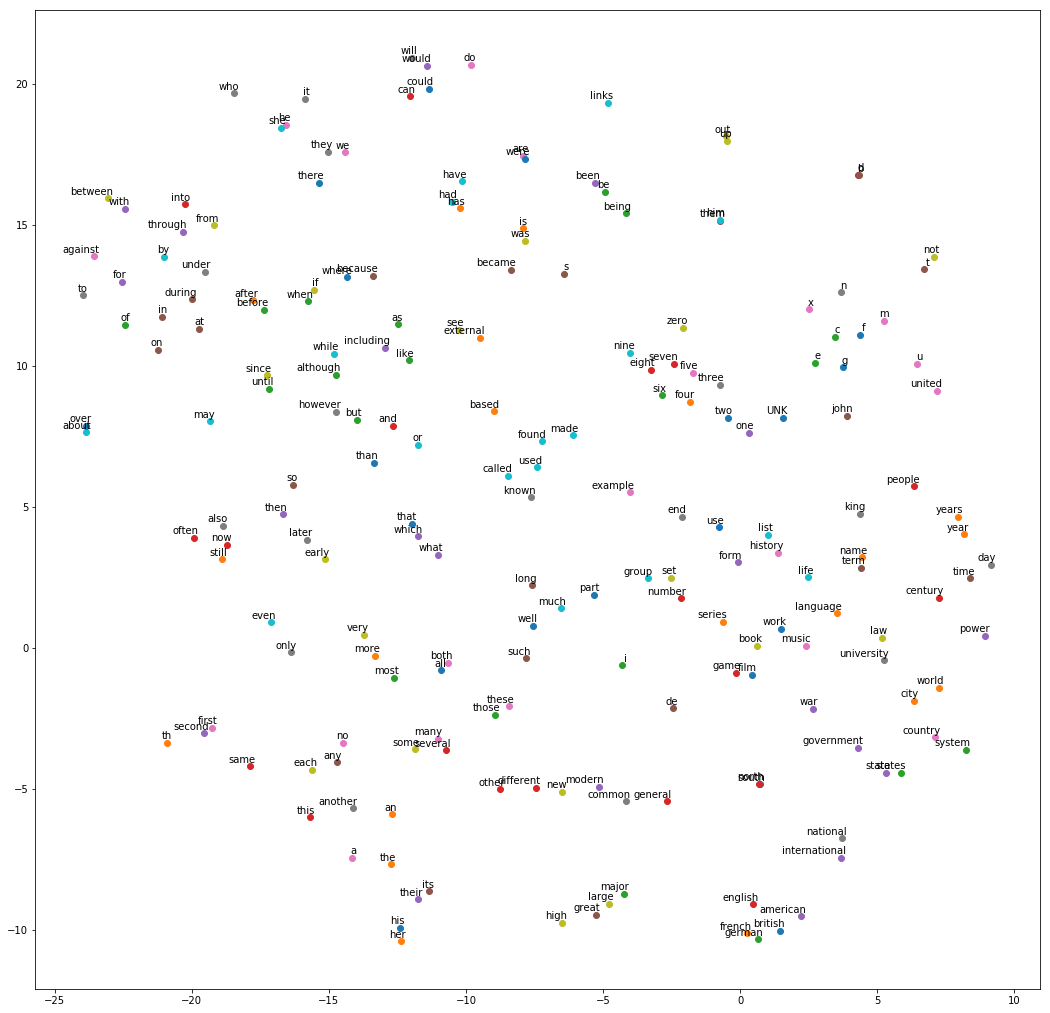

In [11]:
plt.show()